# Cluster and HII-regions Single <a class="tocSkip">

the aim of this notebook is to combine the HII-region and cluster catalogues. 
    
In this notebook we do the matching on a per galaxie basis. For each resolution, a set of output files is produced that matches the nebulae to the association catalogue

In [1]:
# reload modules after they have been modified
%load_ext autoreload
%autoreload 2

from astrotools.packages import *

from astrotools.constants import tab10, single_column, two_column

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
#logging.basicConfig(stream=sys.stdout,datefmt='%H:%M:%S',level=logging.INFO)
logger = logging.getLogger('pymuse')
handler = logging.StreamHandler(stream=sys.stdout)
handler.setLevel(logging.INFO)
fmt = logging.Formatter("%(asctime)-15s %(message)s",datefmt='%H:%M:%S')
handler.setFormatter(fmt)
logger.addHandler(handler)


basedir = Path('..')  # where we save stuff (and )
data_ext = Path('a:')/'Archive' # raw data

# we use the sample table for basic galaxy properties
sample_table = ascii.read(basedir/'..'/'pnlf'/'data'/'interim'/'sample.txt')
sample_table.add_index('name')
sample_table['SkyCoord'] = SkyCoord(sample_table['R.A.'],sample_table['Dec.'])

## Read in data

the galaxies listed in `hst_sample` have a cluster catalogue. The galaxies listed in `muse_sample` have astrosat observations to measure the FUV.

In [3]:
# choose which version of the association catalogue to use
version = 'v1p2'
HSTband = 'nuv'
scalepc = 32

name = 'NGC0628'

### MUSE (DAP + nebulae catalogues)

In [4]:
from pnlf.auxiliary import filter_table
from pnlf.io import ReadLineMaps

p = {x:sample_table.loc[name][x] for x in sample_table.columns}

# DAP linemaps (Halpha and OIII)
filename = next((data_ext/'MUSE'/'DR2.1'/'copt'/'MUSEDAP').glob(f'{name}*.fits'))
copt_res = float(filename.stem.split('-')[1].split('asec')[0])
with fits.open(filename) as hdul:
    Halpha = NDData(data=hdul['HA6562_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['HA6562_FLUX_ERR'].data),
                    mask=np.isnan(hdul['HA6562_FLUX'].data),
                    meta=hdul['HA6562_FLUX'].header,
                    wcs=WCS(hdul['HA6562_FLUX'].header))
    OIII = NDData(data=hdul['OIII5006_FLUX'].data,
                    uncertainty=StdDevUncertainty(hdul['OIII5006_FLUX_ERR'].data),
                    mask=np.isnan(hdul['OIII5006_FLUX'].data),
                    meta=hdul['OIII5006_FLUX'].header,
                    wcs=WCS(hdul['OIII5006_FLUX'].header)) 

filename = data_ext/'Products'/'Nebulae_catalogs'/'Nebulae_catalogue_v2'/'spatial_masks'/f'{name}_nebulae_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),mask=Halpha.mask,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan
    
path = data_ext / 'MUSE'/'DR2.1' / 'filterImages' 
#sdss_g, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_g_WCS_Pall_mad.fits',header=True)
#sdss_r, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_r_WCS_Pall_mad.fits',header=True)
#sdss_i, h = fits.getdata(path / f'{name}_IMAGE_FOV_SDSS_i_WCS_Pall_mad.fits',header=True)
    
# the original catalogue from Francesco
with fits.open(basedir / 'data' / 'interim' / 'Nebulae_Catalogue_v3.fits') as hdul:
    nebulae = Table(hdul[1].data)
nebulae['SkyCoord'] = SkyCoord(nebulae['cen_ra']*u.deg,nebulae['cen_dec']*u.deg,frame='icrs')
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_dig.fits') as hdul:
    dig = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_fuv.fits') as hdul:
    fuv = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_eq.fits') as hdul:
    eq_width = Table(hdul[1].data)
    
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_age.fits') as hdul:
    ages = Table(hdul[1].data)
    
nebulae = join(nebulae,fuv,keys=['gal_name','region_ID'])
nebulae = join(nebulae,eq_width,keys=['gal_name','region_ID'])
nebulae = join(nebulae,dig,keys=['gal_name','region_ID'])
nebulae = join(nebulae,ages,keys=['gal_name','region_ID'])
nebulae.rename_columns(['cen_x','cen_y'],['x','y'])


with np.errstate(divide='ignore',invalid='ignore'):
    nebulae['[SIII]/[SII]'] = np.nan
    SII = nebulae['SII6716_FLUX_CORR']+nebulae['SII6730_FLUX_CORR']
    SIII = nebulae['SIII6312_FLUX_CORR']+nebulae['SIII9068_FLUX_CORR']
    nebulae[SII>0]['[SIII]/[SII]'] = SIII[SII>0]/SII[SII>0]
    nebulae['HA/FUV'] = nebulae['HA6562_FLUX_CORR']/nebulae['FUV_FLUX_CORR']
    nebulae['HA/FUV_err'] = nebulae['HA/FUV']*np.sqrt((nebulae['HA6562_FLUX_CORR_ERR']/nebulae['HA6562_FLUX_CORR'])**2+(nebulae['FUV_FLUX_CORR_ERR']/nebulae['FUV_FLUX_CORR'])**2)


nebulae['HIIregion'] = (nebulae['BPT_NII']==0) & (nebulae['BPT_SII']==0) & (nebulae['BPT_OI']==0)
HII_regions = filter_table(nebulae,gal_name=name,BPT_NII=0,BPT_SII=0,BPT_OI=0)
nebulae = filter_table(nebulae,gal_name=name)
nebulae.add_index('region_ID')
HII_regions.add_index('region_ID')

# WFI image (larger FOV)
filename = data_ext / 'WFI' / f'{name}_Rc_flux_nosky.fits'
with fits.open(filename) as hdul:
    WFI = NDData(data=hdul[0].data,
                 meta=hdul[0].header,
                 wcs=WCS(hdul[0].header))
    
# most of the time we do not need the datacubes
if False:
    #from spectral_cube import SpectralCube
    filename = Path('g:') /'Archive'/'MUSE'/'DR2.1'/'datacubes'/f'{name}_DATACUBE_FINAL_WCS_Pall_mad.fits'
    with fits.open(filename , memmap=True, mode='denywrite') as hdul:
        data_cube   = hdul[1].data
        cube_header = hdul[1].header   
    
print(f'{name}: {len(HII_regions)} HII-regions in final catalogue')


You are currently in the enviorment `py310`.
It is recommendet to use this package in a dedicated enviornment `pymuse`.
To do this type `conda activate pymuse`.


NGC0628: 2451 HII-regions in final catalogue


In [ ]:
filename = next((data_ext/'MUSE'/'DR2.1'/'copt'/'MUSEDAP').glob(f'{name}*.fits'))
copt_res = float(filename.stem.split('-')[1].split('asec')[0])
with fits.open(filename) as hdul:
    stellar_ebv = hdul['EBV_STARS'].data

In [ ]:
stellar_ebv_muse = [stellar_ebv[int(x),int(y)] for x,y in nebulae[['x','y']]]
stellar_ebv_muse = [np.nanmean(stellar_ebv[nebulae_mask.data==region_ID]) for region_ID in nebulae['region_ID']]

In [ ]:
fig, ax=plt.subplots(figsize=(5,5))

lim = [0,1]
ax.scatter(stellar_ebv_muse,nebulae['EBV'])
ax.plot(lim,lim,color='black')
ax.plot([0,1],[0,2],color='black')

ax.set(xlim=lim,ylim=lim,xlabel=r'$E(B-V)$ stars MUSE',ylabel=r'$E(B-V)$ balmer')
plt.show()

### HST

**white light + filter images**

In [ ]:
from cluster.io import read_associations, ReadHST

associations, associations_mask = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,
                                                    HSTband=HSTband,scalepc=scalepc,version=version)

target  = name.lower()

# whitelight image (we set 0s to nan)
white_light_filename = data_ext / 'HST' / 'white_light' / f'{name.lower()}_white_24rgb.fits'
if white_light_filename.is_file():
    with fits.open(white_light_filename) as hdul:
        hst_whitelight = NDData(hdul[0].data,mask=hdul[0].data==0,meta=hdul[0].header,wcs=WCS(hdul[0].header))
        hst_whitelight.data[hst_whitelight.data==0] = np.nan
else:
    logging.warning('no white light image')
    
# filter image with uncertainties
filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{name.lower()}_f275w_v1_exp-drc-sci.fits'
with fits.open(filename) as hdul:
    F275 = NDData(hdul[0].data,
                  mask=hdul[0].data==0,
                  meta=hdul[0].header,
                  wcs=WCS(hdul[0].header))
filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{name.lower()}_f275w_v1_err-drc-wht.fits'
with fits.open(filename) as hdul:
    F275.uncertainty = StdDevUncertainty(hdul[0].data)


print(f'{name}: {len(associations)} associations in catalogue')    
# associations mask

### ALMA

In [ ]:
with fits.open(data_ext/'ALMA'/'v4p0'/f'{name.lower()}_12m+7m+tp_co21_broad_tpeak.fits') as hdul:
    CO = NDData(data=hdul[0].data,
                meta=hdul[0].header,
                wcs=WCS(hdul[0].header))

### Enviormental Masks

```
1 = center (small bulge, nuclear ring, nuclear disc, etc.)
2 = bar (excluding bar ends)
3 = bar ends (overlap of bar and spiral)
4 = interbar (R_gal < R_bar, but outside bar footprint)
5 = spiral arms inside interbar (R_gal < R_bar)
6 = spiral arms (R_gal > R_bar)
7 = interarm (only the R_gal spanned by spiral arms, and R_gal > R_bar)
8 = outer disc (R_gal > spiral arm ends, only for galaxies with identified spirals)
9 = interbar (“disc” where R_gal < R_bar) where no strong spiral arms were identified
10 = disc (R_gal > R_bar) where no spiral arms were identified (e.g. flocculent spirals)
```

In [ ]:
from reproject import reproject_interp

with fits.open(data_ext/'environment_masks'/f'{name}_simple.fits') as hdul:
    mask,footprint = reproject_interp(hdul[0],Halpha.meta,order='nearest-neighbor',return_footprint=True)
    env_masks_neb = NDData(data=mask,
                           meta=hdul[0].header,
                           wcs=Halpha.wcs)
    env_mask_org = hdul[0].data
    
    #mask = reproject_interp(hdul[0],associations_mask.meta,order='nearest-neighbor',return_footprint=False)
    #env_masks_asc = NDData(data=mask,
    #                       meta=hdul[0].header,
    #                       wcs=associations_mask.wcs)
    
    
environment_dict = {1 : 'center', 2 : 'bar', 3 : 'bar ends', 4 : 'interbar', 
                          5 : 'spiral arms',6 : 'spiral arms',7 : 'interarm' ,
                          8 : 'outer disc', 9 : 'interbar', 10 : 'disc' }

create region objects from the mask. Slightly easier to use later but a bit complicated to construct

In [ ]:
from skimage.measure import find_contours
from regions import PixCoord, PolygonPixelRegion
from functools import reduce

def region_from_mask(mask):
    
    # otherwiese we have problems with the edge of the image
    mask[:,0] = False
    mask[:,-1] = False
    mask[0,:] = False
    mask[-1,:] = False
    
    contours = find_contours(mask.astype(float),level=0.5)
    
    regs = []
    for contour in contours:
        regs.append(PolygonPixelRegion(PixCoord(*contour.T[::-1])))
     
    return regs
    #return reduce(lambda x,y:x&y,regs)

environment_regions = {}
for i in np.unique(env_masks_neb.data):
    reg = region_from_mask(np.isin(env_masks_neb.data,i))
    environment_regions[environment_dict[i]] = reg

In [ ]:
fig,ax=plt.subplots(figsize=(8,8))

norm = simple_norm(Halpha.data,clip=False,percent=99)
ax.imshow(Halpha.data,norm=norm,cmap=plt.cm.Greys,origin='lower')

mask = (env_masks_neb.data==6).astype(float)
mask[mask==0.] = np.nan
ax.imshow(mask,alpha=0.5,origin='lower')

for reg in environment_regions['spiral arms']:
    patch = reg.as_artist()
    ax.add_patch(patch)
   
ax.scatter(nebulae['x'],nebulae['y'],s=0.5)    

ax.axis('off')

plt.show()

In [ ]:
spiral_arms_pix = reduce(lambda x,y:x|y,environment_regions['spiral arms'])
spiral_arms_sky = spiral_arms_pix.to_sky(env_masks_neb.wcs)

nebulae['spiral_arms'] = spiral_arms_sky.contains(nebulae['SkyCoord'],wcs=Halpha.wcs)

### Astrosat

https://uvit.iiap.res.in/Instrument/Filters

the resolution is 0.4" per pixel. With a PSF resolution of 1.8" this leads to fwhm ~ 4.5 px. This corresponds to a std = 1.91 px

In [ ]:
# whitelight image
#astrosat_int_time = ascii.read(data_ext/'Astrosat'/'integration_time.txt',delimiter='&')
#astrosat_int_time.add_index('gal_name')
astro_file = data_ext / 'Astrosat' / f'{name}_FUV_F148W_flux_reproj.fits'
astrosat_filter = 'F148W'
if not astro_file.is_file():
    print(f'no filter F148W for {name}')
    astrosat_filter = 'F154W'
    astro_file = data_ext / 'Astrosat' / f'{name}_FUV_F154W_flux_reproj.fits'
    if not astro_file.is_file():
        astrosat_filter = None
        print(f'no astrosat file for {name}')

#astro_file = data_ext / 'Astrosat' / 'NGC4254_NUV_N242W_flux_reproj.fits'
with fits.open(astro_file) as hdul:
    astrosat = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))
    for row in hdul[0].header['COMMENT']:
        if row.startswith('CTSTOFLUX'):
            _,CTSTOFLUX = row.split(':')
            CTSTOFLUX = float(CTSTOFLUX)
        if row.startswith('IntTime'):
            _,IntTime = row.split(':')
            IntTime = float(IntTime)

In [ ]:
astrosat_to_muse = (astrosat.wcs.pixel_scale_matrix[0][0] / Halpha.wcs.pixel_scale_matrix[0][0])**2
astrosat_to_muse

## Equivalent Width

the first step is to extract the spectra of each HII-region.

Are the spectra continuum subtracted?

In [ ]:
from astropy.visualization import quantity_support
quantity_support()

filename = data_ext / 'Products' / 'Nebulae catalogue' /'spectra'/f'{name}_VorSpectra.fits'
with fits.open(filename) as hdul:
    spectra = Table(hdul[1].data)
    spectral_axis = np.exp(Table(hdul[2].data)['LOGLAM'])*u.Angstrom
    
spectra['region_ID'] = np.arange(len(spectra))
spectra.add_index('region_ID')

In [ ]:
H0 = 67 * u.km / u.s / u.Mpc
z = (H0*Distance(distmod=p['(m-M)'])/c.c).decompose()
lam_HA0 = 6562.8*u.Angstrom
lam_HA = (1+z)*lam_HA0

lam_HA

In [ ]:
from cluster.spectrum import fit_emission_line

region_ID = 10
#lam_HA = 6595*u.Angstrom
filename = basedir/'reports'/name/f'{name}_eqwidth.png'
flux = spectra.loc[region_ID]['SPEC']*u.erg/u.s/u.cm**2/u.A
fit = fit_emission_line(spectral_axis,flux,lam_HA,filename=filename)
integrated_flux = fit.amplitude_0*np.sqrt(np.pi)*np.exp(-1/(2*fit.stddev_0**2)) * u.erg/u.s/u.cm**2

print(f"f_cat/f_fit = {nebulae.loc[region_ID]['HA6562_FLUX']/integrated_flux.value:.2f}")

In [ ]:
from tqdm import tqdm

#lam_HA = 6595*u.Angstrom

HA = []
HII_regions['eq_width'] = np.nan
for region_ID in tqdm(HII_regions['region_ID']):
    
    flux = spectra.loc[region_ID]['SPEC']*u.erg/u.s/u.cm**2/u.A
    fit = fit_emission_line(spectral_axis,flux,lam_HA,plot=False)
    integrated_flux = fit.amplitude_0*np.sqrt(np.pi)*np.exp(-1/(2*fit.stddev_0**2)) * u.erg/u.s/u.cm**2
    continuum = fit.c0_1 * u.erg/u.s/u.cm**2/u.Angstrom
    eq_width = integrated_flux/continuum
    eq_width = HII_regions.loc[region_ID]['HA6562_FLUX']/continuum
    HII_regions.loc[region_ID]['eq_width'] = eq_width.value
    
    HA.append(integrated_flux)
    #HA_cat = nebulae.loc[region_ID]['HA6562_FLUX']
    #print(f'{integrated_flux/HA_cat:.2f}')
    #print(f'HA = {fit.mean_0.value:.2f}')
HA = np.array([x.value for x in HA])

In [ ]:
fig,ax=plt.subplots(figsize=(5,5))

ax.scatter(HA,HII_regions['HA6562_FLUX']/2.5)
x = np.linspace(0,2e6)
ax.plot(x,x,color='black')
ax.set(ylim=[0,2e6],xlim=[0,2e6])
plt.show()

## HST and MUSE

### compare footprints of different observations

here we compare the footprints of the observations and check which objects overlap. The FOV of astrosat is a circle with a diameter of 28'. This is much larger than HST and MUSE and both will always be covered by the astrosat observations

NGC0628
987 (of 1077) associations in MUSE FOV
2563 (of 2869) nebulae in HST FOV

NGC1365
499 (of 518) associations in MUSE FOV
907 (of 1455) nebulae in HST FOV

NGC1433
495 (of 496) associations in MUSE FOV
1011 (of 1736) nebulae in HST FOV

NGC1566
1584 (of 1653) associations in MUSE FOV
2112 (of 2404) nebulae in HST FOV

NGC3351
710 (of 836) associations in MUSE FOV
1179 (of 1284) nebulae in HST FOV


NGC3627
1330 (of 1415) associations in MUSE FOV
1635 (of 1635) nebulae in HST FOV

NGC4535
475 (of 647) associations in MUSE FOV
1555 (of 1938) nebulae in HST FOV

In [ ]:
from cluster.regions import find_sky_region

reg_muse_pix, reg_muse_sky = find_sky_region(nebulae_mask.mask.astype(int),wcs=nebulae_mask.wcs)
reg_hst_pix, reg_hst_sky = find_sky_region(hst_whitelight.mask.astype(int),wcs=hst_whitelight.wcs)

# check which nebulae/clusters are within the HST/MUSE FOV
associations['in_frame'] = reg_muse_sky.contains(associations['SkyCoord'],nebulae_mask.wcs)
#clusters['in_frame'] = reg_muse_sky.contains(clusters['SkyCoord'],nebulae_mask.wcs)
nebulae['in_frame']  = reg_hst_sky.contains(nebulae['SkyCoord'],nebulae_mask.wcs)

print(f'{np.sum(associations["in_frame"])} (of {len(associations)}) associations in MUSE FOV')
#print(f'{np.sum(clusters["in_frame"])} (of {len(clusters)}) clusters in MUSE FOV')
print(f'{np.sum(nebulae["in_frame"])} (of {len(nebulae)}) nebulae in HST FOV')

In [ ]:
WFI_cutout = Cutout2D(WFI.data,p['SkyCoord'],size=6*u.arcmin,wcs=WFI.wcs)

# project from muse to hst coordinates
reg_muse_wfi = reg_muse_sky.to_pixel(WFI_cutout.wcs)
reg_hst_wfi  = reg_hst_sky.to_pixel(WFI_cutout.wcs)

# plot image
ax = quick_plot(WFI_cutout,figsize=(single_column,single_column),cmap=plt.cm.gray)
add_scale(ax,u.arcmin,label="1'",color='white',fontsize=10)

reg_muse_wfi.plot(ax=ax,ec='tab:red',label='MUSE')
reg_hst_wfi.plot(ax=ax,ec='tab:orange',label='HST')

#ax.set(xlim=[3000,11000],ylim=[3000,11000])
plt.savefig(basedir/'reports'/name/'footpring.pdf',dpi=600)
plt.show()

## Association and nebulae

the association catalogue differs from the clusters in that its entries are extended. Because we match two catalogues with extended objects, we must proceed differently.

In a first step we take a look at a single association

In [ ]:
from skimage.measure import find_contours
from regions import PixCoord, PolygonPixelRegion

assoc_ID = 10
pos = associations['SkyCoord'][associations['assoc_ID']==assoc_ID]

contours = find_contours(associations_mask.data==assoc_ID,0.5,)
coords = max(contours,key=len)

# the coordinates from find_counters are switched compared to astropy
reg_pix  = PolygonPixelRegion(vertices = PixCoord(*coords.T[::-1])) 
reg_sky  = reg_pix.to_sky(associations_mask.wcs)

mask_cutout = Cutout2D(associations_mask.data,pos,size=1*u.arcsecond,wcs=associations_mask.wcs)
F275_cutout = Cutout2D(F275.data,pos,size=2*u.arcsecond,wcs=F275.wcs)

reg_pix_cut  = reg_sky.to_pixel(mask_cutout.wcs)

ax = quick_plot(F275_cutout,figsize=(single_column,single_column),cmap=plt.cm.gray)
ax.imshow(mask_cutout.data,alpha=0.5)

reg_pix_cut.plot(ax=ax,ec='tab:red',label='MUSE')

plt.show()

to match the nebulae to the associations we first reproject the mask of the nebulae to the HST image. We then scale the association mask by the number of associations (assume we have 1432 objects, then 615 becomes 0.0615). This way we can add the two masks together and infer from the resulting unique values which clusters overlap with which associations

### Match catalogues

and make some plots that showcase the position/overlap

```
# NGC3627 is too large to reproject
#center = SkyCoord(sample_table.loc[name]['R.A.'],sample_table.loc[name]['Dec.'])
#cutout = Cutout2D(associations_mask.data,center,size=(5.5*u.arcmin,3*u.arcmin),wcs=associations_mask.wcs)
cutout = Cutout2D(associations_mask.data,(3000,4800),size=(9000,5500),wcs=associations_mask.wcs)

nebulae_hst, _  = reproject_interp(nebulae_mask,
                                   output_projection=cutout.wcs,
                                   shape_out=cutout.data.shape,
                                   order='nearest-neighbor')    
scale = 10**np.ceil(np.log10(max(cutout.data[~np.isnan(cutout.data)])))
s_arr = cutout.data/scale+nebulae_hst
```

In [ ]:
from reproject import reproject_interp
# reproject nebulae mask to hst 
nebulae_hst, _  = reproject_interp(nebulae_mask,
                                   output_projection=associations_mask.wcs,
                                   shape_out=associations_mask.data.shape,
                                   order='nearest-neighbor')    

# we scale the associations such that the the id is in the decimal
scale = 10**np.ceil(np.log10(max(associations_mask.data[~np.isnan(associations_mask.data)])))
s_arr = associations_mask.data/scale+nebulae_hst

header = associations_mask.wcs.to_header()
header['scale'] = scale
#hdu = fits.PrimaryHDU(s_arr,header=header)
#hdu.writeto(basedir/'data'/'map_nebulae_association'/f'{name}_map.fits',overwrite=True)

In [ ]:
# ids of associations, nebulae and combination (sum) of both
a_id = np.unique(associations_mask.data[~np.isnan(associations_mask.data)]).astype(int)
n_id = np.unique(nebulae_mask.data[~np.isnan(nebulae_mask.data)]).astype(int)
s_id = np.unique(s_arr[~np.isnan(s_arr)])

# this splits the sum into two parts (nebulae and associations)
a_modf,n_modf = np.modf(s_id)
n_modf = n_modf.astype(int)
a_modf = np.round(a_modf*scale).astype(int)

unique_a, count_a = np.unique(a_modf,return_counts=True)
unique_n, count_n = np.unique(n_modf,return_counts=True)

nebulae_dict = {int(n) : a_modf[n_modf==n].tolist() for n in n_id}     
associations_dict = {int(a) : n_modf[a_modf==a].tolist() for a in a_id}     


# so far we ensured that the nebulae in unique_n have only one association,
# but it is possible that this association goes beyond the nebulae and into
# a second nebulae. Those objects are excluded here
isolated_nebulae = set()
isolated_assoc   = set()
for n,v in nebulae_dict.items():
    if len(v)==1:
        if len(associations_dict[v[0]])==1:
            isolated_nebulae.add(n)
            isolated_assoc.add(v[0])
            
print(f'n_associations = {len(associations_dict)}')
print(f'n_nebulae      = {len(nebulae_dict)}')
print(f'1to1 match     = {len(isolated_nebulae)}')


# we save those two dicts so we do not have to redo this everytime
with open(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_nebulae.yml','w+') as f:
    yaml.dump(nebulae_dict,f)
with open(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_associations.yml','w+') as f:
    yaml.dump(associations_dict,f)

#### for associations

In [ ]:
# find all assoc that have at least one pixel outside of the nebulae masks
mask = associations_mask.data.copy()
mask[~np.isnan(nebulae_hst)] = np.nan
outside = np.unique(mask[~np.isnan(mask)].astype(int))

# find all assoc that have at least one pixel inside of the nebulea masks
mask = associations_mask.data.copy()
mask[np.isnan(nebulae_hst)] = np.nan
inside = np.unique(mask[~np.isnan(mask)].astype(int))

contained = np.setdiff1d(inside,outside)
partial   = np.intersect1d(inside,outside)
isolated  = np.setdiff1d(outside,inside)

print(f'contained: {len(contained)}\npartial: {len(partial)}\nisolated: {len(isolated)}')

In [ ]:
assoc_tmp = associations[['assoc_ID']].copy()
assoc_tmp.add_index('assoc_ID')

x_asc,y_asc = associations['SkyCoord'].to_pixel(env_masks_neb.wcs)
outside = (x_asc > env_masks_neb.data.shape[1]) | (y_asc > env_masks_neb.data.shape[0])
x_asc[outside] = 0
y_asc[outside] = 0
assoc_tmp['env_asc'] = [environment_dict[env_masks_neb.data[y,x]] for 
                          x,y in zip(x_asc.astype(int),y_asc.astype(int))]
assoc_tmp[outside]['env_asc'] = ''

assoc_tmp['overlap'] = np.empty(len(associations),dtype='U9')
assoc_tmp['overlap'][np.isin(assoc_tmp['assoc_ID'],contained)] = 'contained'
assoc_tmp['overlap'][np.isin(assoc_tmp['assoc_ID'],partial)]   = 'partial'
assoc_tmp['overlap'][np.isin(assoc_tmp['assoc_ID'],isolated)]  = 'isolated'
assoc_tmp['1to1'] = False
assoc_tmp['1to1'][np.isin(assoc_tmp['assoc_ID'],list(isolated_assoc))] = True
assoc_tmp['Nnebulae'] = [len(associations_dict[k]) for k in assoc_tmp['assoc_ID']]

assoc_tmp['region_ID'] = np.nan
assoc_tmp['region_ID'][assoc_tmp['1to1']] = [associations_dict[k][0] for k in assoc_tmp[assoc_tmp['1to1']]['assoc_ID']]

overlap = join(
    Table(np.unique(associations_mask.data[~np.isnan(associations_mask.data)],return_counts=True),names=['assoc_ID','size']),
    Table(np.unique(associations_mask.data[~np.isnan(nebulae_hst) & ~np.isnan(associations_mask.data)],return_counts=True),names=['assoc_ID','overlap_size']),
    keys=['assoc_ID'],join_type='outer')
overlap = overlap.filled(0)
overlap['overlap_asc'] = overlap['overlap_size']/overlap['size']
overlap['overlap_asc'].info.format = '%.2f'
assoc_tmp = join(assoc_tmp,overlap[['assoc_ID','overlap_asc']],keys='assoc_ID')

print('write to file')
hdu = fits.BinTableHDU(assoc_tmp,name='joined catalogue')
hdu.writeto(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_associations.fits',overwrite=True)

#### for nebulae

In [ ]:
from cluster.regions import find_neighbors
from tqdm import tqdm 

nebulae_tmp = nebulae[['region_ID','x','y']].copy()
nebulae_tmp.add_index('region_ID')

nebulae_tmp['env_neb'] = [environment_dict[env_masks_neb.data[y,x]] for 
                          x,y in zip(nebulae_tmp['x'].astype(int),nebulae_tmp['y'].astype(int))]

nebulae_tmp['neighbors'] = np.nan
for row in tqdm(nebulae_tmp):
    row['neighbors'] = len(find_neighbors(nebulae_mask.data,tuple(row[['x','y']]),row['region_ID'],plot=False))
del nebulae_tmp[['x','y']]

nebulae_tmp['1to1'] = False
nebulae_tmp['1to1'][np.isin(nebulae_tmp['region_ID'],list(isolated_nebulae))] = True
nebulae_tmp['Nassoc'] = [len(nebulae_dict[k]) for k in nebulae_tmp['region_ID']]
nebulae_tmp['assoc_ID'] = np.nan
nebulae_tmp['assoc_ID'][nebulae_tmp['1to1']] = [nebulae_dict[k][0] for k in nebulae_tmp[nebulae_tmp['1to1']]['region_ID']]


overlap = join(
    Table(np.unique(nebulae_hst[~np.isnan(nebulae_hst)],return_counts=True),names=['region_ID','size']),
    Table(np.unique(nebulae_hst[~np.isnan(nebulae_hst) & ~np.isnan(associations_mask.data)],return_counts=True),names=['region_ID','overlap_size']),
    keys=['region_ID'],join_type='outer')
overlap = overlap.filled(0)
overlap['overlap_neb'] = overlap['overlap_size']/overlap['size']
overlap['overlap_neb'].info.format = '%.2f'
nebulae_tmp = join(nebulae_tmp,overlap[['region_ID','overlap_neb']],keys='region_ID')


hdu = fits.BinTableHDU(nebulae_tmp,name='joined catalogue')
hdu.writeto(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_nebulae.fits',overwrite=True)
#del nebulae_tmp['1to1']

print(f'{np.sum(nebulae_tmp["neighbors"]==0)} nebulae have no neighbors')

#### join catalogues

In [ ]:
from astropy.table import join
from astropy.coordinates import match_coordinates_sky

catalogue = join(assoc_tmp,nebulae_tmp,keys=['assoc_ID','region_ID'])
catalogue = join(catalogue,nebulae,keys='region_ID')
catalogue = join(catalogue,associations,keys='assoc_ID')

# pay attention to the order of assoc, neb
catalogue.rename_columns(['X','Y','x','y','RA','DEC','cen_ra','cen_dec',
                          'reg_area','region_area',
                          'EBV_1','EBV_2','EBV_err','EBV_ERR',
                          'SkyCoord_1','SkyCoord_2'],
                         ['x_asc','y_asc','x_neb','y_neb','ra_asc','dec_asc','ra_neb','dec_neb',
                          'area_asc','area_neb',
                          'EBV_balmer','EBV_stars','EBV_balmer_err','EBV_stars_err',
                          'SkyCoord_asc','SkyCoord_neb'])

# separation to other associations and nebulae
idx,sep_asc,_= match_coordinates_sky(catalogue['SkyCoord_asc'],associations['SkyCoord'],nthneighbor=2)
idx,sep_neb,_= match_coordinates_sky(catalogue['SkyCoord_neb'],nebulae['SkyCoord'],nthneighbor=2)
catalogue['sep_asc'] = sep_asc.to(u.arcsec)
catalogue['sep_neb'] = sep_neb.to(u.arcsec)

# select the columns of the joined catalogue
columns = ['assoc_ID','region_ID','x_asc','y_asc','x_neb','y_neb',
           'ra_asc','dec_asc','ra_neb','dec_neb','SkyCoord_asc','SkyCoord_neb',
           'env_asc','env_neb','area_asc','area_neb',
           'sep_asc','sep_neb','neighbors','Nassoc','overlap','overlap_asc','overlap_neb',
           'age','age_err','mass','mass_err','EBV_stars','EBV_stars_err','EBV_balmer','EBV_balmer_err',
           'met_scal','met_scal_err','logq_D91','logq_D91_err',] + \
            [x for x in HII_regions.columns if x.endswith('_FLUX_CORR')] + \
            [x for x in HII_regions.columns if x.endswith('_FLUX_CORR_ERR')] + \
            ['NUV_FLUX','NUV_FLUX_ERR','U_FLUX','U_FLUX_ERR','B_FLUX','B_FLUX_ERR',
             'V_FLUX','V_FLUX_ERR','I_FLUX','I_FLUX_ERR'] + \
            ['HA/FUV','eq_width']
catalogue = catalogue[columns]
        
catalogue.rename_columns([col for col in catalogue.columns if col.endswith('FLUX_CORR')],
                      [col.replace('FLUX_CORR','flux') for col in catalogue.columns if col.endswith('FLUX_CORR')])
catalogue.rename_columns([col for col in catalogue.columns if col.endswith('FLUX_CORR_ERR')],
                      [col.replace('FLUX_CORR_ERR','flux_err') for col in catalogue.columns if col.endswith('FLUX_CORR_ERR')])
catalogue['assoc_ID'] = catalogue['assoc_ID'].astype('int')
catalogue['region_ID'] = catalogue['region_ID'].astype('int')

catalogue.info.description = 'Joined catalogue between associations and nebulae'
mean_sep = np.mean(catalogue['SkyCoord_asc'].separation(catalogue['SkyCoord_neb']))
print(f'{len(catalogue)} objects in catalogue')
print(f'the mean separation between cluster and association center is {mean_sep.to(u.arcsecond):.2f}')

#### Write
export parts of the joined catalogue (right now only the fully contained objects)

In [ ]:
export = catalogue.copy() #[catalogue['contained']]
#export.add_column(export['SkyCoord_asc'].to_string(style='hmsdms',precision=2),index=6,name='RaDec_asc')
#export.add_column(export['SkyCoord_neb'].to_string(style='hmsdms',precision=2),index=8,name='RaDec_neb')

RA_asc ,DEC_asc = zip(*[x.split(' ') for x in export['SkyCoord_asc'].to_string(style='hmsdms',precision=2)])
RA_neb ,DEC_neb = zip(*[x.split(' ') for x in export['SkyCoord_neb'].to_string(style='hmsdms',precision=2)])

export.add_column(RA_asc,index=6,name='Ra_asc')
export.add_column(DEC_asc,index=8,name='Dec_asc')
export.add_column(RA_neb,index=10,name='Ra_neb')
export.add_column(DEC_neb,index=12,name='Dec_neb')

for col in export.columns:
    if col not in ['Ra_asc','Dec_asc','Ra_neb','Dec_neb','region_ID','cluster_ID','overlap','env_asc','env_neb']:
        export[col].info.format = '%.2f'

del export[['ra_asc','dec_asc','ra_neb','dec_neb','SkyCoord_neb','SkyCoord_asc','HA/FUV']]

hdu = fits.BinTableHDU(export,name='joined catalogue')
hdu.writeto(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_associations_and_nebulae_joined.fits',overwrite=True)

#### Read

In [ ]:
from astropy.table import join

with open(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_nebulae.yml') as f:
    nebulae_dict = yaml.load(f,Loader=yaml.SafeLoader)
with open(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_associations.yml') as f:
    associations_dict = yaml.load(f,Loader=yaml.SafeLoader)
    
filename = basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_associations.fits'
assoc_tmp = Table(fits.getdata(filename,ext=1))
associations=join(associations,assoc_tmp,keys='assoc_ID')
associations.add_index('assoc_ID')

filename = basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_nebulae.fits'
nebulae_tmp = Table(fits.getdata(filename,ext=1))
nebulae=join(nebulae,nebulae_tmp,keys='region_ID')
nebulae.add_index('region_ID')
# read in existing catalogues
filename = basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_associations_and_nebulae_joined.fits'
catalogue = Table(fits.getdata(filename,ext=1))

catalogue['SkyCoord_asc'] = SkyCoord(catalogue['Ra_asc'],catalogue['Dec_asc'])
catalogue['SkyCoord_neb'] = SkyCoord(catalogue['Ra_neb'],catalogue['Dec_neb'])
#catalogue['HA/FUV'] = catalogue['HA6562_flux']/catalogue['FUV_flux']
#catalogue['HA/FUV_err'] = catalogue['HA/FUV']*np.sqrt((catalogue['HA6562_flux_err']/catalogue['HA6562_flux'])**2+(catalogue['FUV_flux_err']/catalogue['FUV_flux'])**2)

#### save cutout for each region in seperate fits file

In [ ]:
from reproject import reproject_interp 

def save_cutouts(position,size=4*u.arcsec):
    
    header = fits.Header()
    header['gal_name'] = name
    header['RA'] = row['SkyCoord_asc'].ra.to(u.degree).value
    header['DEC'] = row['SkyCoord_asc'].dec.to(u.degree).value
    header['RADESYS'] = 'ICRS'
    header['regionID'] = row['region_ID']
    header['assocID'] = row['cluster_ID']

    hdul = fits.HDUList([fits.PrimaryHDU(header=header)])

    # save HST image
    cutout = Cutout2D(F275.data,position=position,size=size,wcs=F275.wcs)
    hdul.append(fits.ImageHDU(cutout.data,header=cutout.wcs.to_header(),name='F275'))

    # save Halpha
    Halpha_cutout, _  = reproject_interp(Halpha,output_projection=cutout.wcs,shape_out=cutout.shape,order='bilinear')    
    hdul.append(fits.ImageHDU(Halpha_cutout,header=cutout.wcs.to_header(),name='Halpha'))


    # save OIII
    OIII_cutout, _  = reproject_interp(OIII,output_projection=cutout.wcs,shape_out=cutout.shape,order='bilinear')    
    hdul.append(fits.ImageHDU(OIII_cutout,header=cutout.wcs.to_header(),name='OIII'))


    # save nebulae mask
    nebulae_cutout, _  = reproject_interp(nebulae_mask,output_projection=cutout.wcs,shape_out=cutout.shape,order='nearest-neighbor')    
    hdul.append(fits.ImageHDU(nebulae_cutout,header=cutout.wcs.to_header(),name='nebulae'))


    # save association mask
    assoc_cutout, _  = reproject_interp(associations_mask,output_projection=cutout.wcs,shape_out=cutout.shape,order='nearest-neighbor')    
    hdul.append(fits.ImageHDU(assoc_cutout,header=cutout.wcs.to_header(),name='assoc'))

    hdul.writeto(basedir/'data'/'cutouts'/f'{name}_region{row["region_ID"]}.fits',overwrite=True,checksum=True)
    
    
row = catalogue[0]
position = row['SkyCoord_neb']

save_cutouts(position)

## Multiple associations inside one nebulae 

In [ ]:
print(f'nebulae in galaxy: {len(nebulae)}')
print(f'HII regions in galaxy: {len(HII_regions)}')
print(f'associations in galaxy: {len(associations)}')

print(f'nebulae that overlap with association: {np.sum(nebulae["overlap_neb"]>0)}')
print(f'associations that overlap with nebulae: {np.sum(associations["overlap_asc"]>0)}')
print(f'one-to-one relation: {np.sum(associations["1to1"])}')


In [ ]:
with open(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_nebulae.yml') as f:
    nebulae_dict = yaml.load(f,Loader=yaml.SafeLoader)
with open(basedir/'data'/'map_nebulae_association'/version/HSTband/f'{scalepc}pc'/f'{name}_{HSTband}_{scalepc}pc_associations.yml') as f:
    associations_dict = yaml.load(f,Loader=yaml.SafeLoader)
    
age_diff = []
ovl_diff = []
mass_diff = []
mass_div = []

candidates = []

# we select each nebulae with more than one HII region
for region_ID in nebulae_tmp[nebulae_tmp['Nassoc']>1]['region_ID']:
    for assoc_ID in nebulae_dict[region_ID]:
        
        # if one of the associations also overlaps with another nebulae we reject it
        if len(associations_dict[assoc_ID])>1:
            break
        # we want a certain amount of overlap
        if associations.loc[assoc_ID]['overlap_asc'] <0.0:
            break
        #if associations.loc[assoc_ID]['mass'] <1e4:
        #    break
    else:
        candidates.append(region_ID)
        if len(nebulae_dict[region_ID])==2:
            sub = associations.loc[nebulae_dict[region_ID]]
            sub.sort('mass')
            
            age_diff.append(np.diff(sub['age'])[0])
            mass_diff.append(np.diff(sub['mass'])[0])
            mass_div.append(sub['mass'][1]/sub['mass'][0])

print(f'{len(candidates)} of {np.sum(nebulae_tmp["Nassoc"]>1)} match the criteria')

In [ ]:
candidates = []

# we select each nebulae with more than one HII region
for region_ID in nebulae_tmp[nebulae_tmp['Nassoc']>1]['region_ID']:
    sub = associations.loc[nebulae_dict[region_ID]]
    # first we check if we can ignore the other associations in the nebulae
    if np.sum((sub['age']<10) & (sub['mass']>1e4)) == 1:
        # then we make sure that the one associations also overlaps sufficiently
        if np.sum((sub['age']<10) & (sub['mass']>1e4) & (sub['overlap_asc']>0.5)) == 1:
            candidates.append(region_ID)
        
print(f'{len(candidates)} of {np.sum(nebulae_tmp["Nassoc"]>1)} match the criteria')

In [ ]:
fig=plt.figure(figsize=(single_column,single_column/1.618))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)


xlim = [1e2,1e5]
ylim = [-12,12]

x,y = mass_diff,age_diff
nbins=11
bins = [np.logspace(*np.log10(xlim),12),np.linspace(*ylim,13)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=False)
im = ax.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.Reds)

ax_histx.hist(x,bins[0],color='#af1d1d')
ax_histy.hist(y,bins[1],orientation='horizontal',color='#af1d1d')

ax_histx.set_yticks([400])
ax_histy.set_xticks([1000])
ax.plot([1e2,1e5],[0,0],color='black')

ax.set(xlim=xlim,xscale='log',xlabel=r'$\Delta$ mass / M$_\odot$',
       ylim=ylim,ylabel='$\Delta$ age / Myr')
fig.colorbar(im,label='count')

plt.show()

In [ ]:
fig=plt.figure(figsize=(single_column,single_column/1.618))

gs = fig.add_gridspec(2, 2,  width_ratios=(7, 2), height_ratios=(2, 7),
                      left=0.1, right=0.9, bottom=0.1, top=0.9,
                      wspace=0.0, hspace=0.0)

ax = fig.add_subplot(gs[1, 0])
ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)
ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)

ax_histx.tick_params(axis="x", labelbottom=False)
ax_histy.tick_params(axis="y", labelleft=False)

print(f'{np.sum(np.array(mass_div)>10)} objects differ by a factor >10')
xlim = [1,10]
ylim = [-12,12]

x,y = mass_div,age_diff
nbins=11
bins = [np.linspace(*xlim,10),np.linspace(*ylim,13)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=False)
im = ax.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.Reds)

ax_histx.hist(x,bins[0],color='#af1d1d')
ax_histy.hist(y,bins[1],orientation='horizontal',color='#af1d1d')

ax_histx.set_yticks([400])
ax_histy.set_xticks([1000])
ax.plot([1,200],[0,0],color='black')

ax.set(xlim=xlim,xscale='linear',xlabel=r'mass0 / mass1',
       ylim=ylim,ylabel='$\Delta$ age / Myr')
fig.colorbar(im,label='count')

plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(single_column,single_column/1.618))
xlim = [10,1e5]
ylim = [0,10]

x,y = mass_diff, age_diff
nbins=11
bins = [np.logspace(*np.log10(xlim),16),np.linspace(*ylim,9)]
hist, x_e, y_e = np.histogram2d(x,y,bins=bins,density=False)
im = ax.pcolormesh(x_e,y_e,hist.T,cmap=plt.cm.Reds)

ax.set(xlim=xlim,xscale='log',xlabel=r'$\Delta$ mass / M$_\odot$',
       ylim=ylim,yscale='linear',ylabel='$\Delta$ age / Myr')
fig.colorbar(im,label='count')
#plt.savefig(basedir/'reports'/'tmp_catalogue_properties_2D_hist.png',dpi=300)
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(two_column,two_column/1.618))
xlim = [1e2,1e5]
ylim = [1,20]

for region_ID in nebulae_tmp[nebulae_tmp['Nassoc']>1]['region_ID']:
    if len(nebulae_dict[region_ID])==2:
        sub = associations.loc[nebulae_dict[region_ID]]
        ax.errorbar(sub['mass'],sub['age'],fmt='o-',color='black')

ax.set(xlim=xlim,xscale='log',xlabel=r'$\Delta$ mass / M$_\odot$',
       ylim=ylim,yscale='linear',ylabel='$\Delta$ age / Myr')
#plt.savefig(basedir/'reports'/'tmp_catalogue_properties_2D_hist.png',dpi=300)
plt.show()

In [ ]:
# example 445, 375
sub = associations.loc[nebulae_dict[223]]
sub[['mass','age','overlap_asc']]

look at cutouts of the sample

In [ ]:
from cluster.plot import multi_page_cutout

filename = basedir/'reports'/'multiple_associations.pdf'

sample = nebulae.loc[candidates]
positions = sample['SkyCoord']
labels = sample['region_ID']

multi_page_cutout(positions = positions,
             image = F275,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             #points= clusters,
             labels= labels,
             size = 10*u.arcsecond,
             filename=filename,
             ncols=5,nrows=4)

In [ ]:
from starburst import Cluster

cluster = Cluster(stellar_model='GENEVAv40',metallicity=0.014)
cluster.measure_FUV()

In [ ]:
fig,ax=plt.subplots()

ax.plot(cluster.quanta['Time']/1e6,cluster.quanta['HI_rate']/cluster.quanta['HI_rate'][0])
ax.set(yscale='log',xlim=[1,20])
plt.show()

### Weighted averages

In [ ]:
a_modf,n_modf = np.modf(s_id)
n_modf = n_modf.astype(int)
a_modf = np.round(a_modf*scale).astype(int)

In [ ]:
a_mod_arr,n_mod_arr = np.modf(s_arr)

In [ ]:
region_ID = 24
a_id,a_count = np.unique(a_mod_arr[n_mod_arr==region_ID]*scale,return_counts=True)

In [ ]:
with nebulae.index_mode('discard_on_copy'):
    nebulae_ages = nebulae[['gal_name','region_ID','Nassoc']].copy()
nebulae_ages.add_index('region_ID')

min_overlap = 0

nebulae_ages['age_mw']   = np.nan   # mass weighted
nebulae_ages['age_lw']   = np.nan   # light weighted
nebulae_ages['age_sw']   = np.nan   # size weighted
nebulae_ages['age_mean'] = np.nan
nebulae_ages['age_min']  = np.nan
nebulae_ages['age_max']  = np.nan
nebulae_ages['mass_sum'] = np.nan

for region_ID in nebulae_ages['region_ID']:
    #region_ID = row['region_ID']
    assoc_IDs = nebulae_dict[region_ID]
    if len(assoc_IDs)==0:
        continue
    sub = associations.loc[assoc_IDs]
        
    nebulae_ages.loc[region_ID]['age_mw'] = np.average(sub['age'],weights=sub['mass'])
    nebulae_ages.loc[region_ID]['age_lw'] = np.average(sub['age'],weights=sub['NUV_FLUX'])
    nebulae_ages.loc[region_ID]['age_mean'] = np.mean(sub['age'])
    nebulae_ages.loc[region_ID]['age_min'] = np.min(sub['age'])
    nebulae_ages.loc[region_ID]['age_max'] = np.max(sub['age'])
    nebulae_ages.loc[region_ID]['mass_sum'] = np.sum(sub['mass'])

    
    a_id,a_count = np.unique(a_mod_arr[n_mod_arr==region_ID]*scale,return_counts=True)
    nebulae_ages.loc[region_ID]['age_sw'] = np.average(np.atleast_1d(sub['age']),weights=a_count)


In [ ]:
import warnings
from astrotools.plot import corner

lim = [0,20]

print(f'1to1: {np.sum(nebulae["1to1"])}\nnow: {np.sum(~np.isnan(nebulae_ages["age_sw"]))}')

columns = ['age_mean','age_mw','age_lw','age_sw']
def plt_func(x,y,ax,xlim=None): 
    ax.scatter(x,y)
    ax.plot(lim,lim,color='black')
limits  = {key:lim for key in columns}

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    corner(nebulae_ages,columns=columns,limits=limits,function=plt_func)

In [ ]:
fig,ax=plt.subplots(figsize=(5,5))

tmp = nebulae_ages[nebulae['1to1']]
ax.scatter(tmp['age_mw'],tmp['age_sw'])
ax.plot([0,100],[0,100],color='black')
ax.set(xlim=[0,100],ylim=[0,100])
plt.show()

## Isolated HII regions

In [ ]:
# it is useful to only include HII regions in the overlapping regions
with fits.open(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_in_frame.fits') as hdul:
    in_frame = Table(hdul[1].data)
nebulae = join(nebulae,in_frame,keys=['gal_name','region_ID'])
distance = Distance(distmod=sample_table.loc[name]['(m-M)'])
nebulae['distance'] = distance
nebulae['HA6562_LUM_CORR'] = (nebulae['HA6562_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2 *4*np.pi*(distance)**2).to(u.erg/u.s)

In [ ]:
fig,ax=plt.subplots()

tmp = nebulae[nebulae['overlap_neb']==0]
ax.hist(tmp['region_area'],bins=np.linspace(50,500,10),label='isolated',alpha=0.5)

tmp = nebulae[nebulae['overlap_neb']>0]
ax.hist(tmp['region_area'],bins=np.linspace(50,500,10),label='overlapping',alpha=0.5)

ax.legend()

plt.show()

In [ ]:
with fits.open(basedir/'data'/'external'/'PHANGS_IR3_ngc2835_phangs-hst_v1p1_ml_class12.fits') as hdul:
    compact_clusters = Table(hdul[1].data)
compact_clusters['SkyCoord'] = SkyCoord(compact_clusters['PHANGS_RA']*u.deg,compact_clusters['PHANGS_DEC']*u.deg)

In [ ]:
with fits.open(data_ext/'Products'/'stellar_associations'/'DOLPHOT'/f'{name.lower()}_uvis_dolphot.fits') as hdul:
    dolphot_peaks = Table(hdul[1].data)
#compact_clusters['SkyCoord'] = SkyCoord(compact_clusters['PHANGS_RA']*u.deg,compact_clusters['PHANGS_DEC']*u.deg)
dolphot_peaks['SkyCoord'] = SkyCoord.from_pixel(dolphot_peaks['Dolphot_x'],dolphot_peaks['Dolphot_y'],wcs=F275.wcs)

#dolphot_peaks = dolphot_peaks[np.isin(dolphot_peaks['Dolphot_ID'],bright_peaks)]
#dolphot_peaks = dolphot_peaks[dolphot_peaks['S2N']>20]
#dolphot_peaks['label']=dolphot_peaks['Dolphot_ID']

print(len(dolphot_peaks))

In [ ]:
from cluster.plot import multi_page_cutout

sample = nebulae[(nebulae['overlap_neb']==0) & (nebulae['in_frame'])][:59]
#sample = nebulae[np.isin(nebulae['region_ID'],[2,4,5,6,10,11,12,14,15,18,19,24,27,28,29,31,39,40,41,42,51,56,57,59,60,66,67,70,72,74,77,79,82])]
filename = basedir/'reports'/name/f'{name}_isolated_HIIregions_F275'
positions = sample['SkyCoord']
labels = [f'{ri}' for ri in sample['region_ID']]

multi_page_cutout(positions = positions,
             image = F275,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             points= dolphot_peaks,
             #points2= compact_clusters,
             labels= labels,
             size = 6*u.arcsecond,
             filename=filename,
             ncols=5,nrows=4)

In [ ]:
from skimage.measure import find_contours
from reproject import reproject_interp

cutout_mask = reproject_interp(nebulae_mask,output_projection=F275.wcs,shape_out=F275.data.shape,order='nearest-neighbor',return_footprint=False)    
neb_contours = []
for i in np.unique(nebulae['region_ID']):
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    neb_contours += find_contours(blank_mask, 0.5)
    
cutout_mask = reproject_interp(associations_mask,output_projection=F275.wcs,shape_out=F275.data.shape,order='nearest-neighbor',return_footprint=False)    
assoc_contours = []
for i in np.unique(associations['assoc_ID']):
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    assoc_contours += find_contours(blank_mask, 0.5)

In [ ]:
fig,ax=plt.subplots(figsize=(20,20))
norm = simple_norm(F275.data,clip=False,stretch='linear',percent=99.5)
ax.imshow(F275.data,origin='lower',norm=norm,cmap=plt.cm.gray_r)
x,y = compact_clusters['SkyCoord'].to_pixel(F275.wcs)
ax.scatter(x,y,marker='o',facecolors='none',s=20,lw=0.4,color='tab:green',label='cluster')

for coords in neb_contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:red',lw=1,label='nebulae')
for coords in assoc_contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:blue',lw=1,label='association')

ax.set(xlim=[2000,6000],ylim=[2000,6000])
plt.savefig(basedir/'reports'/name/'full_image_with_peaks.pdf',dpi=600)
plt.show()

In [ ]:
tmp = dolphot_peaks[np.isin(dolphot_peaks['Dolphot_ID'],bright_peaks)]
tmp.sort('Mag_WFC3_F275W')
tmp[['Mag_WFC3_F275W','Mag_WFC3_F336W','Mag_WFC3_F438W']]

### Properties of the HST sources inside the isolated HII regions

In [ ]:
def get_value(matrix, index, default_value=np.nan):
    '''
    The `to_pixel` method returns the x,y coordinates. However in the 
    image they correspond to img[y,x]
    '''
    result = np.zeros(len(index))+default_value
    mask = (index[:,1] < matrix.shape[0]) & (index[:,0] < matrix.shape[1])
    valid = index[mask]
    result[mask] = matrix[valid[:,1], valid[:,0]]
    return result

isolated = nebulae[nebulae['overlap_neb']==0]

with fits.open(basedir/'data'/'external'/f'PHANGS_IR3_{name.lower()}_phangs-hst_v1p1_ml_class12.fits') as hdul:
    compact_clusters = Table(hdul[1].data)
compact_clusters['SkyCoord'] = SkyCoord(compact_clusters['PHANGS_RA']*u.deg,compact_clusters['PHANGS_DEC']*u.deg)
compact_clusters.add_index('ID_PHANGS_CLUSTERS')

with fits.open(basedir/'data'/'external'/f'{name.lower()}_uvis_dolphot.fits') as hdul:
    dolphot_peaks = Table(hdul[1].data)
dolphot_peaks.add_index('Dolphot_ID')
dolphot_peaks['SkyCoord'] = SkyCoord.from_pixel(dolphot_peaks['Dolphot_x'],dolphot_peaks['Dolphot_y'],wcs=F275.wcs)
dolphot_peaks = dolphot_peaks[(dolphot_peaks['S2N']>20) & (dolphot_peaks['Mag_WFC3_F275W']<25)]
print(f'{len(dolphot_peaks)} peaks in catalogue')

dolphot_peaks['region_ID'] = get_value(nebulae_mask.data,np.array(dolphot_peaks['SkyCoord'].to_pixel(nebulae_mask.wcs)).T.astype(int))
compact_clusters['region_ID'] = get_value(nebulae_mask.data,np.array(compact_clusters['SkyCoord'].to_pixel(nebulae_mask.wcs)).T.astype(int))


In [ ]:
print(f'{len(isolated)} of {len(nebulae)} HII regions are isolated')
print(f'{np.sum(np.isin(compact_clusters["region_ID"],isolated["region_ID"]))} of {len(compact_clusters)} compact clusters fall inside one of them')
print(f'{np.sum(np.isin(dolphot_peaks["region_ID"],isolated["region_ID"]))} of {len(dolphot_peaks)} DOLPHOT peaks fall inside one of them\n')

print(f'{np.sum(np.isin(isolated["region_ID"],compact_clusters["region_ID"]))} isolated HII regions contain compact cluster')
print(f'{np.sum(np.isin(isolated["region_ID"],dolphot_peaks["region_ID"]))} isolated HII regions contain DOLPHOT peak')

look at color-color and CMD diagrams

In [ ]:
points = np.array([[-0.33 , -1.662],[-0.307, -1.577],[-0.25 , -1.468],[-0.218, -1.394],[-0.186, -1.321],
                   [-0.138, -1.235],[-0.076, -1.213],[-0.007, -1.206],[ 0.065, -1.197],[ 0.135, -1.187],
                   [ 0.203, -1.198],[ 0.276, -1.201],[ 0.347, -1.209],[ 0.418, -1.219],[ 0.488, -1.233],
                   [ 0.559, -1.251],[ 0.63 , -1.27 ],[ 0.706, -1.264],[ 0.771, -1.287],[ 0.648, -1.119],
                   [ 0.626, -1.026],[ 0.565, -0.989],[ 0.559, -0.87 ],[ 0.502, -0.807],[ 0.481, -0.706],
                   [ 0.457, -0.546],[ 0.505, -0.449],[ 0.487, -0.384],[ 0.488, -0.328],[ 0.468, -0.239],
                   [ 0.517, -0.109],[ 0.555, -0.015],[ 0.6  ,  0.041],[ 0.65 ,  0.132],[ 0.724,  0.174],
                   [ 0.864,  0.169],[ 0.948,  0.166],[ 1.02 ,  0.152],[ 1.138,  0.182],[ 1.203,  0.194],
                   [ 1.253,  0.282],[ 1.331,  0.378],[ 1.354,  0.469]])

x,y=points.T

In [ ]:
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))

tmp = compact_clusters[np.isin(compact_clusters["region_ID"],isolated["region_ID"])]
U = tmp['PHANGS_F336W_VEGA_TOT']
B = tmp['PHANGS_F438W_VEGA_TOT']
V = tmp['PHANGS_F555W_VEGA_TOT']
I = tmp['PHANGS_F814W_VEGA_TOT']

ax1.scatter(B-V,V)
ax1.set(xlim=[-1,2.5],ylim=[18,28],
      ylabel=r'F555W',xlabel=r'F438W$-$F555W')
ax1.invert_yaxis()
ax1.set_title('compact clusters')

tmp = dolphot_peaks[np.isin(dolphot_peaks["region_ID"],isolated["region_ID"])]
U = tmp['Mag_WFC3_F336W']
B = tmp['Mag_WFC3_F438W']
V = tmp['Mag_WFC3_F555W']
I = tmp['Mag_WFC3_F814W']

ax2.scatter(B-V,V)
ax2.set(xlim=[-1,2.5],ylim=[19,28],
      ylabel=r'F555W',xlabel=r'F438W$-$F555W')
ax2.invert_yaxis()
ax2.set_title('DOLPHOT peaks')

plt.tight_layout()

plt.show()

In [ ]:
fig,((ax1,ax2),(ax3,ax4),(ax5,ax6),(ax7,ax8))=plt.subplots(figsize=(two_column,two_column*2),ncols=2,nrows=4)

tmp = compact_clusters[np.isin(compact_clusters["region_ID"],isolated["region_ID"])]
U = tmp['PHANGS_F336W_VEGA_TOT']
B = tmp['PHANGS_F438W_VEGA_TOT']
V = tmp['PHANGS_F555W_VEGA_TOT']
I = tmp['PHANGS_F814W_VEGA_TOT']

ax1.scatter(V-I,U-B)
ax1.plot(x,y,color='black')
ax1.set(xlim=[-1,2],ylim=[-2.5,1],
      ylabel=r'F336W$-$F438W',xlabel=r'F555W$-$F814W')
ax1.invert_yaxis()
ax1.set_title('compact clusters')

ax3.scatter(B-V,V)
ax3.set(xlim=[-1,2.5],ylim=[18,28],
      ylabel=r'F555W',xlabel=r'F438W$-$F555W')
ax3.invert_yaxis()

tmp = dolphot_peaks[np.isin(dolphot_peaks["region_ID"],isolated["region_ID"])]
U = tmp['Mag_WFC3_F336W']
B = tmp['Mag_WFC3_F438W']
V = tmp['Mag_WFC3_F555W']
I = tmp['Mag_WFC3_F814W']

ax2.scatter(V-I,U-B)
ax2.plot(x,y,color='black')
ax2.set(xlim=[-1,2],ylim=[-2.5,1],
      ylabel=r'F336W$-$F438W',xlabel=r'F555W$-$F814W')
ax2.invert_yaxis()
ax2.set_title('DOLPHOT peaks')

ax4.scatter(B-V,V)
ax4.set(xlim=[-1,2.5],ylim=[19,28],
      ylabel=r'F555W',xlabel=r'F438W$-$F555W')
ax4.invert_yaxis()

lim = [20.5,26.5]
tmp = compact_clusters[np.isin(compact_clusters['region_ID'],isolated['region_ID'])]
ax5.hist(tmp['PHANGS_F275W_VEGA_TOT'],bins=np.linspace(*lim,13),label='NUV',alpha=0.5,color='tab:purple')
ax5.hist(tmp['PHANGS_F555W_VEGA_TOT'],bins=np.linspace(*lim,13),label='V',alpha=0.5,color='tab:green')
ax5.legend()
ax5.set(xlabel='vega mag',xlim=lim)

tmp = dolphot_peaks[np.isin(dolphot_peaks['region_ID'],isolated['region_ID'])]
ax6.hist(tmp['Mag_WFC3_F275W'],bins=np.linspace(*lim,13),label='NUV',alpha=0.5,color='tab:purple')
ax6.hist(tmp['Mag_WFC3_F555W'],bins=np.linspace(*lim,13),label='V',alpha=0.5,color='tab:green')
ax6.legend()
ax6.set(xlabel='vega mag',xlim=lim)

bins = np.logspace(36,38,9)

tmp = isolated[np.isin(isolated['region_ID'],compact_clusters['region_ID'])]
ax7.hist(tmp['HA6562_LUM_CORR'],bins=bins,alpha=0.9,label='')
ax7.set(xscale='log',xlabel=r'H$\alpha$ / erg s$^{-1}$',xlim=[1e36,1e38])

tmp = isolated[np.isin(isolated['region_ID'],dolphot_peaks['region_ID'])]
ax8.hist(tmp['HA6562_LUM_CORR'],bins=bins,alpha=0.9,label='DOLPHOT peaks')
ax8.set(xscale='log',xlabel=r'H$\alpha$ / erg s$^{-1}$',xlim=[1e36,1e38])

plt.tight_layout()
plt.savefig(basedir/'reports'/'sources_in_isolated_HIIregions.png',dpi=300)
plt.show()


### how much flux do we expect from a single O star?

we can use the stellar atmosphere models from cloudy
https://gitlab.nublado.org/cloudy/cloudy/-/wikis/StellarAtmospheres

they use the following models
http://tlusty.oca.eu/Tlusty2002/tlusty-frames-OS02.html

see Figure 1 to estimate radius based on log g
https://ui.adsabs.harvard.edu/abs/2003ApJS..146..417L/abstract

Example: G35000g400v10. The first letter indicates the composition (G=solar), followed by the effective temperature, the gravity and the turbulent velocity.

In [ ]:
import speclite.filters
import re
bessell = speclite.filters.load_filters('bessell-U','bessell-B','bessell-V')

In [ ]:
mass = np.array([15,120]) * u.Msun
logg = [400,300]
temp = [55000,30000]


def AB_mag_from_spec(mass,logg,temp,mu):
    
    # https://www.astronomy.ohio-state.edu/martini.10/usefuldata.html
    AB_to_vega = {
        'bessell-U' : 0.79,
        'bessell-B' : -0.09,
        'bessell-V' : 0.02
    }
    
    model = f'G{temp}g{logg}v10'
    result = re.search('([A-Z])(\d+)g(\d+)',model)
    Z,temp,logg = result.groups()
    g = 10**(float(logg)/100) * u.cm/u.s**2
    radius = np.sqrt(c.G*mass / g).to(u.Rsun)

    OBstars = ascii.read(basedir/'data'/'external'/'OBstars'/f'{model}.vis.17',
                         data_start=0,names=['wavelength','flux'])
    wlen = OBstars['wavelength'] * u.Angstrom
    flux = OBstars['flux'] * u.erg / (u.cm**2 * u.s * u.Angstrom)
    
    mags = bessell.get_ab_magnitudes(flux*(radius/u.pc)**2,wlen)
    print(f"M={mass:>5}, R={radius:>5.1f}, T={temp} K, g={g:>8.2g}: M_NUV={mags['bessell-U'][0]+ AB_to_vega['bessell-U']:>5.1f}, m_NUV={mags['bessell-U'][0]+mu+AB_to_vega['bessell-U']:.1f}")
    
mu = sample_table.loc[name]['(m-M)']
AB_mag_from_spec(120*u.Msun,400,55000,mu)
AB_mag_from_spec(120*u.Msun,300,30000,mu)
AB_mag_from_spec(40*u.Msun,400,40000,mu)
AB_mag_from_spec(40*u.Msun,300,27500,mu)
AB_mag_from_spec(20*u.Msun,450,35000,mu)
AB_mag_from_spec(20*u.Msun,350,27500,mu)
AB_mag_from_spec(15*u.Msun,450,27500,mu)

In [ ]:
model = 'G50000g400v10'
OBstars = ascii.read(basedir/'data'/'external'/'OBstars'/f'{model}.vis.7',
                     data_start=0,names=['wavelength','flux'])
    
fig,ax=plt.subplots(figsize=(8,3))
ax.plot(OBstars['wavelength'],OBstars['flux'])

ax.set(xscale='log',yscale='log')

plt.show()

## Showcase the matched catalogue

### Plot entire image

In [ ]:
from reproject import reproject_interp

size = (4*u.arcmin,4*u.arcmin)
b_image = Cutout2D(F275.data,position=p['SkyCoord'],size=size,wcs=F275.wcs)
r_image = reproject_interp(CO,output_projection=b_image.wcs,shape_out=b_image.shape,return_footprint=False) 
g_image = reproject_interp(Halpha,output_projection=b_image.wcs,shape_out=b_image.shape,return_footprint=False) 

mask = np.isnan(r_image) | np.isnan(g_image) | np.isnan(b_image.data)

r_image[mask] = np.nan
g_image[mask] = np.nan
b_image.data[mask] = np.nan

In [ ]:
from skimage.measure import find_contours

cutout_mask = reproject_interp(nebulae_mask,output_projection=b_image.wcs,shape_out=b_image.shape,order='nearest-neighbor',return_footprint=False)    
neb_contours = []
for i in np.unique(nebulae['region_ID']):
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    neb_contours += find_contours(blank_mask, 0.5)
    
cutout_mask = reproject_interp(associations_mask,output_projection=b_image.wcs,shape_out=b_image.shape,order='nearest-neighbor',return_footprint=False)    
assoc_contours = []
for i in np.unique(associations['assoc_ID']):
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    assoc_contours += find_contours(blank_mask, 0.5)

In [ ]:
from pnlf.plot import add_scale, create_RGB

fig,ax=plt.subplots(figsize=(15,15))

rgb = create_RGB(r_image.data,g_image.data,b_image.data,
                percentile=[98,98,99.1],weights=[0.7,0.6,1])

ax.imshow(rgb,origin='lower')

for coords in neb_contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:green',lw=0.2,label='HII-region')

for coords in assoc_contours:
    ax.plot(coords[:,1],coords[:,0],color='blue',lw=0.2,label='association')
    
ax.axis('off')
plt.savefig(basedir/'reports'/name/f'{name}_rgb.pdf',dpi=800)
plt.show()

### Plot cutouts

look at the joined catalogue (containing only nebulae and clusters with a 1 to 1 relation)

In [ ]:
from cluster.plot import single_cutout


region_ID = 418
position = nebulae['SkyCoord'][nebulae['region_ID']==region_ID]
#position = SkyCoord(53.42400094559648*u.deg,-36.13390066270671*u.deg)
fig,ax=plt.subplots(figsize=(8,8))
single_cutout(ax=ax,position = position,
             image = F275,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             #points= clusters,
             #label= f'{region_ID}/{nebulae_dict[region_ID][0]}',
             size = 4*u.arcsecond)
ax.axis('off')
#plt.savefig(basedir/'reports'/name/'single_region.png',dpi=600)
plt.show()

In [ ]:
d=19.588447*u.Mpc
size = 4*u.arcsec
cutout_size = (d*size.to(u.radian).value).to(u.pc)
100*u.pc/cutout_size

# the positions in NGC1365 to showcase the overlap
#sample = associations[np.searchsorted(associations['assoc_ID'],[63,26,40,17,4,490,343])]
positions = SkyCoord(np.array([53.42906393,53.394168064868886,53.37350396732387,
                   53.38195235,53.42400094559648,53.39356368,
                   53.403615497790064,53.37770988890464])*u.deg,
         np.array([-36.13802943,-36.161250435035704,-36.15798912343546,
                   -36.14863033,-36.13390066270671,-36.13742958,
                   -36.122456347335785,-36.14803247549895])*u.deg)
labels = ['partial','partial 1to1','contained','contained 1to1','isolated','Nassoc=0','neighbors=0','neighbors=1']

In [ ]:
from cluster.plot import multi_cutout


filename = basedir/'reports'/name/f'{name}_isolated_associations_F275.pdf'
filename = basedir/'reports'/'overlap.pdf'
#filename=None

sample = catalogue[catalogue['overlap_asc']==1][:12]
#positions = sample['SkyCoord_asc']
#labels = [f'{ri}/{ci}' for ri, ci in sample[['region_ID','assoc_ID']]]

multi_cutout(positions = positions,
             image = F275,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             #points= clusters,
             labels= labels,
             size = 4*u.arcsecond,
             width=1.2*single_column,
             filename=filename,
             ncols=3)

In [ ]:
hst_images = ReadHST(name,data_ext / 'HST' / 'filterImages' )
hst_images.Halpha = Halpha

In [ ]:
from cluster.plot.cutouts import multi_cutout_hst
from cluster.io import read_associations, ReadHST


filename = basedir/'reports'/'overlap_rgb.pdf'

multi_cutout_hst(positions = positions,
             images=hst_images,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             #points= clusters,
             labels= labels,
             size = 4*u.arcsecond,
             width = 1.2*single_column,
             filename=filename,
             ncols=3)

multi cutout rgb

In [ ]:
from cluster.plot.cutouts import multi_cutout_rgb

sample = associations[(associations['overlap_asc']==1) & (associations['1to1']==False)][:10]

filename = None #basedir/'reports'/name/f'{name}_isolated_associations_F275'
positions = sample['SkyCoord']
labels = [f'{ri}/{ci}' for ri, ci in sample[['region_ID','assoc_ID']]]

multi_cutout_rgb(positions = positions,
             r=CO,g=Halpha,b=F275,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             #points= clusters,
             labels= labels,
             size = 4*u.arcsecond,
             filename=filename,
             ncols=4)


create a multi page pdf with all isolated objects

In [ ]:
from cluster.plot import multi_page_cutout

filename = basedir/'reports'/name/f'{name}_{scalepc}pc_isolated_associations_F275'
positions = catalogue['SkyCoord_neb'][catalogue['overlap']=='contained']
labels = [f'{ri}/{ci}' for ri, ci in catalogue[['region_ID','assoc_ID']][catalogue['overlap']=='contained']]

filename = basedir/'reports'/'low_age_low_HaFUV_cutouts'
sub = catalogue[(catalogue['age']<=1) & (catalogue['HA/FUV']<10)]
positions = sub['SkyCoord_neb']
labels = [f'{ri}/{ci}' for ri, ci in sub[['region_ID','assoc_ID']]]

multi_page_cutout(positions = positions[:59],
             image = F275,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             #points= clusters,
             labels= labels,
             size = 4*u.arcsecond,
             filename=filename,
             ncols=5,nrows=4)

RGB image

In [ ]:
from cluster.plot import multi_page_cutout_hst
from cluster.io import read_associations, ReadHST

hst_images = ReadHST(name,data_ext / 'HST' / 'filterImages' )
hst_images.Halpha = Halpha

filename = basedir/'reports'/name/'nebulae_hst_images.pdf'

sample = nebulae[nebulae['overlap_neb']>0]
positions = sample['SkyCoord']
labels = sample['region_ID']

multi_page_cutout_hst(positions = positions,
             images = hst_images,
             mask1 = nebulae_mask,
             mask2 = associations_mask,
             #points= clusters,
             labels= labels,
             size = 4*u.arcsecond,
             filename=filename,
             ncols=5,nrows=4)

In [ ]:
WFI_cutout = Cutout2D(WFI.data,p['SkyCoord'],size=4*u.arcmin,wcs=WFI.wcs)

# project from muse to hst coordinates
reg_muse_wfi = reg_muse_sky.to_pixel(WFI_cutout.wcs)
reg_hst_wfi  = reg_hst_sky.to_pixel(WFI_cutout.wcs)

# plot image
fig,ax=plt.subplots(figsize=(two_column,two_column),subplot_kw={'projection': WFI_cutout.wcs})
norm = simple_norm(WFI_cutout.data,clip=False,percent=96)
ax.imshow(WFI_cutout.data,norm=norm,origin='lower',cmap=plt.cm.Greys)
add_scale(ax,u.arcmin,label="1'",color='white',fontsize=10)

reg_muse_wfi.plot(ax=ax,ec='tab:red',label='MUSE')
reg_hst_wfi.plot(ax=ax,ec='tab:orange',label='HST')

x,y = catalogue['SkyCoord_neb'][catalogue['contained']].to_pixel(WFI_cutout.wcs)
ax.scatter(x,y,marker='s',facecolors='none',s=30,lw=1,color='tab:red')

ax.coords[0].set_ticks_visible(False)
ax.coords[1].set_ticks_visible(False)
ax.coords[0].set_ticklabel_visible(False)
ax.coords[1].set_ticklabel_visible(False)
#ax.set(xlim=[3000,11000],ylim=[3000,11000])
plt.savefig(basedir/'reports'/name/f'{name}_location_in_galaxy.pdf',dpi=600)
plt.show()

better 3 color composites

In [ ]:
positions = SkyCoord(np.array([53.39025716779467,53.394168064868886,53.37350396732387,
                   53.420723078529065,53.4185425611773,53.403615497790064,
                   53.39997682588791,53.3960053])*u.deg,
         np.array([-36.154129419403674,-36.161250435035704,-36.15798912343546,
                   -36.16514590146428,-36.16888805165907,-36.122456347335785,
                   -36.13526671075946,-36.13620865])*u.deg)
labels = ['partial','partial 1to1','contained','contained 1to1','isolated','neighbors=0','neighbors=1','Nassoc=0',]

from cluster.io import ReadHST

hst_images = ReadHST(name,data_ext/'HST'/'filterImages')

In [ ]:
#import multicolorfits as mcf
from reproject import reproject_interp
region_ID = 1
position = positions[region_ID]
size = (4*u.arcsec,4*u.arcsec)

f275w_cutout = Cutout2D(hst_images.f275w.data,position,size=size,wcs=hst_images.f275w.wcs)
f336w_cutout,_  = reproject_interp(hst_images.f336w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape)    
f438w_cutout,_  = reproject_interp(hst_images.f438w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape)    
f555w_cutout,_  = reproject_interp(hst_images.f555w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape)    
f814w_cutout,_  = reproject_interp(hst_images.f814w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape)    
halpha_cutout,_ = reproject_interp(Halpha,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape)  

In [ ]:
#import multicolorfits as mcf
from reproject import reproject_interp
region_ID = 1
position = positions[region_ID]
size = (4*u.arcsec,4*u.arcsec)

halpha_cutout = Cutout2D(Halpha.data,position,size=size,wcs=Halpha.wcs)
f275w_cutout,_  = reproject_interp(hst_images.f275w,output_projection=halpha_cutout.wcs,shape_out=halpha_cutout.shape)    
f336w_cutout,_  = reproject_interp(hst_images.f336w,output_projection=halpha_cutout.wcs,shape_out=halpha_cutout.shape)    
f438w_cutout,_  = reproject_interp(hst_images.f438w,output_projection=halpha_cutout.wcs,shape_out=halpha_cutout.shape)    
f555w_cutout,_  = reproject_interp(hst_images.f555w,output_projection=halpha_cutout.wcs,shape_out=halpha_cutout.shape)    
f814w_cutout,_  = reproject_interp(hst_images.f814w,output_projection=halpha_cutout.wcs,shape_out=halpha_cutout.shape)    


In [ ]:
def hex_to_rgb(value):
    value = value.lstrip('#')
    lv = len(value)
    return tuple(int(value[i:i + lv // 3], 16)/255 for i in range(0, lv, lv // 3))

def rgb_to_hex(rgb):
    return '#%02x%02x%02x' % rgb

def create_multi_rgb(images,
                   colors=['#ff0000','#00ff00','#0000ff'],
                   percentile=None,weights=None):
    '''combie three arrays to one RGB image
    
    Parameters 
    ----------
    
    images : list of images
    
    colors : the colors to which the images are assigned (default r,g,b)
    
    percentile : percentile that is used 
    '''
    
    if not percentile:
        percentile = [(0,100) for i in range(len(images))]
  
    if not weights:
        weights = [1 for i in range(len(images))]
        
    colors_rgb = np.vstack([hex_to_rgb(x) for x in colors])

    # create an empty array with the correct size
    rgb = np.zeros((*images[0].shape,3))
    
    for i,image in enumerate(images):
        lim = np.nanpercentile(image,percentile[i])
        scaled_img = (image-lim[0]) / (lim[1]-lim[0])
        
        rgb[...,0] += weights[0] * scaled_img * colors_rgb[i,0] / np.sum(colors_rgb[...,0]) * colors_rgb[i,0] / np.sum(colors_rgb[i,...])
        rgb[...,1] += weights[1] * scaled_img * colors_rgb[i,1] / np.sum(colors_rgb[...,1]) * colors_rgb[i,1] / np.sum(colors_rgb[i,...])
        rgb[...,2] += weights[2] * scaled_img * colors_rgb[i,2] / np.sum(colors_rgb[...,2]) * colors_rgb[i,2] / np.sum(colors_rgb[i,...])

    # clip values (we use percentile for the normalization) and fill nan
    rgb = np.clip(np.nan_to_num(rgb,nan=1),a_min=0,a_max=1)
    
    return rgb


In [ ]:
from skimage.measure import find_contours

fig,ax=plt.subplots()

rgb = create_multi_rgb([halpha_cutout,f555w_cutout,f275w_cutout.data],
                     colors=['#ff0000','#00ff00','#0000ff'],
                     percentile=[(0,99),(0,99),(0,99)],
                     weights=[1,0.6,1])
ax.imshow(rgb,origin='lower')

ax.axis('off')
plt.show()

In [ ]:
# plot the nebulae catalogue and associations
cutout_mask, _  = reproject_interp(nebulae_mask,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,order='nearest-neighbor')    
region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='red',lw=0.8,label='HII-region')

# 32 pc
cutout_32,_ = reproject_interp(associations_mask,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,order='nearest-neighbor')    
region_ID = np.unique(cutout_32[~np.isnan(cutout_32)])
contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_32)
    blank_mask[cutout_32==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='blue',lw=0.8,label='32pc assoc.')


In [ ]:
#import multicolorfits as mcf
from reproject import reproject_interp

f275w_reproject,_ = reproject_interp(hst_images.f275w,output_projection=Halpha.wcs,shape_out=Halpha.data.shape) 
f555w_reproject,_ = reproject_interp(hst_images.f555w,output_projection=Halpha.wcs,shape_out=Halpha.data.shape)    


In [ ]:
fig,ax=plt.subplots()

rgb = create_multi_rgb([Halpha.data,f555w_reproject,f275w_reproject],
                     colors=['#ff0000','#00ff00','#0000ff'],
                     percentile=[(10,95),(10,95),(10,95)])
ax.imshow(rgb,origin='lower')

ax.axis('off')
plt.show()

In [ ]:
header = fits.Header()
header['gal_name'] = name
header['RA'] = position.ra.to(u.degree).value
header['DEC'] = position.dec.to(u.degree).value
header['RADESYS'] = 'ICRS'
header['regionID'] = region_ID
#header['assocID'] = row['cluster_ID']

hdul = fits.HDUList([fits.PrimaryHDU(header=header)])

# save HST image
hdul.append(fits.ImageHDU(f275w_cutout.data,header=f275w_cutout.wcs.to_header(),name='f275w'))
hdul.append(fits.ImageHDU(f336w_cutout,header=f275w_cutout.wcs.to_header(),name='f336w'))
hdul.append(fits.ImageHDU(f438w_cutout,header=f275w_cutout.wcs.to_header(),name='f438w'))
hdul.append(fits.ImageHDU(f555w_cutout,header=f275w_cutout.wcs.to_header(),name='f555w'))
hdul.append(fits.ImageHDU(f814w_cutout,header=f275w_cutout.wcs.to_header(),name='f814w'))
hdul.append(fits.ImageHDU(halpha_cutout,header=f275w_cutout.wcs.to_header(),name='Halpha'))

hdul.writeto(basedir/'data'/'cutouts'/f'{name}_region{region_ID}.fits',overwrite=True,checksum=True)


### HST narrowband Halpha

In [ ]:
 from cluster.io import read_associations, ReadHST

hst_images = ReadHST(name,data_ext / 'HST' / 'filterImages' )

filename = data_ext / 'HST' / 'narrowband_Halpha' / f'{name.lower()}_ha_sub.fits'
with fits.open(filename) as hdul:
    hst_halpha = NDData(hdul[0].data,
                  mask=hdul[0].data==0,
                  meta=hdul[0].header,
                  wcs=WCS(hdul[0].header))

In [ ]:
from reproject import reproject_interp
from skimage.measure import find_contours

region_ID = 536
position = nebulae[(nebulae['gal_name']==name) & (nebulae['region_ID']==region_ID)]['SkyCoord']
size = 4*u.arcsecond

fig,ax=plt.subplots(figsize=(4,4))

cutout_image = Cutout2D(hst_images.f275w.data,position,size=size,wcs=hst_images.f275w.wcs)

norm = simple_norm(cutout_image.data,clip=False,stretch='linear',percent=99.5)
ax.imshow(cutout_image.data,origin='lower',norm=norm,cmap=plt.cm.gray_r)

# plot the nebulae catalogue
cutout_mask, _  = reproject_interp(nebulae_mask,output_projection=cutout_image.wcs,shape_out=cutout_image.shape,order='nearest-neighbor')    
region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])


contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    contours += find_contours(blank_mask, 0.5)

for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:red',lw=1,label=r'H\textsc{ii} region')


ax.axis('off')
#plt.savefig(basedir/'reports'/name/'single_region.png',dpi=600)
plt.show()

In [ ]:
f275w_cutout  = Cutout2D(hst_images.f275w.data,position,size=size,wcs=hst_images.f275w.wcs)
f336w_cutout = reproject_interp(hst_images.f336w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,return_footprint=False)    
f438w_cutout = reproject_interp(hst_images.f438w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,return_footprint=False)    
f555w_cutout = reproject_interp(hst_images.f555w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,return_footprint=False)    
f814w_cutout = reproject_interp(hst_images.f814w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,return_footprint=False)    
halpha_cutout  = reproject_interp(hst_halpha,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,return_footprint=False)    
halpha_cutout_muse  = reproject_interp(Halpha,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,return_footprint=False)    

In [ ]:
def create_multicolorimage(*args):
    '''combine multiple images to a three color image'''
    
    color_images = []
    for arg in args:
        color = arg.pop('color')
        greyscale = mcf.greyRGBize_image(**arg)
        color_images.append(mcf.colorize_image(greyscale,color, colorintype='hex',gammacorr_color=2.2))
    
    return mcf.combine_multicolor(color_images, gamma=2.2)

p1,p2=np.nanpercentile(f275w_cutout.data,[5,100])
f275_white  = {'color':'#d5c5e3','datin':f275w_cutout.data,'rescalefn':'linear','scaletype':'perc','min_max':[15,99.9]}
f336_purple = {'color':'#9C4FFF','datin':f336w_cutout.data,'rescalefn':'linear','scaletype':'perc','min_max':[15,99.9]}
f438_blue   = {'color':'#61b3cf','datin':f438w_cutout.data,'rescalefn':'linear','scaletype':'perc','min_max':[15,99.8]}
f555_green  = {'color':'#00e32d','datin':f555w_cutout.data,'rescalefn':'linear','scaletype':'perc','min_max':[15,99.8]}
f814_yellow = {'color':'#e08e1b','datin':f814w_cutout.data,'rescalefn':'linear','scaletype':'perc','min_max':[15,99.8]}
ha_red_peak = {'color':'#ed7f5a','datin':halpha_cutout_muse.data,'rescalefn':'linear','scaletype':'perc','min_max':[10,99.8]}
ha_red_dif  = {'color':'#ed5a95','datin':halpha_cutout_muse.data,'rescalefn':'log','scaletype':'abs','min_max':[100,1000]}

rgb = create_multicolorimage(f275_white,f336_purple,f438_blue,f555_green,f814_yellow,ha_red_peak,ha_red_dif)

fig,ax=plt.subplots(figsize=(4,4))

ax.imshow(rgb,origin='lower')

# plot the nebulae catalogue
cutout_mask, _  = reproject_interp(nebulae_mask,output_projection=cutout_image.wcs,shape_out=cutout_image.shape,order='nearest-neighbor')    
region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])


contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    contours += find_contours(blank_mask, 0.5)

for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='#eb6060',lw=1,label=r'H\textsc{ii} region')


ax.axis('off')
plt.show()

In [ ]:
f275_greyscale=mcf.greyRGBize_image(f275_cutout.data, rescalefn='sqrt', scaletype='perc', min_max=[0,99.9], gamma=2.2, checkscale=False) #[70,99.7]
f275_purple = mcf.colorize_image(f275_greyscale, '#e31ec9', colorintype='hex', gammacorr_color=2.2)#24d1b4#24d1d1

f435_greyscale=mcf.greyRGBize_image(f435w_cutout.data, rescalefn='linear', scaletype='perc', min_max=[0.01,99.5], gamma=2.2, checkscale=False) #[70,99.7]
f435_blue = mcf.colorize_image(f435_greyscale, '#61b3cf', colorintype='hex', gammacorr_color=2.2)#24d1b4#24d1d1

f435_greyscale=mcf.greyRGBize_image(f435w_cutout.data, rescalefn='linear', scaletype='perc', min_max=[70,99], gamma=2.2, checkscale=False) #[70,99.7]
f435_purple = mcf.colorize_image(f435_greyscale, '#9C4FFF', colorintype='hex', gammacorr_color=2.2)#24d1b4#24d1d1

f814_greyscale=mcf.greyRGBize_image(f814w_cutout.data, rescalefn='linear', scaletype='perc', min_max=[10,99.9], gamma=2.2, checkscale=False) #[70,99.7]
f814_yellow = mcf.colorize_image(f814_greyscale, '#e7eb21', colorintype='hex', gammacorr_color=2.2)#24d1b4#24d1d1

ha_greyscale=mcf.greyRGBize_image(halpha_cutout_muse.data, rescalefn='linear', scaletype='perc', min_max=[20,99.8], gamma=2.2, checkscale=False) #[70,99.7]
ha_red_peak = mcf.colorize_image(ha_greyscale, '#ed7f5a', colorintype='hex', gammacorr_color=2.2)#ff8400#ffae00

ha_greyscale=mcf.greyRGBize_image(halpha_cutout_muse.data, rescalefn='log', scaletype='abs', min_max=[100,2000], gamma=2.2, checkscale=False) #[70,99.7]
ha_red_dif = mcf.colorize_image(ha_greyscale, '#ed5a95', colorintype='hex', gammacorr_color=2.2)#ff8400#ffae00


### Correlations in joined catalogue

first we create a mask to select a subset of objects (e.g. based on mass)

In [ ]:
from astropy.coordinates import match_coordinates_sky
from cluster.auxiliary import bin_stat

# separation to other associations
idx,sep_others,_= match_coordinates_sky(catalogue['SkyCoord_asc'],associations['SkyCoord'],nthneighbor=2)
idx,sep_int,_= match_coordinates_sky(catalogue['SkyCoord_asc'],catalogue['SkyCoord_neb'])

# size of the association compared to the HII-region
small_HII = (catalogue['area_neb']/0.039) / (catalogue['area_asc']/11.95) > 2

# distance to centre of galaxy
galactic_center = SkyCoord(ra=p['R.A.'],dec=p['Dec.'])
catalogue['galactic_radius'] = catalogue['SkyCoord_neb'].separation(galactic_center).to(u.arcmin)

# define the criteria which objects we use in the plot
criteria = (catalogue['mass']>1e3) & (catalogue['overlap']=='contained') & (catalogue['age']<10) 

#& catalogue['contained'] #& (catalogue['galactic_radius']>1*u.arcmin)

print(f'{np.sum(criteria)} objects match the criteria')
tmp = catalogue[criteria] #catalogue[criteria]

HA/FUV vs cluster age

In [ ]:
xlim = [0.5,10.5]

fig,ax=plt.subplots(figsize=(6,4))
ax.errorbar(tmp['age'],tmp['HA/FUV'],fmt='o')
            #xerr=tmp['age_err'],yerr=tmp['HA/FUV_err'])

x,mean,std = bin_stat(tmp['age'],tmp['HA/FUV'],xlim)
ax.errorbar(x,mean,yerr=std,fmt='-',color='black',label='mass / Msun')
ax.set(xlabel='Age/Myr',ylabel='Halpha / FUV',xlim=xlim)
#ax.set_title(r'only clusters with $M>10^{5}M_\odot$')

plt.savefig(basedir/'reports'/name/f'{name}_HaFUV_over_age.pdf',dpi=600)
plt.show()

equivalent width vs cluster age

In [ ]:
xlim = [0.5,10.5]

fig,ax=plt.subplots(figsize=(6,4))
sc= ax.scatter(tmp['age'],tmp['eq_width']) #,c=tmp['mass'],vmin=1e5,vmax=3e5)
#fig.colorbar(sc,label='mass / Msun')

x,mean,std = bin_stat(tmp['age'],tmp['eq_width'],xlim)
ax.errorbar(x,mean,yerr=std,fmt='-',color='black',label='mass / Msun')
ax.set(xlabel='Age/Myr',ylabel='equivalent width / Angstrom',xlim=xlim)
#ax.set_title(r'only clusters with $M>10^{5}M_\odot$')

plt.savefig(basedir/'reports'/name/f'{name}_eq_width_over_age.pdf',dpi=600)
plt.show()

In [ ]:
xlim = [0,100]
criteria = HII_regions['HA/FUV']<150

fig,ax=plt.subplots(figsize=(6,4))
sc= ax.scatter(HII_regions['eq_width'][criteria],HII_regions['HA/FUV'][criteria])

x,mean,std = bin_stat(HII_regions['eq_width'][criteria],HII_regions['HA/FUV'][criteria],xlim)
ax.errorbar(x,mean,yerr=std,fmt='-',color='black')
ax.set(xlabel='equivalent width / Angstrom',ylabel='Halpha / FUV',xlim=xlim,ylim=(0,70))
#ax.set_title(r'only clusters with $M>10^{5}M_\odot$')
plt.savefig(basedir/'reports'/name/f'{name}_HaFUV_over_eq_width.pdf',dpi=600)
plt.show()

Extinction from stars and from nebulae

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

# we expect EBV_balmer = 2 EBV_stars

fig = plt.figure(figsize=(single_column,single_column/1.1))
ax = fig.add_subplot()
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size="10%", pad=0.2,)

xlim = [0,10]
sc=ax.scatter(tmp['EBV_stars'],tmp['EBV_balmer'],c=tmp['age'],s=3,vmin=0,vmax=10,cmap=plt.cm.viridis_r)
ax.plot([0,1],[0,2],color='black')
ax.plot([0,2],[0,2],color='black')
fig.colorbar(sc,label='age / Myr',cax=cax)
ax.set(xlim=[0,0.7],ylim=[0,0.7],xlabel='E(B-V) stars',ylabel='E(B-V) Balmer')

#plt.savefig(basedir/'reports'/name/f'{name}_EBV_Balmer_vs_Stars.pdf',dpi=600)
plt.show()

### Corner Plot

are there any obvious differences between eg the old, high EW regions versus young, low EW regions?

Likewise for the HA/FUV vs HA EQW plot, how much of this correlation is driven by Halpha, rather than a general trend?

In [ ]:
from cluster.plot import corner

catalogue['HA/NUV'] = catalogue['HA6562_flux'] / catalogue['NUV_FLUX'] / 1e12

filename = basedir/'reports'/name/f'{name}_corner'
columns  = ['age','HA/FUV','met_scal','logq_D91']
limits   = {'age':(0,10),'eq_width':(0,100),'HA/FUV':(0,50),'HA/NUV':(0,20),'met_scal':(8.4,8.7),'logq_D91':(6,8)}

tmp = catalogue[(catalogue['overlap']=='contained') & (catalogue['mass']>1e3)]
print(f'sample contains {len(tmp)} objects')

corner(tmp,columns,limits,nbins=5,filename=filename,vmin=1000,vmax=1e6)

In [ ]:
from scipy.special import comb
from scipy.stats import spearmanr
import itertools

lines = [col for col in catalogue.columns if col.endswith('_flux')]
print(f'{len(lines)} different lines with {comb(len(lines),2)} possible combinations')

correlation = []
for pair in itertools.combinations(lines,2):
    not_nan = ~np.isnan(catalogue[pair[0]]) & ~np.isnan(catalogue[pair[1]])
    r,p = spearmanr(catalogue['age'],catalogue[pair[0]][not_nan]/catalogue[pair[1]][not_nan])
    correlation.append((r,pair))
a = [x for x in correlation if np.abs(x[0])>0.15]
a.sort(key=lambda x: np.abs(x[0]),reverse=True)
a

In [ ]:
fig,ax=plt.subplots(figsize=(6,6))

rho,(line1,line2) = a[-1]
ax.scatter(catalogue['age'],catalogue[line1]/catalogue[line2])
ax.set(xlabel='age',ylabel=f"{line2.split('_')[0]}/{line1.split('_')[0]}")
plt.show()

In [ ]:
catalogue['HA/SII'] = catalogue['HA6562_flux'] / catalogue['SII6716_flux']
catalogue['HA/OI'] = catalogue['HA6562_flux'] / catalogue['OI6300_flux']
catalogue['HA/SII'][~np.isfinite(catalogue['HA/SII'])] = np.nan
catalogue['HA/OI'][~np.isfinite(catalogue['HA/OI'])] = np.nan

Halpha luminosity vs mass

In [ ]:
from cluster.auxiliary import bin_stat

xlim = [1e4,5e5]
print(f'{np.sum(criteria)} objects match the criteria')
tmp = catalogue[criteria] 

fig,ax=plt.subplots(figsize=(6,4))
ax.scatter(tmp['mass'],tmp['HA6562_flux'])
x,mean,std = bin_stat(tmp['mass'],tmp['HA6562_flux'],xlim)
#ax.errorbar(x,mean,yerr=std,fmt='-',color='black')
ax.set(xlabel='mass / Msun',ylabel='Halpha',
       xlim=xlim,ylim=[1e4,1e6],xscale='log',yscale='log')

#plt.savefig(basedir/'reports'/name/'HaFUV_over_age.pdf',dpi=600)
plt.show()

In [ ]:
from cluster.auxiliary import bin_stat

xlim = [1,2e5]
criteria = (catalogue['age']<20) #& (sep>Angle('3"'))
print(f'{np.sum(criteria)} objects match the criteria')
tmp = catalogue[criteria] #catalogue[criteria]

fig,ax=plt.subplots(figsize=(8,6))
ax.scatter(tmp['mass'],tmp['region_area'])
x,mean,std = bin_stat(tmp['mass'],tmp['region_area'],xlim)
ax.errorbar(x,mean,yerr=std,fmt='-',color='black')
ax.set(xlabel='mass / Msun',ylabel='HII-region area',xlim=xlim)

#plt.savefig(basedir/'reports'/name/'HaFUV_over_age.pdf',dpi=600)
plt.show()

### Associated vs isolated clusters

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(10,3))
bins = np.arange(0,10,1)

tmp = associations[(associations['mass']>1e3) & (associations['age']<10)]

ages_con = tmp[tmp['overlap']=='contained']['age']
ages_par = tmp[tmp['overlap']=='partial']['age']
ages_iso = tmp[tmp['overlap']=='isolated']['age']

print(f'ages: con={np.mean(ages_con):.2f}, par={np.mean(ages_par):.2f}, iso={np.mean(ages_iso):.2f}')

ax1.hist(ages_con,bins=bins,histtype='step',label='contained')
ax2.hist(ages_par,bins=bins,histtype='step',label='partially')
ax3.hist(ages_iso,bins=bins,histtype='step',label='isolated')

ax1.set_title(f'contained ({np.mean(ages_con):.2f} Myr)')
ax2.set_title(f'partially ({np.mean(ages_par):.2f} Myr)')
ax3.set_title(f'isolated ({np.mean(ages_iso):.2f} Myr)')

for ax in [ax1,ax2,ax3]:
    ax.set(ylim=[0,120],xlabel='age / Myr')
plt.savefig(basedir/'reports'/name/f'{name}_age_hist_contained.pdf',dpi=600)
plt.show()

In [ ]:
from astropy.coordinates import match_coordinates_sky

tmp = associations[(associations['mass']>1e3) & (associations['age']<10)]
idx,sep,_=match_coordinates_sky(tmp['SkyCoord'],nebulae['SkyCoord'])

ages1 = tmp[(sep<0.4*u.arcsec)]['age']
ages2 = tmp[(sep>0.4*u.arcsec) & (sep<0.8*u.arcsec)]['age']
ages3 = tmp[(sep>0.8*u.arcsec)]['age']

print(f'mean age: 1={np.mean(ages1):.2f}, 2={np.mean(ages2):.2f}, 3={np.mean(ages3):.2f} Myr')

fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(10,3))
bins = np.arange(0,10,1)

ax1.hist(ages1,bins=bins,histtype='step',label='isolated')
ax2.hist(ages2,bins=bins,histtype='step',label='partially')
ax3.hist(ages3,bins=bins,histtype='step',label='contained')
ax1.set_title(r'$s<0.4"$'+f' ({np.mean(ages1):.2f} Myr)')
ax2.set_title(r'$0.4"<s<0.8"$' +f' ({np.mean(ages2):.2f} Myr)')
ax3.set_title(r'$0.8"<s$'+f' ({np.mean(ages3):.2f} Myr)')

for ax in [ax1,ax2,ax3]:
    ax.set(ylim=[0,100],xlabel='age / Myr')
plt.savefig(basedir/'reports'/name/f'{name}_age_hist_sep.pdf',dpi=600)

plt.show()

## Compare different resolutions

the associations are for 16pc, 32pc and 64pc resolution. Here we compare them to each other to see how accurate the age dating is.

In [ ]:
from cluster.io import read_associations

target = name
associations16, associations_mask16 = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,scalepc=16)
associations32, associations_mask32 = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,scalepc=32)
associations64, associations_mask64 = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,scalepc=64)

associations16.rename_columns(list(associations16.columns),[x+'_16' for x in associations16.columns])
associations32.rename_columns(list(associations32.columns),[x+'_32' for x in associations32.columns])
associations64.rename_columns(list(associations64.columns),[x+'_64' for x in associations64.columns])


associations16.add_index('assoc_ID_16')
associations32.add_index('assoc_ID_32')
associations64.add_index('assoc_ID_64')

In [ ]:
def match_catalogues_with_masks(mask1,mask2):
    '''find the overlap between two masks
    
    '''
    
    scale = 10**np.ceil(np.log10(max(mask1[~np.isnan(mask1)])))
    s_arr = mask1.data/scale+mask2

    # ids of associations, nebulae and combination (sum) of both
    id1 = np.unique(mask1[~np.isnan(mask1)]).astype(int)
    id2 = np.unique(mask2[~np.isnan(mask2)]).astype(int)
    # the labels of the added masks
    id3 = np.unique(s_arr[~np.isnan(s_arr)])

    # this splits the sum into two parts (nebulae and associations)
    modf1,modf2 = np.modf(id3)
    modf2 = modf2.astype(int)
    modf1 = np.round(modf1*scale).astype(int)

    unique1, count1 = np.unique(modf1,return_counts=True)
    unique1, count2 = np.unique(modf2,return_counts=True)

    dict1 = {int(n) : modf2[modf1==n].tolist() for n in id1}     
    dict2 = {int(n) : modf1[modf2==n].tolist() for n in id2}     
                
    return dict1, dict2

dict_16_32, dict_32_16 = match_catalogues_with_masks(associations_mask16.data,
                                                     associations_mask32.data)
dict_32_64, dict_64_32 = match_catalogues_with_masks(associations_mask32.data,
                                                     associations_mask64.data)
dict_64_16, dict_16_64 = match_catalogues_with_masks(associations_mask64.data,
                                                     associations_mask16.data)

isolated_16_32 = set()
isolated_32_16 = set()
for n,v in dict_16_32.items():
    if len(v)==1:
        if len(dict_32_16[v[0]])==1:
            isolated_16_32.add(n)
            isolated_32_16.add(v[0])

isolated_32_64 = set()
isolated_64_32 = set()
for n,v in dict_32_64.items():
    if len(v)==1:
        if len(dict_64_32[v[0]])==1:
            isolated_32_64.add(n)
            isolated_64_32.add(v[0])
            
isolated_64_16 = set()
isolated_16_64 = set()
for n,v in dict_64_16.items():
    if len(v)==1:
        if len(dict_16_64[v[0]])==1:
            isolated_64_16.add(n)
            isolated_16_64.add(v[0])              

In [ ]:
# the subsample from the association catalogues
sub32 = associations32.copy() #[np.isin(associations32['assoc_ID_32'],list(isolated_32_16 | isolated_32_64))].copy()
sub16 = associations16[np.isin(associations16['assoc_ID_16'],list(isolated_16_32))].copy()
sub64 = associations64[np.isin(associations64['assoc_ID_64'],list(isolated_64_32))].copy()

#del sub32['SkyCoord_32']
del sub16['SkyCoord_16']
del sub64['SkyCoord_64']

sub16['assoc_ID_32'] = [dict_16_32[x][0] for x in sub16['assoc_ID_16']]
sub64['assoc_ID_32'] = [dict_64_32[x][0] for x in sub64['assoc_ID_64']]

sub32 = join(sub32,sub16,keys=['assoc_ID_32'],join_type='outer')
sub32 = join(sub32,sub64,keys=['assoc_ID_32'],join_type='outer')
sub32 = sub32.filled(np.nan)
sub32.add_index('assoc_ID_32')

# for associations that overlap with multiple associations we take the mean
for assoc_ID_32 in sub32[np.isnan(sub32['assoc_ID_16'])]['assoc_ID_32']:
    if len(dict_32_16[assoc_ID_32])>1:
        ages = associations16[np.isin(associations16['assoc_ID_16'],dict_32_16[assoc_ID_32])]['age_16']
        sub32.loc[assoc_ID_32]['age_16'] = np.mean(ages)
        
for assoc_ID_32 in sub32[np.isnan(sub32['assoc_ID_64'])]['assoc_ID_32']:
    if len(dict_32_64[assoc_ID_32])>1:
        ages = associations64[np.isin(associations64['assoc_ID_64'],dict_32_64[assoc_ID_32])]['age_64']
        sub32.loc[assoc_ID_32]['age_64'] = np.mean(ages)

In [ ]:
with fits.open(basedir/'data'/'map_nebulae_association'/f'{name}_32pc_associations.fits') as hdul:
    assoc_tmp = Table(hdul[1].data)
print(f'original length: {len(assoc_tmp)}')
#del assoc_tmp['uniform_age']

sub32.rename_column('assoc_ID_32','assoc_ID')
assoc_tmp = join(assoc_tmp,sub32['assoc_ID','assoc_ID_16','assoc_ID_64','age_16','age_64'],keys=['assoc_ID'])
print(f'final length: {len(assoc_tmp)}')

#hdu = fits.BinTableHDU(assoc_tmp,name='joined catalogue')
#hdu.writeto(basedir/'data'/'map_nebulae_association'/f'{name}_32pc_associations.fits',overwrite=True)

In [ ]:
criteria = np.abs(sub32['age_32']-sub32['age_16'])>sub32['age_err_32']
criteria |= np.abs(sub32['age_32']-sub32['age_64'])>sub32['age_err_32']
#sub32[~criteria][['assoc_ID_16','assoc_ID_32','assoc_ID_64','age_16','age_32','age_64','age_err_32']]

In [ ]:
# remove associations with different ages 
uniform_age32 = []
for k in dict_32_16.keys():
    age     = associations32.loc[k]['age_32']
    age_err = associations32.loc[k]['age_err_32']
    for a16 in dict_32_16[k]:
        if np.abs(associations16.loc[a16]['age_16']-age)>age_err:
            break
    else:
        for a64 in dict_32_64[k]:
            if np.abs(associations64.loc[a64]['age_64']-age)>age_err:
                break
        else:
            uniform_age32.append(k)
print(f'32pc: {name}: {len(uniform_age32)} of {len(dict_32_16)} associations have uniform ages')

### plot the ages from the different resolutions

In [ ]:
xlim = [0,10]
ylim = xlim

fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(two_column,two_column/3))

ax1.scatter(sub32['age_16'],sub32['age_32'],alpha=0.2,edgecolor=None)
ax1.set(xlim=xlim,ylim=ylim,xlabel='age / Myr (16pc resolution)',ylabel='age / Myr (32pc resolution)')

ax2.scatter(sub32['age_32'],sub32['age_64'],alpha=0.2,edgecolor=None)
ax2.set(xlim=xlim,ylim=ylim,xlabel='age / Myr (32pc resolution)',ylabel='age / Myr (64pc resolution)')

ax3.scatter(sub32['age_64'],sub32['age_16'],alpha=0.2,edgecolor=None)
ax3.set(xlim=xlim,ylim=ylim,xlabel='age / Myr (64pc resolution)',ylabel='age / Myr (16pc resolution)')

plt.tight_layout()
#plt.savefig(basedir/'reports'/target/f'{name}_ages_by_resolution.pdf',dpi=600)
plt.show()

In [ ]:
bins = np.arange(-9.5,10,1)

fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(two_column,two_column/3))

ax1.hist(sub32['age_16']-sub32['age_32'],bins=bins)
#ax1.set_title(f"median={np.nanmedian(sub32['age_16']-sub32['age_32']):.3f}")
ax1.set(xlabel=r'age$_{16\mathrm{pc}}-$age$_{32\mathrm{pc}}$ / Myr')

ax2.hist(sub32['age_32']-sub32['age_64'],bins=bins)
#ax2.set_title(f"median={np.nanmedian(sub32['age_32']-sub32['age_64']):.3f}")
ax2.set(xlabel=r'age$_{32\mathrm{pc}}-$age$_{64\mathrm{pc}}$ / Myr')

ax3.hist(sub32['age_64']-sub32['age_16'],bins=bins)
#ax3.set_title(f"median={np.nanmedian(sub32['age_64']-sub32['age_16']):.3f}")
ax3.set(xlabel=r'age$_{64\mathrm{pc}}-$age$_{16\mathrm{pc}}$ / Myr')

plt.tight_layout()
plt.savefig(basedir/'reports'/target/f'{name}_ages_by_resolution_hist.pdf',dpi=600)
plt.show()

### age difference vs U-band

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(two_column,two_column/3))

ax1.scatter(sub32['age_16']-sub32['age_32'],sub32['U_dolmag_vega_16']-sub32['U_dolmag_vega_32'])
ax1.set(ylabel=r'U$_{16\mathrm{pc}}-$U$_{32\mathrm{pc}}$',
        xlabel=r'age$_{16\mathrm{pc}}-$age$_{32\mathrm{pc}}$ / Myr',
        xlim=[-100,100])

ax2.scatter(sub32['age_32']-sub32['age_64'],sub32['U_dolmag_vega_32']-sub32['U_dolmag_vega_64'])
ax2.set(ylabel=r'U$_{32\mathrm{pc}}-$U$_{64\mathrm{pc}}$',
        xlabel=r'age$_{32\mathrm{pc}}-$age$_{64\mathrm{pc}}$ / Myr',
        xlim=[-100,100])

ax3.scatter(sub32['age_64']-sub32['age_16'],sub32['U_dolmag_vega_64']-sub32['U_dolmag_vega_16'])
ax3.set(ylabel=r'U$_{64\mathrm{pc}}-$U$_{16\mathrm{pc}}$',
        xlabel=r'age$_{64\mathrm{pc}}-$age$_{16\mathrm{pc}}$ / Myr',
        xlim=[-100,100])

plt.tight_layout()
#plt.savefig(basedir/'reports'/target/f'{name}_ages_by_resolution_vs_U_mag.pdf',dpi=600)
plt.show()

### Plot a cutout with all three masks

In [ ]:
associations16, associations_mask16 = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,
                                                    HSTband=HSTband,scalepc=16,version=version)

associations32, associations_mask32 = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,
                                                    HSTband=HSTband,scalepc=32,version=version)

associations64, associations_mask64 = read_associations(folder=data_ext/'Products'/'stellar_associations',target=target,
                                                    HSTband=HSTband,scalepc=64,version=version)

In [ ]:
from reproject import reproject_interp
from skimage.measure import find_contours
from astrotools.plot import create_RGB

sub = catalogue[(catalogue['overlap']=='contained') & (catalogue['neighbors']==0)]
position = sub['SkyCoord_neb'][4]
#position = associations16.loc[5]['SkyCoord']
size = 4*u.arcsec

fig,ax=plt.subplots(figsize=(4,4))

cutout_F275 = Cutout2D(F275.data,position,size=size,wcs=F275.wcs)
norm = simple_norm(cutout_F275.data,stretch='linear',clip=False,percent=99.9)

cutout_CO, _  = reproject_interp(CO,output_projection=cutout_F275.wcs,shape_out=cutout_F275.shape)    
cutout_Halpha, _  = reproject_interp(Halpha,output_projection=cutout_F275.wcs,shape_out=cutout_F275.shape)    

rgb = create_RGB(cutout_CO,cutout_Halpha,cutout_F275.data,
                 percentile=[98,98,99.8],weights=[0.7,0.6,1])
#ax.imshow(cutout_image.data,origin='lower',norm=norm,cmap=plt.cm.gray_r)
ax.imshow(rgb,origin='lower')

# plot the nebulae catalogue
cutout_mask, _  = reproject_interp(nebulae_mask,output_projection=cutout_F275.wcs,shape_out=cutout_F275.shape,order='nearest-neighbor')    
region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:green',lw=1,label='HII-region')

mask = np.zeros((*cutout_mask.shape,4))
mask[~np.isnan(cutout_mask.data),:] = (0.17, 0.60, 0.17,0.05)
#ax.imshow(mask,origin='lower')


# 32 pc
cutout_32 = Cutout2D(associations_mask32.data,position,size=size,wcs=associations_mask32.wcs)
region_ID = np.unique(cutout_32.data[~np.isnan(cutout_32.data)])
contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_32.data)
    blank_mask[cutout_32.data==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='blue',lw=1,label='32pc')

mask = np.zeros((*cutout_32.shape,4))
mask[~np.isnan(cutout_32.data),:] = (0.12,0.47,0.71,0.05)
#ax.imshow(mask,origin='lower')


def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
#legend_without_duplicate_labels(ax)

#t = ax.text(0.06,0.87,label, transform=ax.transAxes,color='black',fontsize=8)
#t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

ax.set_xticks([])
ax.set_yticks([])

plt.show()

In [ ]:
from reproject import reproject_interp
from skimage.measure import find_contours

subsample = sub32[~np.isnan(sub32['assoc_ID_16']) & ~np.isnan(sub32['assoc_ID_64'])]
position = subsample['SkyCoord_32'][31]
position = nebulae.loc[7]['SkyCoord']
size = 6*u.arcsec

fig,ax=plt.subplots(figsize=(4,4))

cutout_image = Cutout2D(F275.data,position,size=size,wcs=F275.wcs)
norm = simple_norm(cutout_image.data,stretch='linear',clip=False,percent=99.9)
ax.imshow(cutout_image.data,origin='lower',norm=norm,cmap=plt.cm.gray_r)

# plot the nebulae catalogue
cutout_mask, _  = reproject_interp(nebulae_mask,output_projection=cutout_image.wcs,shape_out=cutout_image.shape,order='nearest-neighbor')    
region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_mask)
    blank_mask[cutout_mask==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    #ax.plot(coords[:,1],coords[:,0],color='tab:red',lw=0.5,label='HII-region')
    pass
mask = np.zeros((*cutout_mask.shape,4))
mask[~np.isnan(cutout_mask.data),:] = (0.84, 0.15, 0.16,0.1)
ax.imshow(mask,origin='lower')


# 16 pc
cutout_16 = Cutout2D(associations_mask16.data,position,size=size,wcs=associations_mask16.wcs)
region_ID = np.unique(cutout_16.data[~np.isnan(cutout_16.data)])
print('16pc: ' + str(region_ID))
contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_16.data)
    blank_mask[cutout_16.data==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:blue',lw=0.5,label='16pc')

mask = np.zeros((*cutout_16.shape,4))
mask[~np.isnan(cutout_16.data),:] = (0.12,0.47,0.71,0.05)
ax.imshow(mask,origin='lower')


# 32 pc
cutout_32 = Cutout2D(associations_mask32.data,position,size=size,wcs=associations_mask32.wcs)
region_ID = np.unique(cutout_32.data[~np.isnan(cutout_32.data)])
print('32pc: ' + str(region_ID))
contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_32.data)
    blank_mask[cutout_32.data==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:green',lw=0.5,label='32pc')

mask = np.zeros((*cutout_32.shape,4))
mask[~np.isnan(cutout_32.data),:] = (0.17, 0.60, 0.17,0.05)
ax.imshow(mask,origin='lower')


# 64 pc
cutout_64 = Cutout2D(associations_mask64.data,position,size=size,wcs=associations_mask64.wcs)
region_ID = np.unique(cutout_64.data[~np.isnan(cutout_64.data)])
print('64pc: ' + str(region_ID))
contours = []
for i in region_ID:
    blank_mask = np.zeros_like(cutout_64.data)
    blank_mask[cutout_64.data==i] = 1
    contours += find_contours(blank_mask, 0.5)
for coords in contours:
    ax.plot(coords[:,1],coords[:,0],color='tab:orange',lw=0.5,label='64pc')

mask = np.zeros((*cutout_64.shape,4))
mask[~np.isnan(cutout_64.data),:] = (0.96, 0.48, 0.053,0.05)
ax.imshow(mask,origin='lower')

def legend_without_duplicate_labels(ax):
    handles, labels = ax.get_legend_handles_labels()
    unique = [(h, l) for i, (h, l) in enumerate(zip(handles, labels)) if l not in labels[:i]]
    ax.legend(*zip(*unique))
    
legend_without_duplicate_labels(ax)

#t = ax.text(0.06,0.87,label, transform=ax.transAxes,color='black',fontsize=8)
#t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

ax.set_xticks([])
ax.set_yticks([])

plt.show()

## Measure FUV and Halpha at association position

### From point

If I select an aperture smaller than a pixel, the measured flux is directly proportional to the apertuer size. Therefore it doesn't matter that the astrosat resolution is much worse than HST or MUSE

In [ ]:
from dust_extinction.parameter_averages import O94, CCM89

extinction_model = CCM89(Rv=3.1)

def extinction(EBV,EBV_err,wavelength,plot=False):
    '''Calculate the extinction for a given EBV and wavelength with errors'''
    
    EBV = np.atleast_1d(EBV)
    sample_size = 100000

    ext = extinction_model.extinguish(wavelength,Ebv=EBV)
    
    EBV_rand = np.random.normal(loc=EBV,scale=EBV_err,size=(sample_size,len(EBV)))
    ext_arr  = extinction_model.extinguish(wavelength,Ebv=EBV_rand)
        
    ext_err  = np.std(ext_arr,axis=0)
    ext_mean = np.mean(ext_arr,axis=0)
    
    if plot:
        fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(two_column,two_column/2))
        ax1.hist(EBV_rand[:,0],bins=100)
        ax1.axvline(EBV[0],color='black')
        ax1.set(xlabel='E(B-V)')
        ax2.hist(ext_arr[:,0],bins=100)
        ax2.axvline(ext[0],color='black')
        ax2.set(xlabel='extinction')
        plt.show()
 
    return ext,ext_err

In [ ]:
from photutils import SkyCircularAperture,SkyCircularAnnulus,aperture_photometry

criteria = np.isin(associations['cluster_ID'],isolated_assoc)

aperture_size = 1*u.arcsecond
positions = associations['SkyCoord'][criteria]

aperture = SkyCircularAperture(positions,aperture_size)

fluxes = associations[['cluster_ID','SkyCoord','age','age_err','mass','mass_err','EBV','EBV_err']][criteria]
fluxes['FUV'] = 1e20*aperture_photometry(astrosat,aperture)['aperture_sum']
fluxes['HA'] = aperture_photometry(Halpha,aperture)['aperture_sum']



# because the HII-regions are sometimes extended and not circular, this is probably not sufficient
'''
r_in,r_out = 5*u.arcsec,8*u.arcsec
A_circle  = np.pi*aperture_size**2
A_annulus = np.pi*(r_out**2-r_in**2)
annulus_aperture = SkyCircularAnnulus(positions,r_in=r_in, r_out=r_out)


fluxes['FUV_bkg'] = 1e20*aperture_photometry(astrosat,annulus_aperture)['aperture_sum']/A_annulus*A_circle
fluxes['HA_bkg'] = aperture_photometry(Halpha,annulus_aperture)['aperture_sum']/A_annulus*A_circle
fluxes['FUV'] = fluxes['FUV']-fluxes['FUV_bkg']
fluxes['HA']  = fluxes['HA']-fluxes['HA_bkg']
'''

# E(B-V) is estimated from nebulae. E(B-V)_star = 0.5 E(B-V)_nebulae. FUV comes directly from stars
extinction_mw  = extinction_model.extinguish(1481*u.angstrom,Ebv=0.5*p['E(B-V)'])
ext_int,ext_int_err = extinction(associations['EBV'][criteria],associations['EBV_err'][criteria],wavelength=1481*u.angstrom)
fluxes['FUV'] = fluxes['FUV'] / extinction_mw 
fluxes['FUV_CORR'] = fluxes['FUV'] / ext_int 

# the Halpha line maps are already MW extinction corrected
ext_int,ext_int_err = extinction(2*associations['EBV'][criteria],associations['EBV_err'][criteria],wavelength=6562*u.angstrom)
fluxes['HA_CORR'] = fluxes['HA'] / ext_int 

In [ ]:
from cluster.auxiliary import bin_stat

bins = 10
xlim=[0.5,10.5]
fig,ax=plt.subplots(figsize=(6,6))

ax.scatter(fluxes['age'],fluxes['HA']/fluxes['FUV'])

x,mean,std = bin_stat(fluxes['age'],fluxes['HA']/fluxes['FUV'],xlim)
ax.errorbar(x,mean,yerr=std,fmt='-',color='black')
ax.set(xlabel='Age/Myr',ylabel='Halpha / FUV',xlim=xlim,ylim=[-10,125])

plt.show()

In [ ]:
from cluster.auxiliary import bin_stat

bins = 10
xlim=[0.5,10.5]
fig,ax=plt.subplots(figsize=(6,6))

ax.scatter(fluxes['age'],fluxes['HA_CORR']/fluxes['FUV_CORR'])

x,mean,std = bin_stat(fluxes['age'],fluxes['HA_CORR']/fluxes['FUV_CORR'],xlim)
ax.errorbar(x,mean,yerr=std,fmt='-',color='black')
ax.set(xlabel='Age/Myr',ylabel='Halpha / FUV',xlim=xlim,ylim=[-10,70])


plt.show()

### From mask

because the resolution of MUSE and astrosat is so much worse than HST, many associations won't be resolved and hence we can not measure the fluxes

we estimate the contribution of the MW and solar system foreground to the total flux

In [7]:
import pyneb as pn

EBV_MW = {'IC5332': 0.015,'NGC0628': 0.062,'NGC1087': 0.03,'NGC1300': 0.026,
          'NGC1365': 0.018,'NGC1385': 0.018,'NGC1433': 0.008,'NGC1512': 0.009,
          'NGC1566': 0.008,'NGC1672': 0.021,'NGC2835': 0.089,'NGC3351': 0.024,
          'NGC3627': 0.037,'NGC4254': 0.035,'NGC4303': 0.02,'NGC4321': 0.023,
          'NGC4535': 0.017,'NGC5068': 0.091,'NGC7496': 0.008}

astrosat_bkg = ascii.read(basedir/'data'/'external'/'astrosat_bkg.txt',delimiter='&')
astrosat_bkg.add_index('gal_name')

astrosat_dir = data_ext / 'Astrosat'
nebulae_dir  = data_ext / 'Products' / 'Nebulae_catalogs' / 'Nebulae_catalogue_v2'
muse_dir     = data_ext / 'MUSE' / 'DR2.1' / 'copt' / 'MUSEDAP'

with fits.open(nebulae_dir / 'Nebulae_catalogue_v2.fits') as hdul:
    nebulae = Table(hdul[1].data)
    
from tqdm import tqdm
from reproject import reproject_exact

for gal_name in sorted(np.unique(nebulae['gal_name'])):
    filename = nebulae_dir /'spatial_masks'/f'{gal_name}_nebulae_mask.fits'
    with fits.open(filename) as hdul:
        nebulae_mask = NDData(hdul[0].data.astype(float),meta=hdul[0].header,wcs=WCS(hdul[0].header))
        nebulae_mask.data[nebulae_mask.data==-1] = np.nan
    
    astro_file = astrosat_dir / f'{gal_name}_FUV_F148W_flux_reproj.fits'
    if not astro_file.is_file():
        astro_file = astrosat_dir / f'{gal_name}_FUV_F154W_flux_reproj.fits'
        if not astro_file.is_file():
            print(f'no astrosat file for {gal_name}')
            continue 
            
    with fits.open(astro_file) as hdul:
        d = hdul[0].data
        astrosat = NDData(hdul[0].data,meta=hdul[0].header,wcs=WCS(hdul[0].header))
        for row in hdul[0].header['COMMENT']:
            if row.startswith('CTSTOFLUX'):
                _,CTSTOFLUX = row.split(':')
                CTSTOFLUX = float(CTSTOFLUX)
            if row.startswith('IntTime'):
                _,IntTime = row.split(':')
                IntTime = float(IntTime)
    
    # the background is already extinction corrected, but the FUV maps are not
    EBV_correction = 1
    rc_MW = pn.RedCorr(R_V=3.1,E_BV=EBV_correction*EBV_MW[gal_name],law='CCM89 oD94')
    extinction_mw  = rc_MW.getCorr(1481)
    
    if gal_name in astrosat_bkg['gal_name']:
        bkg = astrosat_bkg.loc[gal_name]['bkg'] * 1e-18 / extinction_mw       
    else:
        print(f'no background for {gal_name}')
        bkg = 0

    fuv_muse = reproject_exact(astrosat,nebulae_mask.meta,return_footprint=False)
    astrosat_to_muse = (astrosat.wcs.pixel_scale_matrix[0][0] / nebulae_mask.wcs.pixel_scale_matrix[0][0])**2
    
    fuv_mean = np.nanmean(fuv_muse[nebulae_mask.data>0])
    print(f'{gal_name}: {(fuv_mean-bkg)/fuv_mean:.2f}')

    print(f'{gal_name}: {(bkg)/fuv_mean:.2f}')

IC5332: 0.96
IC5332: 0.04


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC0628: 0.95
NGC0628: 0.05
no astrosat file for NGC1087


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC1300: 0.94
NGC1300: 0.06


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC1365: 0.98
NGC1365: 0.02


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC1385: 0.99
NGC1385: 0.01


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC1433: 0.96
NGC1433: 0.04


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC1512: 0.96
NGC1512: 0.04


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC1566: 0.99
NGC1566: 0.01
no background for NGC1672


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC1672: 1.00
NGC1672: 0.00


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC2835: 0.91
NGC2835: 0.09


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC3351: 0.92
NGC3351: 0.08


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC3627: 0.98
NGC3627: 0.02


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC4254: 0.97
NGC4254: 0.03
no astrosat file for NGC4303


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC4321: 0.97
NGC4321: 0.03


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC4535: 0.97
NGC4535: 0.03
no astrosat file for NGC5068


the RADECSYS keyword is deprecated, use RADESYSa. [astropy.wcs.wcs]


NGC7496: 0.99
NGC7496: 0.01


In [9]:
# and here are the results
np.mean([0.04,0.05,0.06,0.02,0.01,0.04,0.04,0.01,0,0.09,0.08,0.02,0.03,0.03,0.03,0.01])

0.035

the real code

In [ ]:
from reproject import reproject_interp

associations_muse, _  = reproject_interp(associations_mask,output_projection=Halpha.wcs,shape_out=Halpha.data.shape,order='nearest-neighbor') 
associations_astro, _ = reproject_interp(associations_mask,output_projection=astrosat.wcs,shape_out=astrosat.data.shape,order='nearest-neighbor')    

In [ ]:
sample = list(set(np.unique(associations_muse[~np.isnan(associations_muse)])) & set(np.unique(associations_astro[~np.isnan(associations_astro)])))
sample.sort()
HA_flux = [np.sum(Halpha.data[associations_muse==cluster_ID]) for cluster_ID in sample]
FUV_flux = [np.sum(astrosat.data[associations_astro==cluster_ID]) for cluster_ID in sample]

In [ ]:
from astropy.table import join

fluxes = Table([sample,HA_flux,FUV_flux],names=['cluster_ID','HA','FUV'])
catalogue = join(associations,fluxes[(~np.isnan(HA_flux)) & (~np.isnan(FUV_flux))],keys='cluster_ID')

In [ ]:
bins = 10
xlim=[0,100]
fig,ax=plt.subplots(figsize=(6,6))

ax.scatter(catalogue['age'],catalogue['HA']/catalogue['FUV'])

ax.set(xlim=xlim,xlabel='age/Myr',ylabel='Ha/FUV')
plt.show()

### problem with the resolution

first we compare what happens if we reproject the nebulae mask and the Halpha mask to HST

In [ ]:
from reproject import reproject_interp, reproject_exact

Halpha_hst = reproject_exact(Halpha,associations_mask.meta,
                             return_footprint=False)
nebulae_mask_hst = reproject_interp(nebulae_mask,output_projection=associations_mask.meta,
                                    order='nearest-neighbor',return_footprint=False)

Halpha_fluxes_hst = np.array([np.sum(Halpha_hst[nebulae_mask_hst==region_ID]) for region_ID in nebulae['region_ID']])
Halpha_fluxes = np.array([np.sum(Halpha.data[nebulae_mask.data==region_ID]) for region_ID in nebulae['region_ID']])

In [ ]:
MUSE_to_HST = (associations_mask.wcs.pixel_scale_matrix[0][0] / Halpha.wcs.pixel_scale_matrix[0][0])**2

fig,ax=plt.subplots()

lim = [1e3,5e7]

ax.scatter(Halpha_fluxes,MUSE_to_HST*np.array(Halpha_fluxes_hst))
ax.plot(lim,lim,color='black')
ax.set(xlim=lim,ylim=lim,xscale='log',yscale='log')
plt.show()

next we reproject the association masks

In [ ]:
associations_mask_muse = reproject_interp(associations_mask,output_projection=Halpha.meta,
                                          order='nearest-neighbor',return_footprint=False)

In [ ]:
Halpha_fluxes_association_hst = np.array([np.sum(Halpha_hst[associations_mask.data==assoc_ID]) for assoc_ID in associations['assoc_ID']])
Halpha_fluxes_associations_muse = np.array([np.sum(Halpha.data[associations_mask_muse==assoc_ID]) for assoc_ID in associations['assoc_ID']])

In [ ]:
MUSE_to_HST = (associations_mask.wcs.pixel_scale_matrix[0][0] / Halpha.wcs.pixel_scale_matrix[0][0])**2

fig,ax=plt.subplots(figsize=(single_column,single_column))

lim = [1e3,8e7]

ax.scatter(Halpha_fluxes_association_hst,Halpha_fluxes_associations_muse/MUSE_to_HST)
ax.plot(lim,lim,color='black')
ax.set(xlim=lim,ylim=lim,xscale='log',yscale='log',
       xlabel=r'H$\alpha$ reproject map',ylabel=r'H$\alpha$ reproject mask')
plt.show()

something else

In [ ]:
from reproject import reproject_interp, reproject_exact
from astropy.nddata import block_replicate

nebulae_astrosat, _ = reproject_interp(nebulae_mask,output_projection=astrosat.wcs,shape_out=astrosat.data.shape,order='nearest-neighbor') 
astro_MUSE, _ = reproject_exact(astrosat,output_projection=Halpha.wcs,shape_out=Halpha.data.shape)    
asttro_fine = block_replicate(astrosat,4)

In [ ]:
region_ID = 13
position = nebulae['SkyCoord'][nebulae['region_ID']==region_ID]
size = 4*u.arcsecond

nebulae_cutout       = Cutout2D(nebulae_mask.data,position,size=size,wcs=nebulae_mask.wcs)
astrosat_cutout_MUSE = Cutout2D(astro_MUSE,position,size=size,wcs=Halpha.wcs)

nebulae_cutout_astrosat = Cutout2D(nebulae_astrosat,position,size=size,wcs=astrosat.wcs)
astrosat_cutout = Cutout2D(astrosat.data,position,size=size,wcs=astrosat.wcs)

astrosat_up = block_replicate(astrosat_cutout.data,4)
nebulae_fine, _ = reproject_interp(nebulae_mask,output_projection=astrosat_cutout.wcs,shape_out=astrosat_up.shape,order='nearest-neighbor') 

In [ ]:
from skimage.measure import find_contours

fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,5))

neb_contours = []
for i in np.unique(nebulae_cutout.data[~np.isnan(nebulae_cutout.data)]):
    blank_mask = np.zeros_like(nebulae_cutout.data)
    blank_mask[nebulae_cutout.data==i] = 1
    neb_contours += find_contours(blank_mask, 0.5)
    
neb_contours_astrosat = []
for i in np.unique(nebulae_cutout_astrosat.data[~np.isnan(nebulae_cutout_astrosat.data)]):
    blank_mask = np.zeros_like(nebulae_cutout_astrosat.data)
    blank_mask[nebulae_cutout_astrosat.data==i] = 1
    neb_contours_astrosat += find_contours(blank_mask, 0.5)

neb_contours_fine = []
for i in np.unique(nebulae_fine[~np.isnan(nebulae_fine)]):
    blank_mask = np.zeros_like(nebulae_fine)
    blank_mask[nebulae_fine==i] = 1
    neb_contours_fine += find_contours(blank_mask, 0.5)
    
norm1 = simple_norm(astrosat_cutout.data,clip=False,percent=99)
ax1.imshow(astrosat_cutout.data,norm=norm1)

norm2 = simple_norm(astrosat_cutout_MUSE.data,clip=False,percent=99)
ax2.imshow(astrosat_cutout_MUSE.data,norm=norm2)

norm3 = simple_norm(astrosat_up,clip=False,percent=99)
ax3.imshow(astrosat_up,norm=norm3)

for coords in neb_contours:
    ax2.plot(coords[:,1],coords[:,0],color='tab:blue',lw=0.8)
for coords in neb_contours_astrosat:
    ax1.plot(coords[:,1],coords[:,0],color='tab:red',lw=0.8)   
for coords in neb_contours_fine:
    ax3.plot(coords[:,1],coords[:,0],color='tab:red',lw=0.8)  
    
ax1.set_title('original astrosat resolution')
ax2.set_title('interpolated to MUSE resolution')
    
plt.show()

In [ ]:
print(f'interpolate regions: {np.sum(astrosat_cutout.data[nebulae_cutout_astrosat.data==region_ID]):.2g}')
print(f'interpolate astrosat: {np.sum(np.sum(astrosat_cutout_MUSE.data[nebulae_cutout.data==region_ID])):.2g}')


In [ ]:
from reproject import reproject_exact

ast_small , _  = reproject_exact(astrosat,output_projection=neb_cutout.wcs,shape_out=(101,101)) 
ast_large , _  = reproject_exact(astrosat,output_projection=neb_cutout.wcs,shape_out=(202,202)) 
ast_org = Cutout2D(astrosat.data,position,size=size,wcs=astrosat.wcs)

In [ ]:
fig,(ax1,ax2,ax3) = plt.subplots(ncols=3,figsize=(10,5))

ax1.imshow(ast_org.data)
ax2.imshow(ast_small)
ax3.imshow(ast_large)

plt.show()

In [ ]:

arr = np.array([[1,2],[3,4]])


astrosat_upsampled = block_replicate(astrosat,4,conserve_sum=True)


In [ ]:
import pyneb

from photutils import SkyCircularAperture, SkyCircularAnnulus, ApertureStats
from astropy.stats import SigmaClip

from photutils import SkyCircularAperture, SkyCircularAnnulus, ApertureStats
from astropy.stats import SigmaClip

# we use this function to check if a point is in the FOV
def get_value(matrix, index, default_value=np.nan):
    '''
    The `to_pixel` method returns the x,y coordinates. However in the 
    image they correspond to img[y,x]
    '''
    result = np.zeros(len(index))+default_value
    mask = (index[:,1] < matrix.shape[0]) & (index[:,0] < matrix.shape[1])
    mask &= (index[:,1] >= 0) & (index[:,0] >=0)

    valid = index[mask]
    result[mask] = matrix[valid[:,1], valid[:,0]]
    return result

r     = .8*u.arcsec
r_in  = 1.5*u.arcsec
r_out = 2*u.arcsec

# Milky Way E(B-V) from  Schlafly & Finkbeiner (2011)
EBV_MW = {'IC5332': 0.015,'NGC0628': 0.062,'NGC1087': 0.03,'NGC1300': 0.026,
          'NGC1365': 0.018,'NGC1385': 0.018,'NGC1433': 0.008,'NGC1512': 0.009,
          'NGC1566': 0.008,'NGC1672': 0.021,'NGC2835': 0.089,'NGC3351': 0.024,
          'NGC3627': 0.037,'NGC4254': 0.035,'NGC4303': 0.02,'NGC4321': 0.023,
          'NGC4535': 0.017,'NGC5068': 0.091,'NGC7496': 0.008}

sample = ['IC5332','NGC0628','NGC1087','NGC1300','NGC1365','NGC1385',
          'NGC1433','NGC1512','NGC1566','NGC1672','NGC2835','NGC3351',
          'NGC3627','NGC4254','NGC4303','NGC4321','NGC4535','NGC5068',
          'NGC7496']

sigclip = SigmaClip(sigma=3.0, maxiters=10)

## Measure NUV in nebula mask

to see if we miss ionizing sources inside the nebula mask that are not part of the associations

In [ ]:
from tqdm import tqdm 

NUV_inside_assoc = [np.sum(F275.data[(nebulae_hst.data==row['region_ID']) & (~np.isnan(associations_mask.data))]) for row in tqdm(nebulae)]
NUV_outside_assoc = [np.sum(F275.data[(nebulae_hst.data==row['region_ID']) & (np.isnan(associations_mask.data))]) for row in tqdm(nebulae)]


In [ ]:
np.array(NUV_inside_assoc)/np.array(NUV_outside_assoc)

In [ ]:
plt.scatter(NUV,associations['NUV_FLUX'])
plt.ylim([1e-10,3e-7])
plt.xlim([0,300])
plt.show()

## Starburst99

compare our observations with simulated data

**Note**: the GENEVAHIGH 23 (Z=0.008) model used a metallicity of 0.02 for the high resolution models 

In [ ]:
from starburst import Cluster

cluster = Cluster(stellar_model='GENEVAv40',metallicity=0.014)
cluster.measure_FUV()

In [ ]:
print('    age  EW(HA)  Ha/FUV')
for age in [1,2,4,6,8,10]:
    idx = np.argmin(np.abs(cluster.ewidth['Time'].value/1e6-age))
    ew_ratio = cluster.ewidth['eq_width_H_A'][idx]/cluster.ewidth['eq_width_H_A'][0]
    
    HaFUV_age = cluster.ewidth['Luminosity_H_A'][idx]/cluster.FUV['FUV'][idx]
    HaFUV_0   = cluster.ewidth['Luminosity_H_A'][0]/cluster.FUV['FUV'][0]
    
    print(f'{age:>3} Myr {100*ew_ratio:>5.0f} % {100*HaFUV_age/HaFUV_0:>5.0f} %')

In [ ]:
from starburst import Cluster, find_model

fig,(ax1,ax2) =plt.subplots(nrows=2,figsize=(single_column,single_column*2/1.618),sharex=True)


i = 50

vmin,vmax = -1.0,0.5
cmap = mpl.cm.get_cmap('cividis_r',5)
bins = np.array([0.001,0.002,0.008,0.014,0.04,0.05])
bins = np.array([0,0.0015,0.005,0.011,0.032,0.048])
norm = mpl.colors.BoundaryNorm(boundaries=bins,ncolors=5)

for i,ls in zip([60],['-']):
    for j in [1,2,3,4,5]:

        cluster = Cluster(stellar_model=i+j)
        cluster.measure_FUV()
        nr, model, metallicity, _ = find_model(i+j)
        time = cluster.ewidth['Time']
        Ha   = cluster.ewidth['Luminosity_H_A']
        FUV  = cluster.FUV['FUV']
        eq_HA = cluster.ewidth['eq_width_H_A']

        if j==1:  
            ax1.plot(time/1e6,Ha/FUV,color=cmap(norm((metallicity))),
                     label=model,ls=ls)
        else:
            ax1.plot(time/1e6,Ha/FUV,color=cmap(norm((metallicity))),ls=ls)
            
        ax2.plot(time/1e6,eq_HA,color=cmap(norm((metallicity))),ls=ls)
    

ax1.set(ylabel=r'H$\alpha$ / FUV',xlim=[0,10],ylim=[-5,105])
ax2.set(ylabel=r'EW(H$\alpha$) / \AA',xlabel='age / Myr',xlim=[0,10],ylim=[-5,3550])
#ax1.legend()

plt.tight_layout()

fig.subplots_adjust(top=0.85)
cbar_ax = fig.add_axes([0.18, 0.87, 0.76, 0.02])
cbar = fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=cmap),spacing='uniform',
                    cax=cbar_ax,orientation='horizontal',ticklocation='top',label=r'$Z$',
                    ticks=(bins[1:]+bins[:-1])/2)
cbar.ax.set_xticklabels(np.array([0.001,0.002,0.008,0.014,0.04]))
plt.savefig(basedir/'reports'/'age_vs_Ha_over_FUV.pdf',dpi=600)
plt.show()


In [ ]:
fig,(ax1,ax2,ax3) =plt.subplots(ncols=3,figsize=(two_column,two_column/3))


ax1.plot(cluster.ewidth['Time']/1e6,cluster.ewidth['Luminosity_H_A']/cluster.FUV['FUV'],color='black')
ax1.set(ylabel='Halpha/ FUV',xlabel='time / Myr',xlim=[0,10])

ax2.plot(cluster.ewidth['Time']/1e6,cluster.ewidth['eq_width_H_A'],color='black')
ax2.set(ylabel='eq width / Angstrom',xlabel='time / Myr',xlim=[0,10])

ax3.plot(cluster.ewidth['eq_width_H_A'],cluster.ewidth['Luminosity_H_A']/cluster.FUV['FUV'],color='black')
sc = ax3.scatter(cluster.ewidth['eq_width_H_A'],cluster.ewidth['Luminosity_H_A']/cluster.FUV['FUV'],
                 c=cluster.ewidth['Time']/1e6,vmin=0,vmax=10)
fig.colorbar(sc,ax=ax3,label='age / Myr')
ax3.set(ylabel='Halpha/ FUV',xlabel='eq width')

plt.tight_layout()
plt.savefig(basedir/'reports'/'SB99_age_vs_Ha_over_FUV.png',dpi=600)
plt.show()

### Continuous Star Formation

In [ ]:
from starburst import Cluster, find_model, make_folder, list_available_models

cluster_CSF = Cluster(basedir/'..'/'starburst'/'data'/'others'/'continuous_SF')
cluster_SSF = Cluster(basedir/'..'/'starburst'/'data'/'others'/'single_burst_SF')
cluster_SSF.measure_FUV()
cluster_CSF.measure_FUV()

In [ ]:
# Halpha/FUV
fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))

time = cluster_CSF.ewidth['Time']/1e6
Ha  = cluster_CSF.ewidth['Luminosity_H_A'].copy()
FUV = np.interp(cluster_CSF.ewidth['Time'],cluster_CSF.FUV['Time'],cluster_CSF.FUV['FUV'])
ax1.plot(time,Ha/FUV,label='continuous')

time = cluster_SSF.ewidth['Time']/1e6
Ha  = cluster_SSF.ewidth['Luminosity_H_A'].copy()
FUV = cluster_SSF.FUV['FUV'].copy()
ax1.plot(time,Ha/FUV,label='single burst')
ax1.legend()
ax1.set(xlim=[0,10],xlabel='age / Myr',ylabel=r'H$\alpha$/FUV')


time = cluster_CSF.ewidth['Time']/1e6
eq_width  = cluster_CSF.ewidth['eq_width_H_A']
ax2.plot(time,(eq_width.value),label='continuous')

time = cluster_SSF.ewidth['Time']/1e6
eq_width  = cluster_SSF.ewidth['eq_width_H_A']
ax2.plot(time,(eq_width.value),label='singel burst')
ax2.legend()
ax2.set(xlim=[0,10],yscale='linear',xlabel='age / Myr',ylabel=r'EW(H$\alpha$)')

plt.tight_layout()

plt.show()

### Multiple Populations

In [ ]:
# test what multiple stellar populations would look like

dT = 0.5*np.array([1]) * u.Myr

time = cluster.ewidth['Time']
Ha  = cluster.ewidth['Luminosity_H_A'].copy()
FUV = cluster.FUV['FUV'].copy()

fig,(ax1,ax2,ax3) =plt.subplots(ncols=3,figsize=(1.5*two_column,two_column/2))

if False:
    ax1.plot(time.value/1e6,Ha,label=f'{0*u.Myr}')
    ax2.plot(time.value/1e6,FUV,label=f'{0*u.Myr}')   
    ax3.plot(time.value/1e6,Ha/FUV,label=f'{0*u.Myr}')   

for t in dT:
    c0 = cluster.time_shift(t)
    Ha_new  = np.interp(time,c0.ewidth['Time'],c0.ewidth['Luminosity_H_A'],left=0,right=0)
    FUV_new = np.interp(time,c0.FUV['Time'],c0.FUV['FUV'],left=0,right=0)   
     
    ax1.axvline(t.value,color='black',ls='--')
    ax2.axvline(t.value,color='black',ls='--')
    #ax3.axvline(t.value,color='black',ls='--')
    
    if False:
        ax1.plot(c0.ewidth['Time'].value/1e6,c0.ewidth['Luminosity_H_A'],label=f'{t}')
        ax2.plot(c0.FUV['Time'].value/1e6,c0.FUV['FUV'],label=f'{t}')   
        ax3.plot(c0.FUV['Time'].value/1e6,c0.ewidth['Luminosity_H_A']/c0.FUV['FUV'],label=f'{t}')    

    Ha += Ha_new
    FUV += FUV_new
    
ax1.plot(time.value/1e6,Ha,label='sum')
ax2.plot(time.value/1e6,FUV,label='sum')   
ax3.plot(time.value/1e6,Ha/FUV,label='sum')   
    
ax1.set(xlabel='time / Myr',ylabel='Halpha',xlim=[0,20])
ax2.set(xlabel='time / Myr',ylabel='FUV',xlim=[0,20])
ax3.set(xlabel='time / Myr',ylabel='Halpha / FUV',xlim=[0,20])

ax1.legend()
plt.tight_layout()
plt.show()

In [ ]:
def __add__(table1,table2):
    '''add two clusters with different ages
    
    this function takes the starburst
    '''
    
    time1 = table1['Time']
    
    time2 = table2['Time']
    
    HI_rate = np.interp(time1,time2,table2['HI_rate'],left=0,right=0)
    
    plt.plot(time1,table1['HI_rate'])
    plt.plot(time2,table2['HI_rate'])
    plt.plot(time1,table1['HI_rate']+HI_rate)
    plt.plot(time1,HI_rate)
    plt.show()
                                           
    return 0
    
__add__(cluster.quanta,c2.quanta)
    

### number of ionizing photons

In [ ]:
catalogue.add_index('region_ID')
catalogue['Qpredicted'] = np.nan
for region_ID in catalogue['region_ID']:
    # the masses in the catalogue are off by a factor of 10
    mass = 0.1*catalogue['mass'][catalogue['region_ID']==region_ID]
    age  = catalogue['age'][catalogue['region_ID']==region_ID]*u.Myr
    scaled_cluster = cluster.scale(mass)
    idx = np.argmin(np.abs(scaled_cluster.quanta['Time']-age))
    catalogue.loc[region_ID]['Qpredicted'] = scaled_cluster.quanta['HI_rate'][idx].value

the conversion factor is from Niederhofer+2016

$$
Q(\mathrm{H}\alpha) = 7.31\cdot 10^{11} L(\mathrm{H}\alpha)
$$

In [ ]:
# observed
catalogue['L(Ha)'] = (catalogue['HA6562_flux']*1e-20*u.erg/u.s/u.cm**2 *4*np.pi*Distance(distmod=p['(m-M)'])**2).to(u.erg/u.s)
catalogue['Qobserved'] = 7.31e11*catalogue['L(Ha)']/u.erg
tmp = catalogue[(catalogue['mass']>1e3) & (catalogue['age']<6) & (catalogue['age']>0)]
# fesc = (Qpredicted-Qobserved) / Qpredicted 
fesc = (tmp['Qpredicted']-tmp['Qobserved'])/tmp['Qpredicted']

print(f"{np.sum(fesc<0)} of {len(tmp)} regions have negative fesc")
#Ha_from_q = (catalogue['Q']*1.37e-12*u.erg/u.s / (4*np.pi*Distance(distmod=p['(m-M)'])**2)).to(u.erg/u.s/u.cm**2)

In [ ]:
fig,ax =plt.subplots(figsize=(single_column,single_column))

Qpredicted = np.logspace(-2,2)

for f in [0.0,0.5,0.9,0.99]:
    Qobserved = Qpredicted*(1-f)
    ax.plot(Qpredicted,Qobserved,label=f'fesc={f}',zorder=1)

sc=ax.scatter(tmp['Qpredicted']/1e50,tmp['Qobserved']/1e50,
           c=tmp['age'],cmap=plt.cm.copper,vmin=0,vmax=6,s=2,zorder=2)
ax.legend()
fig.colorbar(sc,label='age / Myr')
#ax.plot([0,100],np.array([10,110]),color='gray',ls='--')
#ax.plot([0,100],np.array([-10,90]),color='gray',ls='--')

ax.set(xlabel=r'$Q_{\mathrm{H}\alpha}$ / $10^{50} \mathrm{s}^{-1}$ predicted',
       ylabel='$Q$ / $10^{50} \mathrm{s}^{-1}$ observed',
       xscale='log',yscale='log',xlim=[1e-2,1e2],ylim=[1e-2,1e2])
plt.savefig(basedir/'reports'/name/f'{name}_fesc.pdf',dpi=600)
plt.show()

In [ ]:
fig,ax =plt.subplots(figsize=(single_column,single_column))

ax.hist(fesc,bins=np.arange(0,1.1,0.05))
ax.set(xlim=[0,1.1],xlabel='fesc')
plt.show()

In [ ]:
fig,ax =plt.subplots(figsize=(single_column,single_column))

ax.scatter(tmp['galactic_radius'],fesc)
ax.set(ylim=[0,1.1])
plt.show()

### Filter response curve

to get the FUV flux by integrating the spectrum. The curves are from the [astrosat website](https://uvit.iiap.res.in/Instrument/Filters)



In [ ]:
from speclite.filters import FilterResponse, load_filters, plot_filters

response_curve = ascii.read(basedir/'data'/'external'/'astrosat_response_curve.txt',
                                     names=['wavelength','EA','Filter'])

F148W_mask = response_curve['Filter']=='F148W'
F148W_lam = response_curve['wavelength'][F148W_mask]*u.angstrom
F148W_res = response_curve['EA'][F148W_mask] / max(response_curve['EA'][F148W_mask])
F148W = FilterResponse(F148W_lam,F148W_res,meta=dict(group_name='Astrosat',band_name='F148W'))

F154W_mask = response_curve['Filter']=='F154W'
F154W_lam  = response_curve['wavelength'][F154W_mask]*u.angstrom
F154W_res  = response_curve['EA'][F154W_mask] / max(response_curve['EA'][F154W_mask])
F154W = FilterResponse(F154W_lam,F154W_res,meta=dict(group_name='Astrosat',band_name='F154W'))

astrosat_filter = load_filters('Astrosat-F148W', 'Astrosat-F154W')
plot_filters(astrosat_filter)

### Compare Halpha and FUV and EW(Halpha)

In [ ]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
Ha  = cluster.ewidth['Luminosity_H_A']
time_HA = cluster.ewidth['Time']

FUV  = cluster.FUV['FUV']
time_FUV = cluster.FUV['Time']

ax1.plot(time_HA/1e6,Ha,color='tab:red')
ax1.set_ylabel('Halpha/ (erg/s)',color='tab:red')
ax1.set(xlabel='Time/Myr')

ax2 = ax1.twinx() 
ax2.plot(time_FUV/1e6,FUV,color='tab:green')
ax2.set_ylabel('FUV / (erg/s)',color='tab:green')
ax2.set(xlabel='Time/Myr',xlim=[0,10])
plt.show()

In [ ]:
from mpl_toolkits.axes_grid1 import make_axes_locatable

FUV_int = np.interp(time_HA,time_FUV,FUV)

fig,(ax1,ax2)=plt.subplots(ncols=2,figsize=(two_column,two_column/2))
ax1.plot(time_HA/1e6,Ha/FUV_int,color='tab:blue')
ax1.set_ylabel('Halpha / FUV',color='tab:blue')
ax1.set(xlim=[0,3],ylim=[1e-5,0.0017],xlabel='Time/Myr')

axt = ax1.twinx()
quanta = cluster.quanta
axt.plot(quanta['Time']/1e6,quanta['HI_rate'],color='tab:orange')
axt.set_ylabel('ionizing photons / 1/s',color='tab:orange')
axt.set(xlim=[0,10])

HI_rate_int = np.interp(time_HA,quanta['Time'],quanta['HI_rate'])

ax2.plot(HI_rate_int,Ha/FUV_int,color='black')
sc = ax2.scatter(HI_rate_int,Ha/FUV_int,c=time_HA/1e6,vmin=0,vmax=10)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(sc,cax=cax,label='age / Myr',pad=-1)

ax2.set(xlabel='ionizing photons / 1/s',ylabel='Halpha / FUV')

plt.tight_layout()
plt.show()

In [ ]:
fig,ax1 =plt.subplots(figsize=(two_column,two_column/1.618))

for mass in [5e2,1e3,2e3,5e3,1e4,2e4,5e4]:
    
    scaled_cluster = cluster.scale(mass)
    
    Halpha  = scaled_cluster.ewidth['Luminosity_H_A']
    time_HA = scaled_cluster.ewidth['Time']
    FUV = scaled_cluster.FUV['FUV']
    
    ax1.plot(np.log10(FUV.value),np.log10(Halpha.value),color='black')
    ax1.text(np.log10(FUV.value)[0],np.log10(Halpha.value)[0],f'{mass:.0g}  ',
            horizontalalignment='right',verticalalignment='bottom')
    sc = ax1.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

ax1.set(ylabel=r'log10 H$\alpha$ / (erg/s)',xlabel='log10 FUV / (erg/s)')
fig.colorbar(sc,label='age / Myr')
plt.show()

In [ ]:
clusters = {}
for m in [23,53,63,24,54,64]:
    cl = Cluster(stellar_model=m)
    cl.measure_FUV()
    clusters[m] = cl

In [ ]:
fig,axes =plt.subplots(nrows=2,ncols=3,figsize=(two_column,two_column/1.618))
axes_iter = iter(axes.flatten())

for m in [23,53,63,24,54,64]:
    
    ax = next(axes_iter)
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']
    
    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax.plot(np.log10(FUV.value),np.log10(Halpha.value),color='black')
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    ax.set_title(label,fontsize=8)
    sc = ax.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

    ax.set(ylabel=r'H$\alpha$ / (erg/s)',xlabel='FUV / (erg/s)')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax,label='age / Myr')

plt.show()

In [ ]:
fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(two_column,two_column/2))

for m in [23,53,63]:
    
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']
    
    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax1.plot(np.log10(FUV.value),np.log10(Halpha.value),label=label)
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    #sc = ax.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

ax1.set(ylabel=r'H$\alpha$ / (erg/s)',xlabel='FUV / (erg/s)')
ax1.legend()

for m in [24,54,64]:
    
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']

    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax2.plot(np.log10(FUV.value),np.log10(Halpha.value),label=label)
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    #sc = ax.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

ax2.set(ylabel=r'H$\alpha$ / (erg/s)',xlabel='FUV / (erg/s)')
ax2.legend()
    
plt.tight_layout()


plt.show()

plot modeled evolution of Ha/FUV and EW(HA)

In [ ]:
from starburst import Cluster

fig,axes =plt.subplots(nrows=2,ncols=3,figsize=(two_column,two_column/1.618))
axes_iter = iter(axes.flatten())

for m in [23,53,63,24,54,64]:
    
    ax = next(axes_iter)
    cl = clusters[m]
    
    Halpha  = cl.ewidth['Luminosity_H_A']
    time_HA = cl.ewidth['Time']
    FUV = cl.FUV['FUV']
    ionizing = cl.quanta['HI_rate']
  
    label = f'{cl.stellar_model}, Z={cl.metallicity}'
    ax.plot(Halpha/FUV,ionizing,color='black')
    #t = ax.text(0.05,0.9,label, transform=ax.transAxes,color='black',fontsize=8)
    ax.set_title(label,fontsize=8)
    sc = ax.scatter(Halpha/FUV,ionizing,c=time_HA/1e6,vmin=0,vmax=10)

    ax.set(ylabel=r'H$\alpha$ / FUV',xlabel='ionization')

plt.tight_layout()

fig.subplots_adjust(right=0.85)
cbar_ax = fig.add_axes([0.9, 0.1, 0.05, 0.7])
fig.colorbar(sc, cax=cbar_ax,label='age / Myr')

plt.show()

### Compare observations to simulations

In [ ]:
catalogue['distance'] = np.nan
for name in np.unique(catalogue['gal_name']):
    catalogue['distance'][catalogue['gal_name']==name] = (sample_table.loc[name]['Distance']*u.Mpc).to(u.cm)

In [ ]:
fig,ax1 =plt.subplots(figsize=(two_column,two_column/1.618))

for mass in [2e3,5e3,1e4,2e4,5e4,1e5,2e5,5e5,1e6,2e6,5e6]:
    
    scaled_cluster = cluster.scale(mass)
    
    Halpha  = scaled_cluster.ewidth['Luminosity_H_A']
    time_HA = scaled_cluster.ewidth['Time']
    FUV = scaled_cluster.FUV['FUV']
    
    ax1.plot(np.log10(FUV.value),np.log10(Halpha.value),color='black')
    ax1.text(np.log10(FUV.value)[0],np.log10(Halpha.value)[0],f'{mass:.0g}  ',
            horizontalalignment='right',verticalalignment='bottom')
    sc = ax1.scatter(np.log10(FUV.value),np.log10(Halpha.value),c=time_HA/1e6,vmin=0,vmax=30)

Halpha_FLUX = ((catalogue['HA6562_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*catalogue['distance']**2).value
FUV_FLUX = 5e5*((catalogue['FUV_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*catalogue['distance']**2).value
ax1.scatter(np.log10(FUV_FLUX),np.log10(Halpha_FLUX))

ax1.set(ylabel=r'log10 H$\alpha$ / (erg/s)',xlabel='log10 FUV / (erg/s)')
fig.colorbar(sc,label='age / Myr')
plt.show()

create the grid to compare the observations to

In [ ]:
n_time = len(cluster.ewidth['Time'])
n_mass = 1000

mass_min = 5e3
mass_max = 1e6

mass_grid = np.linspace(mass_min,mass_max,n_mass)

HA_grid = np.zeros((n_time,n_mass))
FUV_grid = np.zeros((n_time,n_mass))

for i,mass in enumerate(mass_grid):
    
    scaled_cluster = cluster.scale(mass)
    
    HA_grid[:,i]  = scaled_cluster.ewidth['Luminosity_H_A']
    FUV_grid[:,i] = scaled_cluster.FUV['FUV']

time = scaled_cluster.FUV['Time']

In [ ]:
#distance = (sample_table.loc[name]['Distance']*u.Mpc).to(u.cm)

mass, age, chi2 = [],[],[]
for row in catalogue:
    
    Halpha_FLUX = ((row['HA6562_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    Halpha_ERR  = ((row['HA6562_FLUX_CORR_ERR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    
    FUV_FLUX = 1e6*((row['FUV_FLUX_CORR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    FUV_ERR  = ((row['FUV_FLUX_CORR_ERR']*1e-20*u.erg/u.s/u.cm**2) * 4*np.pi*row['distance']**2).value
    
    chi2_grid = (Halpha_FLUX-HA_grid)**2/Halpha_ERR**2 + (FUV_FLUX-FUV_grid)**2/FUV_ERR**2
    
    row,col = np.unravel_index(chi2_grid.argmin(), chi2_grid.shape)
    mass.append(mass_grid[col])
    age.append(time[row].value)
    chi2.append(np.min(chi2_grid))
    

In [ ]:
fig,(ax1,ax2) =plt.subplots(nrows=1,ncols=2,figsize=(two_column,two_column/2))

ax1.scatter(np.array(age)/1e6,catalogue['AGE_MINCHISQ'])
ax1.set(ylim=[0,30],xlim=[0,30],xlabel='age from Nebulae / Myr',ylabel='age from Cluster / Myr')

ax2.scatter(np.array(mass),catalogue['MASS_MINCHISQ'])
ax2.set(xlabel='mass from Nebulae / Msun',ylabel='mass from Cluster / Msun')

plt.tight_layout()
plt.show()

In [ ]:
fig,ax1 =plt.subplots(nrows=1,ncols=1,figsize=(single_column,single_column))

ax1.scatter(np.array(age)/1e6,np.array(mass))
ax1.set(xlim=[0,30],ylim=[0,5e5],xlabel='age from Nebulae / Myr',ylabel='mass / Msun')

plt.tight_layout()
plt.show()

In [ ]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
eqwHA  = cluster.ewidth['Equ_width_H_A']
time_HA = cluster.ewidth['Time']

ax1.plot(time_HA/1e6,eqwHA,color='tab:red')
ax1.set(xlabel='Time/Myr',ylabel='eq / AA',xlim=[0,10])

#ax2 = ax1.twinx() 
#ax2.plot(time_FUV/1e6,FUV,color='tab:green')
#ax2.set_ylabel('FUV / (erg/s)',color='tab:green')
#ax2.set(xlabel='Time/Myr',xlim=[0,10])
plt.show()

In [ ]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
colors = ['tab:blue','tab:cyan','tab:red','tab:orange','tab:green','tab:olive']

for m,c in zip([23,24,53,54,63,64],colors):
    
    cl = clusters[m]
    
    eqwHA  = cl.ewidth['Equ_width_H_A']
    time_HA = cl.ewidth['Time']
    ax1.plot(np.log10(time_HA/u.yr),np.log10(eqwHA/u.angstrom),label=f'{cl.stellar_model }',color=c)
    
    #sl = cl.scale(1e5)
    #eqwHA  = sl.ewidth['Equ_width_H_A']
    #time_HA = sl.ewidth['Time']
    #ax1.plot(np.log10(time_HA/u.yr),np.log10(eqwHA/u.angstrom),ls='--',color=c)
    
    
ax1.set(xlabel='log (Time / Myr)',ylabel=r'log (W(H$\alpha$) / $\AA$)',xlim=[6,7.5])
ax1.legend()
#plt.savefig(basedir/'reports'/'equivalent_width_vs_age.pdf',dpi=600)
plt.show()

In [ ]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))
colors = ['tab:blue','tab:cyan','tab:red','tab:orange','tab:green','tab:olive']

for m,c in zip([23,24,53,54,63,64],colors):
    
    cl = clusters[m]
    
    HAFUV  = cl.ewidth['Luminosity_H_A'] / cl.FUV['FUV']
    time_HA = cl.ewidth['Time']
    ax1.plot(time_HA/1e6,HAFUV,label=f'{cl.stellar_model }',color=c)
    
    sl = cl.scale(1e5)
    HAFUV  = sl.ewidth['Luminosity_H_A'] / sl.FUV['FUV']
    time_HA = sl.ewidth['Time']
    ax1.plot(time_HA/1e6,HAFUV,ls='--',color=c)    
    
ax1.set(xlabel='Time / Myr',ylabel=r'HA/FUV',xlim=[0,10])
ax1.legend()
#plt.savefig(basedir/'reports'/'equivalent_width_vs_age.pdf',dpi=600)
plt.show()

### Compare models

In [ ]:
from starburst import Cluster

fig = plt.figure(figsize=(two_column,two_column*2/3))

for i,stellar_model in enumerate(['GENEVASTD','GENEVAHIGH','PADOVASTD','PADOVAAGB','GENEVAv00','GENEVAv40']):
    
    ax = fig.add_subplot(2,3,i+1)
    
    cluster = Cluster(stellar_model=stellar_model,metallicity=0.008)
    ax.plot(cluster.quanta['Time']/1e6,cluster.quanta['HI_rate'])
    ax.set(xlim=[0,10],ylim=[0,7e52],xlabel='age/Myr',ylabel='HI rate')

    ax.set_title(stellar_model)

plt.tight_layout()
plt.show()

### Test mass scaling

In [ ]:
from starburst import Cluster

c1e5 = Cluster(basedir/'..'/'starburst'/'data'/'model54_1e5Msun'/'cluster')
c1e6 = Cluster(basedir/'..'/'starburst'/'data'/'model54_1e6Msun'/'cluster')
s1e6 = c1e5.scale(1e6)

In [ ]:
fig,(ax1,ax2,ax3)=plt.subplots(ncols=3,figsize=(10,3))

tname = 'ewidth'
xname = 'Time'
yname = 'eq_width_H_A'

# get the table tname
t_c1e5 = getattr(c1e5,tname)
t_c1e6 = getattr(c1e6,tname)
t_s1e6 = getattr(s1e6,tname)

ax1.plot(t_c1e5[xname],t_c1e5[yname],label='c1e5')
ax2.plot(t_c1e6[xname],t_c1e6[yname],label='c1e6')
ax3.plot(t_s1e6[xname],t_s1e6[yname],label='s1e6')

for ax,l in zip((ax1,ax2,ax3),('c1e5','c1e6','s1e6')):
    ax.set(xlabel=xname.replace('_',''))
    ax.set_title(l)
ax1.set(ylabel=yname.replace('_',''))

ax.legend()
plt.show()

scaling of Ha/FUV

In [ ]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))

Ha1e5  = c1e5.ewidth['Luminosity_H_A']
time_HA1e5 = c1e5.ewidth['Time']
FUV1e5  = c1e5.FUV['FUV']
time_FUV1e5 = c1e5.FUV['Time']
FUV_int1e5 = np.interp(time_HA1e5,time_FUV1e5,FUV1e5)

Ha1e6  = c1e6.ewidth['Luminosity_H_A']
time_HA1e6 = c1e6.ewidth['Time']
FUV1e6  = c1e6.FUV['FUV']
time_FUV1e6 = c1e6.FUV['Time']
FUV_int1e6 = np.interp(time_HA1e5,time_FUV1e6,FUV1e6)


ax1.plot(time_HA1e5/1e6,Ha1e5/FUV_int1e5,color='tab:red',label='1e5Msun')
ax1.plot(time_HA1e6/1e6,Ha1e6/FUV_int1e6,color='tab:green',label='1e6Msun')
ax1.set(ylabel='Halpha/FUV',xlabel='Time/Myr',xlim=[0,10])
ax1.legend()

plt.show()

scaling of eq width

In [ ]:
fig,ax1 =plt.subplots(figsize=(single_column,single_column))

eqw1e5  = c1e5.ewidth['eq_width_H_A']
time_1e5 = c1e5.ewidth['Time']

eqw1e6  = c1e6.ewidth['eq_width_H_A']
time_1e6 = c1e6.ewidth['Time']


ax1.plot(time_1e5/1e6,eqw1e5,color='tab:red',label='1e5Msun')
ax1.plot(time_1e6/1e6,eqw1e6,color='tab:green',label='1e6Msun')
ax1.set(ylabel='eq width',xlabel='Time/Myr',xlim=[0,10])
ax1.legend()

plt.show()

In [ ]:
from starburst import create_new_starburst99_folder, stellar_models


create_new_starburst99_folder(basedir/'..'/'starburst'/'data'/'PADOVASTD'/'33',
                              overwrite=True,
                              model=33)

## HST composite

In [ ]:
version = 'v1p2'
HSTband = 'nuv'
scalepc = 64

name = 'NGC1672'

In [ ]:
from cluster.io import read_associations, ReadHST

hst_images = ReadHST('NGC1672',data_ext / 'HST' / 'filterImages' )

filename = data_ext / 'HST' / 'narrowband_Halpha' / f'{name.lower()}_ha_sub.fits'
with fits.open(filename) as hdul:
    hst_halpha = NDData(hdul[0].data,
                  mask=hdul[0].data==0,
                  meta=hdul[0].header,
                  wcs=WCS(hdul[0].header))
    
associations, associations_mask = read_associations(folder=data_ext/'Products'/'stellar_associations',target=name.lower(),
                                                    HSTband=HSTband,scalepc=scalepc,version=version)


In [ ]:
from reproject import reproject_interp
from pnlf.plot import create_RGB
from skimage.measure import find_contours

def CutoutRGB(r,g,b,mask1,mask2,position,size=(4*u.arcsec,4*u.arcsec)):
    
    cutout_r = Cutout2D(r.data,position,size,wcs=r.wcs)
    cutout_g, _  = reproject_interp(g,output_projection=cutout_r.wcs,shape_out=cutout_r.shape)    
    cutout_b, _  = reproject_interp(b,output_projection=cutout_r.wcs,shape_out=cutout_r.shape)    
    
    rgb = create_RGB(cutout_r.data,cutout_g,cutout_b,
                     percentile=[98,98,98],weights=[1,0.9,0.9])
    fig=plt.figure(figsize=(8,8))
    ax=fig.add_subplot(projection=cutout_r.wcs)
    ax.imshow(rgb)
    
    
    # for the nebulae catalogue
    cutout_mask, _  = reproject_interp(mask1,output_projection=cutout_r.wcs,shape_out=cutout_r.shape,order='nearest-neighbor')    
    region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

    contours = []
    for i in region_ID:
        blank_mask = np.zeros_like(cutout_mask)
        blank_mask[cutout_mask==i] = 1
        contours += find_contours(blank_mask, 0.5)

    for coords in contours:
        ax.plot(coords[:,1],coords[:,0],color='tab:red',lw=1,label='HII-region')
    mask = np.zeros((*cutout_mask.shape,4))
    mask[~np.isnan(cutout_mask.data),:] = (0.84, 0.15, 0.16,0.1)
    ax.imshow(mask)
    
    # for the associations
    cutout_mask, _  = reproject_interp(mask2,output_projection=cutout_r.wcs,shape_out=cutout_r.shape,order='nearest-neighbor')    
    region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

    contours = []
    for i in region_ID:
        blank_mask = np.zeros_like(cutout_mask)
        blank_mask[cutout_mask==i] = 1
        contours += find_contours(blank_mask, 0.5)

    for coords in contours:
        ax.plot(coords[:,1],coords[:,0],color='white',lw=1,label='association')

    mask = np.zeros((*cutout_mask.shape,4))
    mask[~np.isnan(cutout_mask.data),:] = (0.12,0.47,0.71,0.1)
    ax.imshow(mask,origin='lower')
    
    plt.show()
    
position = catalogue['SkyCoord_asc'][10]

#f275w, f336w, f435w, f555w, f814w
CutoutRGB(hst_halpha,hst_images.f555w,hst_images.f275w,nebulae_mask,associations_mask,position)

## AstroSat

In [ ]:
    fuv_muse = reproject_exact(astrosat,nebulae_mask.meta,return_footprint=False)
    astrosat_to_muse = (astrosat.wcs.pixel_scale_matrix[0][0] / Halpha.wcs.pixel_scale_matrix[0][0])**2

## How many matches are by change?

we rotate one of the masks by 90 degree and see how many still overlap

In [ ]:
from reproject import reproject_interp
# reproject nebulae mask to hst 
nebulae_hst, _  = reproject_interp(nebulae_mask,
                                   output_projection=associations_mask.wcs,
                                   shape_out=associations_mask.data.shape,
                                   order='nearest-neighbor') 
in_frame = Table.read(basedir/'data'/'interim'/'Nebulae_Catalogue_v2p1_in_frame.fits')
nebulae = join(nebulae,in_frame,keys=['gal_name','region_ID'])

In [ ]:

# 1 = 90 deg, 2 = 180 deg ...
k = 1

for k in [0,1]:
    print(f'{90*k} deg rotation:')
    
    # we scale the associations such that the the id is in the decimal
    scale = 10**np.ceil(np.log10(max(associations_mask.data[~np.isnan(associations_mask.data)])))
    s_arr = associations_mask.data/scale+np.rot90(nebulae_hst,k=k)

    # ids of associations, nebulae and combination (sum) of both
    a_id = np.unique(associations_mask.data[~np.isnan(associations_mask.data)]).astype(int)
    n_id = np.unique(nebulae_mask.data[~np.isnan(nebulae_mask.data)]).astype(int)
    s_id = np.unique(s_arr[~np.isnan(s_arr)])

    # this splits the sum into two parts (nebulae and associations)
    a_modf,n_modf = np.modf(s_id)
    n_modf = n_modf.astype(int)
    a_modf = np.round(a_modf*scale).astype(int)

    unique_a, count_a = np.unique(a_modf,return_counts=True)
    unique_n, count_n = np.unique(n_modf,return_counts=True)

    nebulae_dict = {int(n) : a_modf[n_modf==n].tolist() for n in n_id}     
    associations_dict = {int(a) : n_modf[a_modf==a].tolist() for a in a_id}     


    # so far we ensured that the nebulae in unique_n have only one association,
    # but it is possible that this association goes beyond the nebulae and into
    # a second nebulae. Those objects are excluded here
    isolated_nebulae = set()
    isolated_assoc   = set()
    for n,v in nebulae_dict.items():
        if len(v)==1:
            if len(associations_dict[v[0]])==1:
                isolated_nebulae.add(n)
                isolated_assoc.add(v[0])

    # find all assoc that have at least one pixel outside of the nebulae masks
    mask = associations_mask.data.copy()
    mask[~np.isnan(np.rot90(nebulae_hst,k=k))] = np.nan
    outside = np.unique(mask[~np.isnan(mask)].astype(int))

    # find all assoc that have at least one pixel inside of the nebulea masks
    mask = associations_mask.data.copy()
    mask[np.isnan(np.rot90(nebulae_hst,k=k))] = np.nan
    inside = np.unique(mask[~np.isnan(mask)].astype(int))

    contained = np.setdiff1d(inside,outside)
    partial   = np.intersect1d(inside,outside)
    isolated  = np.setdiff1d(outside,inside)
    Ntot = len(contained) + len(partial) + len(isolated)
    
    print(f'contained: {len(contained)} ({100*len(contained)/Ntot:.1f}%), partial: {len(partial)}, isolated: {len(isolated)}')
    print(f'1to1 match = {len(isolated_nebulae)}')
    
    nebulae_tmp = nebulae[['region_ID','x','y','in_frame']].copy()
    nebulae_tmp.add_index('region_ID')

    nebulae_tmp['1to1'] = False
    nebulae_tmp['1to1'][np.isin(nebulae_tmp['region_ID'],list(isolated_nebulae))] = True

    overlap = join(
        Table(np.unique(nebulae_hst[~np.isnan(nebulae_hst)],return_counts=True),names=['region_ID','size']),
        Table(np.unique(np.rot90(nebulae_hst,k=k)[~np.isnan(np.rot90(nebulae_hst,k=k)) & ~np.isnan(associations_mask.data)],return_counts=True),names=['region_ID','overlap_size']),
        keys=['region_ID'],join_type='outer')
    overlap = overlap.filled(0)
    overlap['overlap_neb'] = overlap['overlap_size']/overlap['size']
    overlap['overlap_neb'].info.format = '%.2f'
    nebulae_tmp = join(nebulae_tmp,overlap[['region_ID','overlap_neb']],keys='region_ID')
    n_over = np.sum((nebulae_tmp["overlap_neb"]>0) & (nebulae_tmp['in_frame']) ) 
    print(f'HII regions with overlap: {n_over} ({100*n_over/np.sum(nebulae_tmp["in_frame"]):.2f}%)')
    
    print('\n'+50*'-'+'\n')

In [ ]:
# without rotation
text = '''Nneb ovlp Nasc cont part 1to1
777  295  393   45  215  154
1006  299  487  280  137  182
926  191  489  286   95  112
1029  310  525  341  139  133
1024  355  494  134  254  250
2119  816 1578  707  579  373
1039  365  641  232  244  223
2696  973 1735  853  584  402
1567  385  465  181  207  197
743  163  264  185   54   96
'''

t = ascii.read(text)

np.sum(t['cont']) / np.sum(t['Nasc'])

In [ ]:
# rotation
text = '''Nneb ovlp Nasc cont part 1to1
783  144  378    4  131   81
1005  139  447   51  126   68
908   66  493   25   61   46
1029  193  521   98  173   82
982   82  438    4   87   57
2138  463 1540   86  507  203
1046  208  658   39  213  129
2691  625 1738  192  616  290
1561   86  383    9   74   59
722   37  123    6   35   29
'''

t = ascii.read(text)

np.sum(t['cont']) / np.sum(t['Nasc'])

In [ ]:
         Nneb ovlp Nasc cont part 1to1
IC5332
  0 deg:  777  295  393   45  215  154
 90 deg:  783  144  378    4  131   81
NGC1087
  0 deg: 1006  299  487  280  137  182
 90 deg: 1005  139  447   51  126   68
NGC1365
  0 deg:  926  191  489  286   95  112
 90 deg:  908   66  493   25   61   46
NGC1385
  0 deg: 1029  310  525  341  139  133
 90 deg: 1029  193  521   98  173   82
NGC1433
  0 deg: 1024  355  494  134  254  250
 90 deg:  982   82  438    4   87   57
NGC1566
  0 deg: 2119  816 1578  707  579  373
 90 deg: 2138  463 1540   86  507  203
NGC2835
  0 deg: 1039  365  641  232  244  223
 90 deg: 1046  208  658   39  213  129
NGC4303
  0 deg: 2696  973 1735  853  584  402
 90 deg: 2691  625 1738  192  616  290
NGC4535
  0 deg: 1567  385  465  181  207  197
 90 deg: 1561   86  383    9   74   59
NGC7496
  0 deg:  743  163  264  185   54   96
 90 deg:  722   37  123    6   35   29

## JWST

In [ ]:
from cluster.io import ReadHST

hst_images = ReadHST('NGC7496',directory=data_ext/'HST'/'filterImages')

In [ ]:
filename = data_ext / 'JWST' / 'NGC7496' / 'jw02107-c1018_t019_miri_f770w' / 'jw02107-c1018_t019_miri_f770w_i2d.fits'

with fits.open(filename) as hdul:
    f770w = NDData(hdul['SCI'].data,
                  meta=hdul['SCI'].header,
                  wcs=WCS(hdul['SCI'].header))
        

In [ ]:
from reproject import reproject_interp

f275w_cutout = Cutout2D(hst_images.f275w.data,(5000,5000),size=(5000,5000),wcs=hst_images.f275w.wcs)
f770w_cutout = reproject_interp(f770w,output_projection=f275w_cutout.wcs,shape_out=f275w_cutout.shape,return_footprint=False)

In [ ]:
fig,(ax1,ax2)=plt.subplots(figsize=(two_column,two_column/2),ncols=2)

norm = simple_norm(f275w_cutout.data,clip=False,percent=99)
ax1.imshow(f275w_cutout.data,norm=norm,origin='lower',cmap=plt.cm.Greys)
ax1.set_title('HST f275w')

norm = simple_norm(f770w_cutout.data,clip=False,percent=99)
ax2.imshow(f770w_cutout.data,norm=norm,origin='lower',cmap=plt.cm.Greys)
ax2.set_title('JWST f770w')

for ax in [ax1,ax2]:
    ax.axis('off')
#ax.set(xlim=[300,1800],ylim=[0,1250])

plt.show()

In [ ]:
from cluster.io import read_associations

gal_name = 'NGC7496'

# HST image for the background
filename = data_ext / 'HST' / 'filterImages' / f'hlsp_phangs-hst_hst_wfc3-uvis_{gal_name.lower()}_f275w_v1_exp-drc-sci.fits'
with fits.open(filename) as hdul:
    F275 = NDData(hdul[0].data,
                  mask=hdul[0].data==0,
                  meta=hdul[0].header,
                  wcs=WCS(hdul[0].header))

# nebulae mask
filename = data_ext / 'Products' / 'Nebulae_catalogs' / 'Nebulae_catalogue_v2' /'spatial_masks'/f'{gal_name}_nebulae_mask.fits'
with fits.open(filename) as hdul:
    nebulae_mask = NDData(hdul[0].data.astype(float),meta=hdul[0].header,wcs=WCS(hdul[0].header))
    nebulae_mask.data[nebulae_mask.data==-1] = np.nan

# association mask
associations_mask16 = read_associations(folder=data_ext/'Products'/'stellar_associations',
                                      target=gal_name.lower(),
                                      scalepc=16,
                                      data='mask')
associations_mask32 = read_associations(folder=data_ext/'Products'/'stellar_associations',
                                      target=gal_name.lower(),
                                      scalepc=32,
                                      data='mask')
associations_mask64 = read_associations(folder=data_ext/'Products'/'stellar_associations',
                                      target=gal_name.lower(),
                                      scalepc=64,
                                      data='mask')

filename = data_ext/'Products'/'compact_clusters'/f'PHANGS_IR3_{gal_name.lower()}_phangs-hst_v1p1_ml_class12.fits'
with fits.open(filename) as hdul:
    compact_clusters = Table(hdul[1].data)
compact_clusters['SkyCoord'] = SkyCoord(compact_clusters['PHANGS_RA']*u.deg,compact_clusters['PHANGS_DEC']*u.deg)
compact_clusters.add_index('ID_PHANGS_CLUSTERS')

In [ ]:
from matplotlib.backends.backend_pdf import PdfPages
from skimage.measure import find_contours
from reproject import reproject_interp
from regions import PixCoord, RectangleSkyRegion

sample = sub[:19]

size=10*u.arcsec
nrows=5
ncols=4
filename = basedir/'reports'/f'cutouts_JWST'
    
width = 8.27
N = len(sample) 
Npage = nrows*ncols-1
if N%Npage==0:
    print('sample size % subplots = 0: no subplot for legend')
Npages = int(np.ceil(N/Npage))
gal_name = None

with PdfPages(filename.with_suffix('.pdf')) as pdf:

    for i in range(Npages):
        print(f'working on page {i+1} of {Npages}')

        sub_sample = sample[i*Npage:(i+1)*Npage]

        fig, axes = plt.subplots(nrows=nrows,ncols=ncols,figsize=(width,width/ncols*nrows))
        axes_iter = iter(axes.flatten())

        for row in sub_sample:  
                        
            ax = next(axes_iter)
             
            position = row['SkyCoord_neb']
            position = position.directional_offset_by(0*u.deg,0.3*u.arcsec)

            cutout_image = Cutout2D(F275.data,position,size=size,wcs=F275.wcs)
            norm = simple_norm(cutout_image.data,clip=False,stretch='linear',percent=99.5)
            ax.imshow(cutout_image.data,origin='lower',norm=norm,cmap=plt.cm.gray_r)

            # plot the nebulae catalogue
            cutout_mask, _  = reproject_interp(nebulae_mask,output_projection=cutout_image.wcs,shape_out=cutout_image.shape,order='nearest-neighbor')    
            region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

            contours = []
            for i in region_ID:
                blank_mask = np.zeros_like(cutout_mask)
                blank_mask[cutout_mask==i] = 1
                contours += find_contours(blank_mask, 0.5)

            for coords in contours:
                ax.plot(coords[:,1],coords[:,0],color='tab:red',lw=1,label=r'H\textsc{ii} region')


            mask = np.zeros((*cutout_mask.shape,4))
            mask[~np.isnan(cutout_mask.data),:] = (0.84, 0.15, 0.16,0.1)
            ax.imshow(mask,origin='lower',cmap=plt.cm.gist_heat)

            for mask2,scalepc,color in zip([associations_mask16,associations_mask32,associations_mask64],[16,32,64],['tab:green','tab:blue','tab:orange']):
                cutout_mask, _  = reproject_interp(mask2,output_projection=cutout_image.wcs,shape_out=cutout_image.shape,order='nearest-neighbor')    
                region_ID = np.unique(cutout_mask[~np.isnan(cutout_mask)])

                contours = []
                for i in region_ID:
                    blank_mask = np.zeros_like(cutout_mask)
                    blank_mask[cutout_mask==i] = 1
                    contours += find_contours(blank_mask, 0.5)

                for coords in contours:
                    ax.plot(coords[:,1],coords[:,0],color=color,lw=1,label=f'{scalepc}pc')

                mask = np.zeros((*cutout_mask.shape,4))
                mask[~np.isnan(cutout_mask.data),:] = (0.12,0.47,0.71,0.1)
                ax.imshow(mask,origin='lower')

  
            region = RectangleSkyRegion(position,0.9*size,0.9*size)
            in_frame = compact_clusters[region.contains(compact_clusters['SkyCoord'],cutout_image.wcs)]
            for point in in_frame:
                x,y = point['SkyCoord'].to_pixel(cutout_image.wcs)
                if 5<x<cutout_image.data.shape[0]-5 and 5<y<cutout_image.data.shape[1]-5:
                    ax.scatter(x,y,marker='o',facecolors='none',s=40,lw=0.8,color='green',label='DOLPHOT peaks')
                    #if 'label' in points.columns:
                    #    ax.annotate(row['label'], (x+4, y),color='green')

            label = row['region_ID']
            t = ax.text(0.0663,0.8666,label, transform=ax.transAxes,color='black',fontsize=7)
            t.set_bbox(dict(facecolor='white', alpha=1, ec='white'))

            ax.set_xticks([])
            ax.set_yticks([])



        plt.subplots_adjust(wspace=-0.01, hspace=0.05)

        # only the last page has subplots that need to be removed
        h,l = fig.axes[0].get_legend_handles_labels()
        ax = next(axes_iter)
        ax.axis('off')
        ax.legend(h[::len(h)-1],l[::(len(l)-1)],fontsize=7,loc='center',frameon=False)
        t = ax.text(0.07,0.87,'name: region ID/assoc ID', transform=ax.transAxes,color='black',fontsize=8)

        if i == int(np.ceil(N/Npage))-1:

            for i in range(nrows*ncols-len(sub_sample)-1):
                # remove the empty axes at the bottom
                ax = next(axes_iter)
                ax.axis('off')    

        pdf.savefig()  # saves the current figure into a pdf page
        plt.close()

In [ ]:
sub = multiscale_nebulae[~multiscale_nebulae['overlap_any'] & (multiscale_nebulae['Ncluster']==0) & (multiscale_nebulae['gal_name']=='NGC7496') & (multiscale_nebulae['in_frame'])]


## Playground

### Principal component analysis

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [ ]:
columns = ['age','mass','HA/FUV','HA6562_FLUX','region_area']


data = np.zeros((len(catalogue),len(columns)))

for i,col in enumerate(columns):
    data[:,i] = catalogue[col].data
data = StandardScaler().fit_transform(data)

In [ ]:
pca_nebulae = PCA(n_components=2)
principalComponents = pca_nebulae.fit_transform(data)

### PyNeb

In [ ]:
import pyneb as pn

In [ ]:
O3 = pn.Atom('O',3, NLevels=5)
O2 = pn.Atom('O',2, NLevels=5)

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(13,7))
O2.plotGrotrian(ax=ax1)
O3.plotGrotrian(ax=ax2)

In [ ]:
obs = pn.Observation()

for line,wave in zip(['OI6300','OII3726','OII7319','OII7330','OIII5006','NII5754',
             'NII6583','SII6716','SII6730','SIII6312','SIII9068'],
               [6300,3726,7319,7330,5007,5755,6584,6716,6731,6312,9069], 
               ):
    Intens = subsample[f'{line}_FLUX_CORR']
    Error  = subsample[f'{line}_FLUX_CORR_ERR']
    line = pn.EmissionLine(line[0],len(line[1:-4]),wave,obsIntens=Intens,obsError=Error)
    
    obs.addLine(line)
    
diags = pn.Diagnostics()
diags.addDiagsFromObs(obs)

In [ ]:
f, ax = plt.subplots(figsize=(10, 8))
emisgrids = pn.getEmisGridDict(atomDict=diags.atomDict)
diags.plot(emisgrids, obs, ax=ax,i_obs=30)

In [ ]:
te,ne = diags.getCrossTemDen(diag_tem='[NII] 5755/6584',diag_den='[SII] 6731/6716',obs=obs)

In [ ]:
Te = [10000.]
Ne = [1e3]
# Define a dictionary to hold all the Atom objects needed
all_atoms = pn.getAtomDict(atom_list=obs.getUniqueAtoms())
# define a dictionary to store the abundances
ab_dict = {}
# we  use the following lines to determine the ionic abundances
ab_labels = ['O3_5007A', 'H1r_4861A', 'O2_3726A', 'O2_7319A', 'O2_7330A',
             'N2_5755A', 'N2_6584A', 'S2_6716A', 'S2_6731A', 'S3_6312A','S3_9069A']

for line in obs.getSortedLines():
    if line.label in ab_labels:
        ab = all_atoms[line.atom].getIonAbundance(line.corrIntens, Te, Ne, 
                                                  to_eval=line.to_eval, Hbeta=100)
        ab_dict[line.atom] = ab



In [ ]:
from astropy.coordinates import match_coordinates_sky
idx,sep,_=match_coordinates_sky(associations['SkyCoord'],nebulae['SkyCoord'])

sep = sep.to(u.arcsec).value

fig,ax=plt.subplots()
bins = np.arange(0,10)

print(f"x<0.5: {np.mean(associations[sep<0.5]['age']):.2f}")
print(f"0.5<x<1: {np.mean(associations[(sep>0.5) & (sep<1)]['age']):.2f}")
print(f"1<x: {np.mean(associations[sep>1]['age']):.2f}")

ax.hist(associations[sep<0.5]['age'],bins=bins,alpha=0.5,label=r'$x<0.5"$')
ax.hist(associations[(sep>0.5) & (sep<1)]['age'],bins=bins,alpha=0.5,label=r'$0.5"<x<1"$')
ax.hist(associations[sep>1]['age'],bins=bins,alpha=0.5,label=r'$1"<x$')

ax.legend()
ax.set(xlim=[0,10])
plt.show()

### Measure DIG

In [ ]:
from skimage.segmentation import find_boundaries


def measure_dig(data,mask,label,position,factor=1,max_iter=10,size=32,plot=True):
    '''measure the diffuse ionized gas around an HII-region'''
    
    cutout_mask = Cutout2D(mask.data,position,size=(size,size),mode='partial',fill_value=np.nan)
    cutout_data = Cutout2D(data.data,position,size=(size,size),mode='partial',fill_value=np.nan)
    
    area_mask  = np.sum(cutout_mask.data==label)
    input_mask = cutout_mask.data==label
    
    n_iter = 0
    while True:
        n_iter+=1
        boundaries = find_boundaries(input_mask,mode='outer')
        input_mask |=boundaries
        area_boundary = np.sum(input_mask & np.isnan(cutout_mask.data)) 
        if area_boundary > factor*area_mask or n_iter>max_iter: break
            
    if plot:
        fig,ax=plt.subplots(figsize=(5,5))
        ax.imshow(cutout_mask.data,origin='lower')
        mask = np.zeros((*cutout_mask.shape,4))
        mask[input_mask & np.isnan(cutout_mask.data),:] = (1,0,0,0.5)
        ax.imshow(mask,origin='lower')
        plt.show()
        
    #if np.sum(boundaries & np.isnan(cutout_mask.data))==0:
    #    print(f'no boundaries for {label}')
    dig = cutout_data.data[input_mask & np.isnan(cutout_mask.data)]

    return np.median(dig),np.mean(dig),np.sum(dig)

row = nebulae[4]
measure_dig(Halpha,nebulae_mask,row['region_ID'],(row['x'],row['y']),factor=1)

In [ ]:
tmp['dig'] = np.nan
for row in tmp:
    row['dig'] = measure_dig(Halpha,nebulae_mask,row['region_ID'],(row['x'],row['y']))

In [ ]:
plt.scatter(tmp['HA6562_FLUX'],tmp['dig'])

### Measure density and temperature

In [ ]:
import pyneb as pn
diags = pn.Diagnostics()

# [SII]6717/[SII]6731 this is a tracer for the density
temp,density = diags.getCrossTemDen('[NII] 5755/6548', '[SII] 6731/6716', 
                     nebulae['NII5754_FLUX_CORR']/nebulae['NII6583_FLUX_CORR'],
                     nebulae['SII6730_FLUX_CORR']/nebulae['SII6716_FLUX_CORR'])

nebulae['density'] = density
nebulae['temp'] = temp

In [ ]:
fig,ax=plt.subplots()
ax.scatter(nebulae['density'],nebulae['SII6716_FLUX_CORR']/nebulae['SII6730_FLUX_CORR'])
ax.set(xscale='log',xlim=[1,1e5],ylim=(0,1.6))
plt.show()

In [ ]:

hdu = fits.BinTableHDU(nebulae[['gal_name','region_ID','density','temperature']],name='density')
hdu.writeto(basedir/'data'/'interim'/f'Nebulae_Catalogue_v2p1_density.fits',overwrite=True)

### Showcase matching process

In [ ]:
position = nebulae['SkyCoord'][1094]
size = 1.2*u.arcsec

fig,(ax1) = plt.subplots(figsize=(12,12))

cutout_nebulae = Cutout2D(nebulae_mask.data,position,size=size,wcs=nebulae_mask.wcs)
cutout_assoc = Cutout2D(associations_mask.data,position,size=size,wcs=associations_mask.wcs)
reproject_nebula, _  = reproject_interp(nebulae_mask,output_projection=cutout_assoc.wcs,shape_out=cutout_assoc.shape,order='nearest-neighbor')    

cutout_assoc.data[cutout_assoc.data==12] = 8
cutout_nebulae.data[cutout_nebulae.data==1094] = 4
reproject_nebula[reproject_nebula==1094] = 4

ax1.imshow(cutout_nebulae.data,cmap=plt.cm.Reds,vmin=0,vmax=8)
for (j,i),label in np.ndenumerate(cutout_nebulae.data):
    ax1.text(i,j,f'{label:.0f}',ha='center',va='center')
ax1.axis('off')
#ax1.set_title('nebulae mask')
#plt.savefig(basedir/'reports'/'mask_matching_nebulae.png',dpi=600)

In [ ]:
fig,(ax2) = plt.subplots(figsize=(12,12))

ax2.imshow(reproject_nebula,cmap=plt.cm.Reds,vmin=0,vmax=8)
for (j,i),label in np.ndenumerate(reproject_nebula):
    ax2.text(i,j,f'{label:.0f}',ha='center',va='center',fontsize=6)
ax2.axis('off')
#ax2.set_title('reprojected nebulae mask')
plt.savefig(basedir/'reports'/'mask_matching_nebulae_reproj.png',dpi=600)

In [ ]:
fig,(ax3) = plt.subplots(figsize=(12,12))

ax3.imshow(cutout_assoc.data/10,cmap=plt.cm.Blues,vmin=0,vmax=1.6)
for (j,i),label in np.ndenumerate(cutout_assoc.data):
    ax3.text(i,j,f'{label/10:.1f}',ha='center',va='center',fontsize=6)
ax3.axis('off')
#ax3.set_title('association mask')
plt.savefig(basedir/'reports'/'mask_matching_assoc.png',dpi=600)

In [ ]:
fig,(ax4) = plt.subplots(figsize=(12,12))

ax4.imshow(cutout_assoc.data/10+reproject_nebula,cmap=plt.cm.Greens,vmin=0,vmax=9.6)
for (j,i),label in np.ndenumerate(cutout_assoc.data/10+reproject_nebula):
    ax4.text(i,j,f'{label:.1f}',ha='center',va='center',fontsize=6)
ax4.axis('off')
#ax4.set_title('association+nebulae mask')

plt.savefig(basedir/'reports'/'mask_matching_sum.png',dpi=600)
plt.show()

In [ ]:
arr1 = np.full ((5,5),np.nan)
arr1[2:4,1:3] = 4

arr2 = np.full ((10,10),np.nan)
arr2[4:8,2:6] = 4

arr3 = np.full ((10,10),np.nan)
arr3[5:7,4:8] = 2
arr3[2:5,0:3] = 9

arr4 = arr2+arr3/10

fig,(ax1,ax2,ax3,ax4) = plt.subplots(ncols=4,figsize=(12,4))

extent = (0, arr1.shape[1], arr1.shape[0], 0)
ax1.imshow(arr1,cmap=plt.cm.Reds,vmin=0,vmax=10,extent=extent)
for (j,i),label in np.ndenumerate(arr1):
    ax1.text(i+0.5,j+0.5,f'{label:.0f}',ha='center',va='center',fontsize=6)
ax1.set_xticks(np.arange(0, arr1.shape[0], 1), minor=True)
ax1.set_yticks(np.arange(0, arr1.shape[1], 1), minor=True)
ax1.set_title('native nebula mask')

extent = (0, arr2.shape[1], arr2.shape[0], 0)
ax2.imshow(arr2,cmap=plt.cm.Reds,vmin=0,vmax=10,extent=extent)
for (j,i),label in np.ndenumerate(arr2):
    ax2.text(i+0.5,j+0.5,f'{label:.0f}',ha='center',va='center',fontsize=6)
ax2.set_xticks(np.arange(0, arr2.shape[0], 1), minor=True)
ax2.set_yticks(np.arange(0, arr2.shape[1], 1), minor=True)
ax2.set_title('reprojected nebula mask')

extent = (0, arr3.shape[1], arr3.shape[0], 0)
ax3.imshow(arr3/10,cmap=plt.cm.Blues,vmin=-0.5,vmax=1.5,extent=extent)
for (j,i),label in np.ndenumerate(arr3/10):
    ax3.text(i+0.5,j+0.5,f'{label:.1f}',ha='center',va='center',fontsize=6)
ax3.set_xticks(np.arange(0, arr3.shape[0], 1), minor=True)
ax3.set_yticks(np.arange(0, arr3.shape[1], 1), minor=True)
ax3.set_title('association mask')

extent = (0, arr4.shape[1], arr4.shape[0], 0)
ax4.imshow(arr2,cmap=plt.cm.Reds,vmin=0,vmax=10,extent=extent)
ax4.imshow(arr3/10,cmap=plt.cm.Blues,vmin=-0.5,vmax=1.5,extent=extent,alpha=1)
ax4.imshow(arr4,cmap=plt.cm.Purples,vmin=0,vmax=9,extent=extent,alpha=1)
for (j,i),label in np.ndenumerate(arr4):
    ax4.text(i+0.5,j+0.5,f'{label:.1f}',ha='center',va='center',fontsize=6)
ax4.set_xticks(np.arange(0, arr4.shape[0], 1), minor=True)
ax4.set_yticks(np.arange(0, arr4.shape[1], 1), minor=True)
ax4.set_title('sum of both masks')

for ax in (ax1,ax2,ax3,ax4):
    ax.grid(which='both')
    ax.tick_params(left=False,
                bottom=False,
                top=False,
                right=False,
                labelleft=False,
                labelbottom=False)

plt.tight_layout()
plt.savefig(basedir/'reports'/'mask_matching.png',dpi=600)
plt.show()

### deprojected radius

In [ ]:
centre       = SkyCoord(p['R.A.'],p['Dec.'])
posang       = (p['posang'])*u.deg
eccentricity = np.sin(p['Inclination']*u.deg).value
r25   = (p['r25']/u.arcmin*300).value  # convert arcmin to pixel

a     = r25
b     = np.sqrt((r25)**2 * (1-eccentricity**2))

tmp = nebulae['x','y','SkyCoord','deproj_dist','r_R25']

In [ ]:
def deproject(coord,centre,a,b,theta):
    '''
    
    https://math.stackexchange.com/questions/432902/how-to-get-the-radius-of-an-ellipse-at-a-specific-angle-by-knowing-its-semi-majo
    '''
    dist  = coord.separation(centre).to(u.arcsec)
    theta = coord.position_angle(centre)-theta
    
    
    r = a*b/(np.sqrt(a**2*np.sin(theta)**2+b**2*np.cos(theta)**2))

    return dist/a*r
    
tmp['dist'] = deproject(tmp['SkyCoord'],centre,a,b,posang)


In [ ]:
from photutils import SkyEllipticalAperture
from astropy.units import Quantity

a     = 0.2*p['r25']*u.arcmin
b     = np.sqrt((a)**2 * (1-eccentricity**2))
theta = Quantity(p['posang'],unit=u.deg)

fig=plt.figure()
ax = fig.add_subplot(projection=Halpha.wcs)

norm = simple_norm(Halpha.data,clip=False,percent=99)
ax.imshow(Halpha.data,norm=norm,cmap=plt.cm.Reds)

sky_aperture = SkyEllipticalAperture(centre,a,b,theta)
pix_aperture = sky_aperture.to_pixel(Halpha.wcs)
pix_aperture.plot(axes=ax)
ax.scatter(*centre.to_pixel(Halpha.wcs),color='green')

row = tmp[4]
ax.scatter(row['x'],row['y'],color='blue')
print(f"posang = {row['SkyCoord'].position_angle(centre).to(u.degree):.2f}")
plt.show()

In [ ]:
a     = p['r25']*u.arcmin
b     = np.sqrt((a)**2 * (1-eccentricity**2))
theta = Quantity(p['posang'],unit=u.deg)

theta_diff = (tmp['SkyCoord'].position_angle(centre).to(u.degree)-180*u.deg)-theta
r = a*b/(np.sqrt(a**2*np.sin(theta_diff)**2+b**2*np.cos(theta_diff)**2))


(tmp['SkyCoord'].separation(centre).to(u.arcsec)*r/a).to(u.arcsec).value

In [ ]:
tmp['dist'] = tmp['SkyCoord'].separation(centre).to(u.arcsec)

In [ ]:
nebulae

### Old and young populations

In [ ]:
young = np.isin(associations_mask.data,associations[associations['age']<10]['assoc_ID'])
old   = np.isin(associations_mask.data,associations[associations['age']>10]['assoc_ID'])

young = young.astype(float)
young[young==0] = np.nan

old = old.astype(float)
old[old==0] = np.nan

In [ ]:
fig=plt.figure(figsize=(8,8))
ax = fig.add_subplot(projection=F275.wcs)

norm = simple_norm(F275.data,clip=False,percent=99)
ax.imshow(F275.data,norm=norm,origin='lower',cmap=plt.cm.Greys,alpha=0.5)
ax.imshow(old,vmin=0,vmax=1,cmap=plt.cm.Reds,alpha=0.8)
ax.imshow(young,vmin=0,vmax=1,cmap=plt.cm.Blues,alpha=0.8)

for row in associations:
    ax.text(row['X'],row['Y'],row['assoc_ID'])

ax.set(xlim=[2000,5000],ylim=[3000,5000])
plt.show()

### Measure CO for associations

In [ ]:
from photutils import SkyCircularAperture, aperture_photometry


apertures = SkyCircularAperture(associations['SkyCoord'],r=4*u.arcsec)
co_flux = aperture_photometry(CO,apertures)
associations['CO'] = co_flux['aperture_sum']

In [ ]:
fig,ax=plt.subplots()

ax.scatter(associations['age'],associations['CO'])
ax.set(xlim=[0,20])
plt.show()

In [ ]:
fig,ax=plt.subplots(figsize=(1.2*single_column,single_column))

tmp = associations
sc = ax.scatter(tmp['V_dolmag_vega']-tmp['I_dolmag_vega'],tmp['U_dolmag_vega']-tmp['B_dolmag_vega'],
           c=tmp['CO'],vmin=0,vmax=200,
           s=0.5)
ax.set(xlabel=r'$V-I$',ylabel=r'$U-B$',xlim=[-1.5,2],ylim=[-2.5,1])
fig.colorbar(sc,label='CO')
ax.invert_yaxis()
#plt.savefig('UBVI_matched_associations.png',dpi=600)
plt.show()

In [ ]:
from astropy.coordinates import match_coordinates_sky

gmc_directory  = data_ext/'Products'/'GMC'/'matched'
gmc_resolution = '150pc'
filename = [x for x in (gmc_directory/gmc_resolution).iterdir() if name.lower() in x.stem][0]
with fits.open(filename) as hdul:
    GMC= Table(hdul[1].data)
GMC['SkyCoord'] = SkyCoord(GMC['XCTR_DEG']*u.deg,GMC['YCTR_DEG']*u.deg)
idx,sep,_=match_coordinates_sky(associations['SkyCoord'],GMC['SkyCoord'])
associations['GMC_sep'] = sep.to(u.arcsec)

In [ ]:
points = np.array([(-0.35,-1.67),(-0.18,-1.12),(0.3,-1.16),(0.75,-1.3),(0.6,-1),(0.55,-1),(0.55,-0.86),
          (0.47,-0.86),(0.57,0.08),(1.1,0.1)])
x,y=points.T

fig,ax=plt.subplots(figsize=(1.2*single_column,single_column))

tmp = associations
sc = ax.scatter(tmp['V_dolmag_vega']-tmp['I_dolmag_vega'],tmp['U_dolmag_vega']-tmp['B_dolmag_vega'],
           c=tmp['GMC_sep'],vmin=0,vmax=4,
           s=0.5)
ax.plot(x,y,color='red')

ax.set(xlabel=r'$V-I$',ylabel=r'$U-B$',xlim=[-1.5,2],ylim=[-2.5,1])
fig.colorbar(sc,label='GMC sep / arcsec')
ax.invert_yaxis()
plt.savefig('UBVI_matched_associations.png',dpi=600)
plt.show()

In [ ]:
fig,ax=plt.subplots()

ax.scatter(associations['GMC_sep'],associations['U_dolmag_vega']-associations['B_dolmag_vega'],s=0.5)
ax.set(xlim=[0,20],ylim=[-2,0])
ax.invert_yaxis()
plt.show()

In [ ]:
GMC_dic = data_ext/'Products'/'GMC'/'matched'

for resolution in ['60pc','90pc','120pc','150pc']:
    files = [x.stem.split('_')[0].upper() for x in (GMC_dic/resolution).iterdir()]
    files = set(files) & set(sample_table['name'])
    print(f'{resolution}: {len(files)} galaxes')


In [ ]:
with fits.open(basedir/'data'/'interim'/f'phangshst_associations_{HSTband}_ws{scalepc}pc_{version}.fits') as hdul:
    associations = Table(hdul[1].data)
    
associations['SkyCoord'] = SkyCoord(associations['reg_ra']*u.degree,associations['reg_dec']*u.degree)

In [ ]:
x_gmc,y_gmc = GMC['SkyCoord'].to_pixel(Halpha.wcs)
x_asc,y_asc = associations['SkyCoord'].to_pixel(Halpha.wcs)

fig = plt.figure()
ax  = fig.add_subplot(projection=Halpha.wcs)

norm = simple_norm(Halpha.data,clip=False,percent=99)
ax.imshow(Halpha.data,norm=norm,cmap=plt.cm.Greys)

ax.scatter(x_gmc,y_gmc,color='tab:red',s=0.1,lw=0.05)

mask = associations['GMC_sep']<2
ax.scatter(x_asc[mask],y_asc[mask],color='tab:blue',s=0.1,lw=0.05)
ax.scatter(x_asc[~mask],y_asc[~mask],color='tab:green',s=0.1,lw=0.05)

plt.savefig('gmc_asc.pdf',dpi=600)
plt.show()

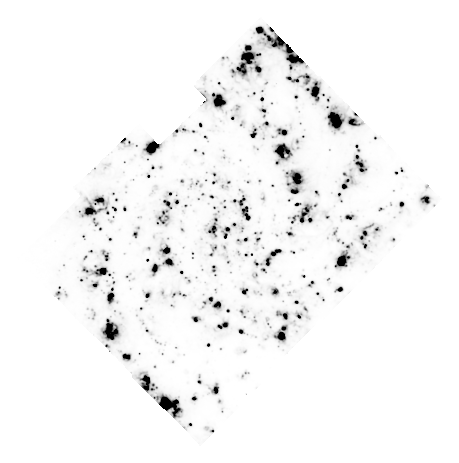

In [9]:
fig,ax=plt.subplots()

norm = simple_norm(Halpha.data,clip=False,percent=95)
ax.imshow(Halpha.data,norm=norm,origin='lower',cmap=plt.cm.Greys)
ax.axis('off')

plt.show()